In [1]:
%pwd

'C:\\Users\\big_u\\DIX PERCENTRANK TESTS'

In [2]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import backtrader.indicators as btind

from backtrader.feeds import GenericCSVData

In [3]:
class dix_csv(GenericCSVData):
    
    lines= ('dix', 'gex')
    
    params = (
        ('dtformat', '%m/%d/%Y'),
        ('datetime', 0),
        ('time', -1),
        ('open', 1),
        ('high', 2),
        ('low', 3),
        ('close', 4),
        ('volume', 6),
        ('openinterest', -1),
        ('dix', 9),
        ('gex', 10),        
    )

In [4]:
#buy at beginning of data and hold
class BuyAndHold_1(bt.Strategy):
    def start(self):
        self.val_start = self.broker.get_cash()  # keep the starting cash

    def nextstart(self):
        # Buy all the available cash
        size = int(self.broker.get_cash() / self.data)
        self.buy(size=size)

    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        print('ROI:        {:.2f}%'.format(100.0 * self.roi))

In [5]:
#run buy and hold strategy
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()    
    
    # Add a strategy
    cerebro.addstrategy(BuyAndHold_1)
    
    
    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, 'C:\\Users\\big_u\\DIX PERCENTRANK TESTS\DIX OHLC.csv')

    # Create a Data Feed
    data = dix_csv(
        dataname=datapath,
    )

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    # Print out the starting conditions
    #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()
    
    # Set the commission
    cerebro.broker.setcommission(commission=0.00)

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


ROI:        129.23%
Final Portfolio Value: 229228.25


<IPython.core.display.Javascript object>


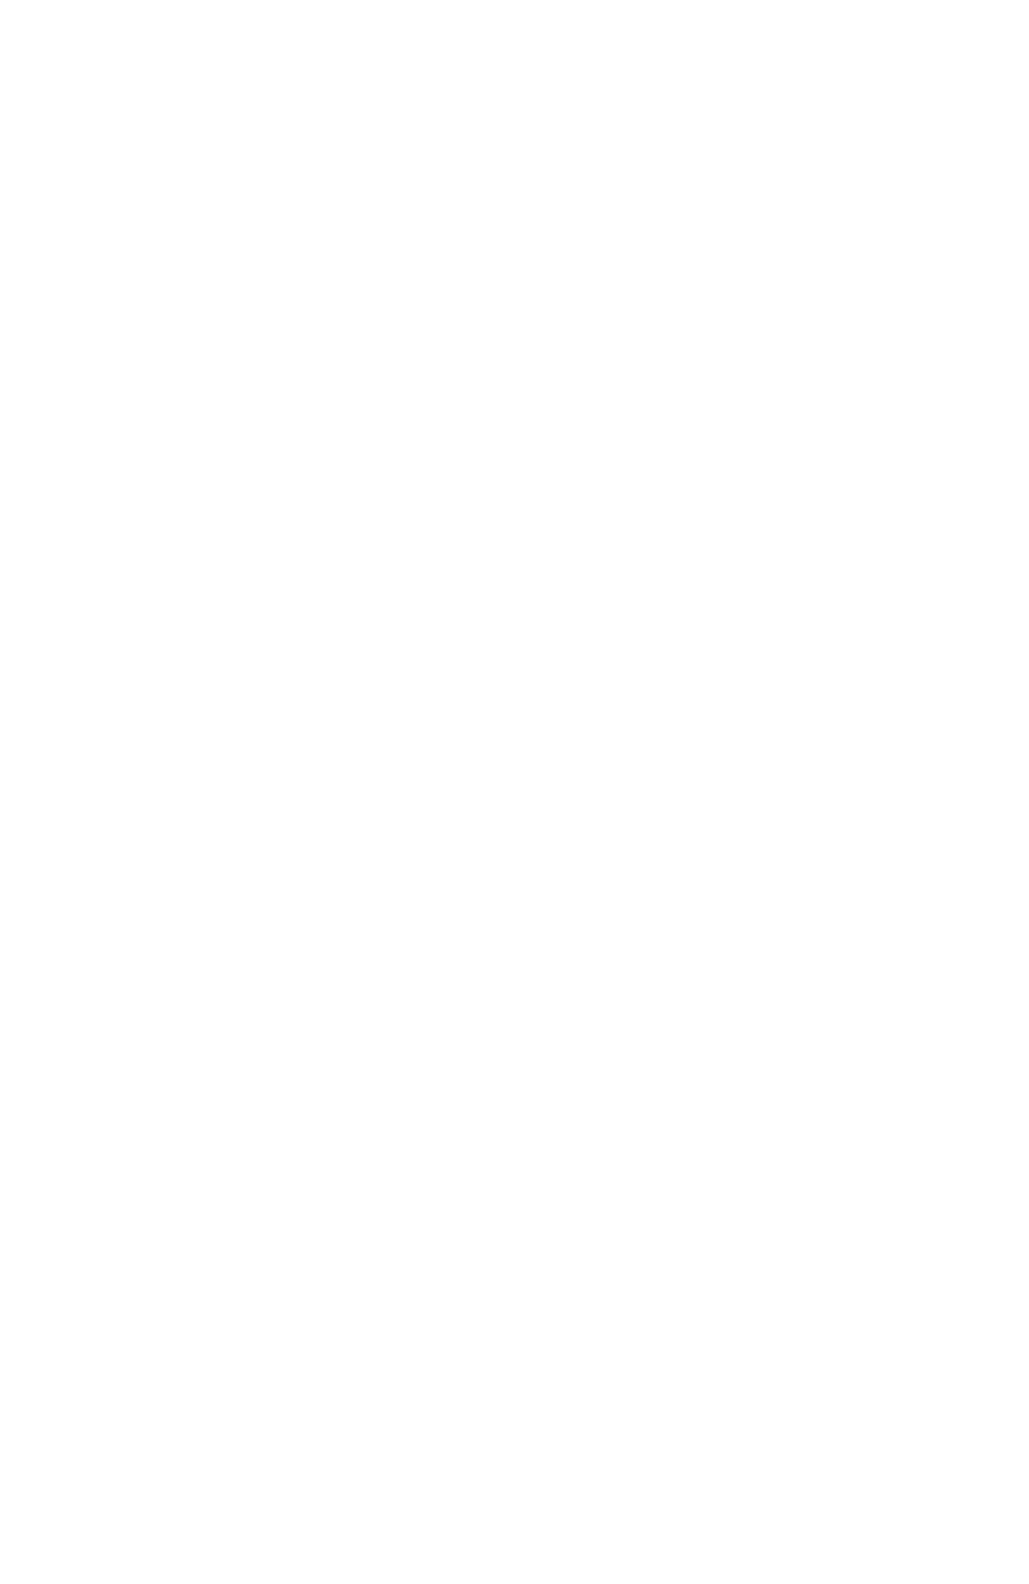

[[<Figure size 936x1440 with 4 Axes>]]

In [6]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 13, 20  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
# Plot the result
cerebro.plot()

In [7]:
#Create a Strategy DIX no MAs
class TestStrategy(bt.Strategy):
    params = (
        ('period', 252),
        ('printlog', False),
        ('dixupper', 46),
        ('dixlower', 40),
        ('threshold', 10),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a DIXSMA Indicator
        #self.dixsma = bt.indicators.sma(
        #    self.data.dix, period=self.params.period)
        
        # Add a PercentRank indicator
        self.pctrank = bt.indicators.PctRank(
        self.data.dix, period=self.params.period)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # buy when DIX percentrank 1 year upper 10th percentile
            if self.pctrank >= (1 - (self.params.threshold)/100):
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
                
        else:
            
            # sell when DIX percentrank 1 year lower 10th percentile
            if self.pctrank <= (0 + (self.params.threshold)/100):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
    def stop(self):
        self.log('(Threshold %2d)(Period %2d) Ending Value %.2f' %
                 (self.params.threshold, self.params.period, self.broker.getvalue()), doprint=True)

In [8]:
#DIX Strategy no MA run
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()    
    
    # Add a strategy
    cerebro.addstrategy(TestStrategy)
    
    
    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, 'C:\\Users\\big_u\\DIX PERCENTRANK TESTS\DIX OHLC.csv')

    # Create a Data Feed
    data = dix_csv(
        dataname=datapath,
    )

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    # Print out the starting conditions
    #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()
    
    # Set the commission
    cerebro.broker.setcommission(commission=0.00)

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


2020-07-02, (Threshold 10)(Period 252) Ending Value 101305.34
Final Portfolio Value: 101305.34


<IPython.core.display.Javascript object>


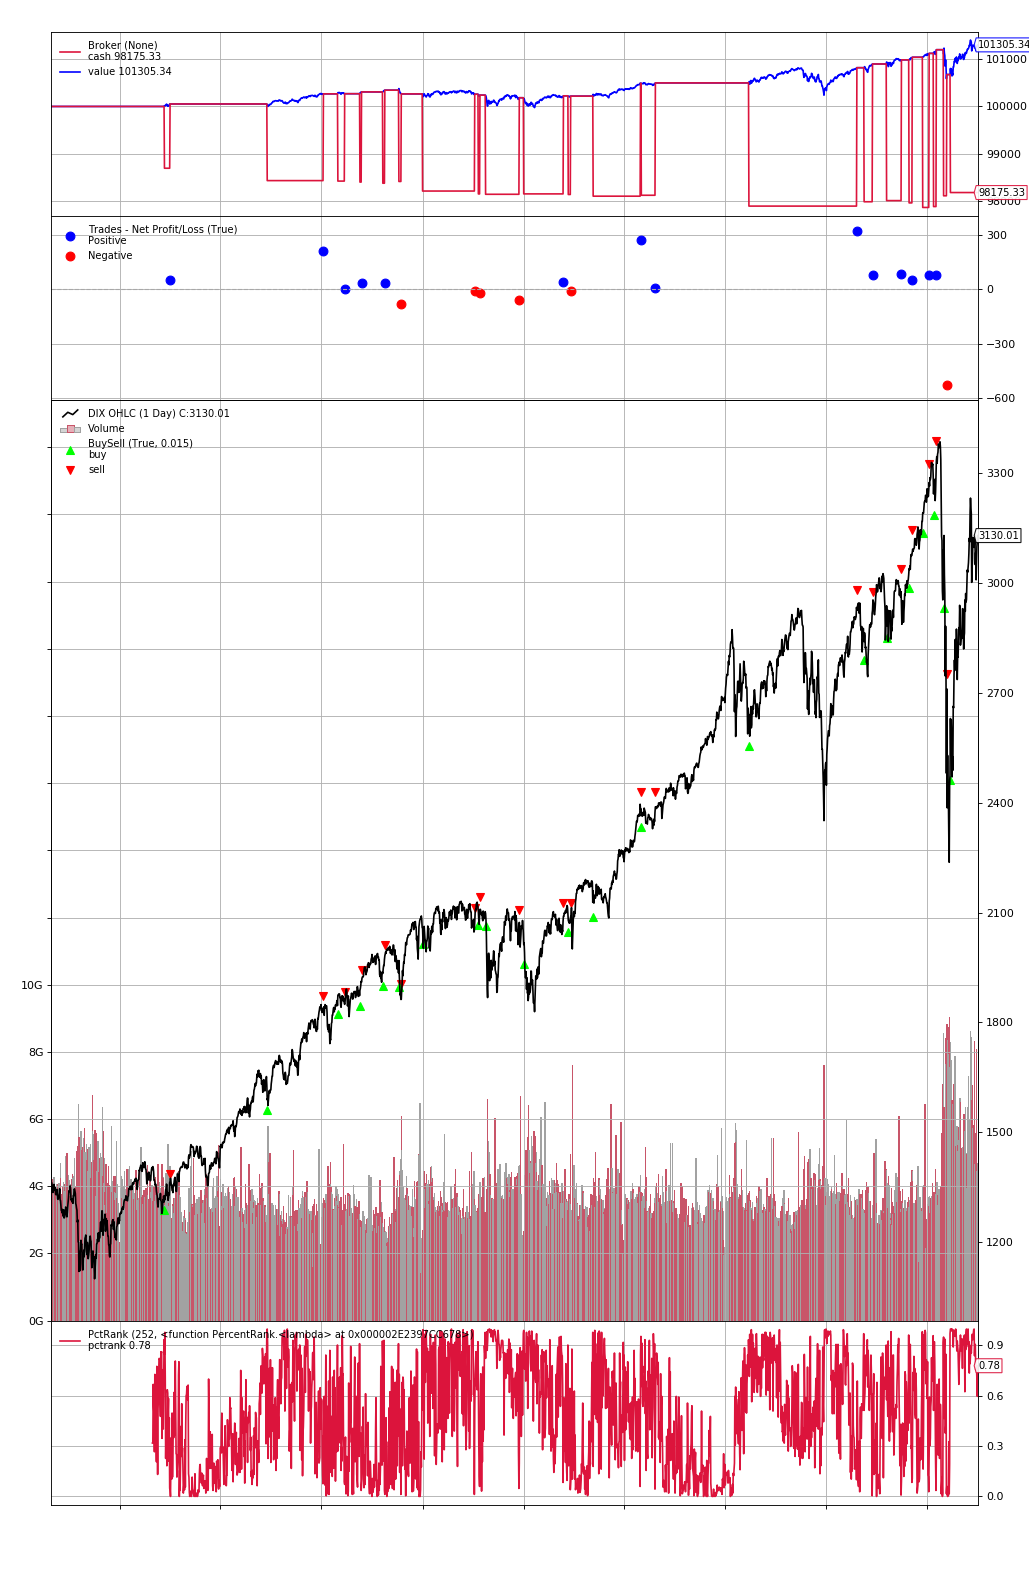

[[<Figure size 936x1440 with 5 Axes>]]

In [9]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 13, 20  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
# Plot the result
cerebro.plot()

In [10]:
#DIX Strategy no MA run
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()    
    
    # Add a strategy
    strats = cerebro.optstrategy(
        TestStrategy,
        period=range(252,1261),
        threshold=range(10,31)) 
    
    
    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, 'C:\\Users\\big_u\\DIX PERCENTRANK TESTS\DIX OHLC.csv')

    # Create a Data Feed
    data = dix_csv(
        dataname=datapath,
    )

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    # Print out the starting conditions
    #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run(maxcpus=1)
    
    # Set the commission
    cerebro.broker.setcommission(commission=0.00)

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

2020-07-02, (Threshold 10)(Period 252) Ending Value 101305.34
2020-07-02, (Threshold 11)(Period 252) Ending Value 101276.10
2020-07-02, (Threshold 12)(Period 252) Ending Value 100913.34
2020-07-02, (Threshold 13)(Period 252) Ending Value 100891.58
2020-07-02, (Threshold 14)(Period 252) Ending Value 101139.24
2020-07-02, (Threshold 15)(Period 252) Ending Value 101225.04
2020-07-02, (Threshold 16)(Period 252) Ending Value 101180.87
2020-07-02, (Threshold 17)(Period 252) Ending Value 101206.82
2020-07-02, (Threshold 18)(Period 252) Ending Value 101139.83
2020-07-02, (Threshold 19)(Period 252) Ending Value 101256.49
2020-07-02, (Threshold 20)(Period 252) Ending Value 101324.55
2020-07-02, (Threshold 21)(Period 252) Ending Value 101226.90
2020-07-02, (Threshold 22)(Period 252) Ending Value 101151.81
2020-07-02, (Threshold 23)(Period 252) Ending Value 101054.68
2020-07-02, (Threshold 24)(Period 252) Ending Value 101089.85
2020-07-02, (Threshold 25)(Period 252) Ending Value 101022.75
2020-07-

2020-07-02, (Threshold 17)(Period 258) Ending Value 101258.83
2020-07-02, (Threshold 18)(Period 258) Ending Value 101275.03
2020-07-02, (Threshold 19)(Period 258) Ending Value 101285.20
2020-07-02, (Threshold 20)(Period 258) Ending Value 101215.59
2020-07-02, (Threshold 21)(Period 258) Ending Value 101275.19
2020-07-02, (Threshold 22)(Period 258) Ending Value 101146.19
2020-07-02, (Threshold 23)(Period 258) Ending Value 101088.13
2020-07-02, (Threshold 24)(Period 258) Ending Value 101044.68
2020-07-02, (Threshold 25)(Period 258) Ending Value 101067.15
2020-07-02, (Threshold 26)(Period 258) Ending Value 101051.96
2020-07-02, (Threshold 27)(Period 258) Ending Value 101070.34
2020-07-02, (Threshold 28)(Period 258) Ending Value 101157.03
2020-07-02, (Threshold 29)(Period 258) Ending Value 101055.80
2020-07-02, (Threshold 30)(Period 258) Ending Value 101293.27
2020-07-02, (Threshold 10)(Period 259) Ending Value 101384.94
2020-07-02, (Threshold 11)(Period 259) Ending Value 101156.52
2020-07-

2020-07-02, (Threshold 24)(Period 264) Ending Value 101079.04
2020-07-02, (Threshold 25)(Period 264) Ending Value 101086.31
2020-07-02, (Threshold 26)(Period 264) Ending Value 101001.48
2020-07-02, (Threshold 27)(Period 264) Ending Value 101123.98
2020-07-02, (Threshold 28)(Period 264) Ending Value 101119.19
2020-07-02, (Threshold 29)(Period 264) Ending Value 101202.28
2020-07-02, (Threshold 30)(Period 264) Ending Value 101293.10
2020-07-02, (Threshold 10)(Period 265) Ending Value 101324.93
2020-07-02, (Threshold 11)(Period 265) Ending Value 101184.45
2020-07-02, (Threshold 12)(Period 265) Ending Value 101257.28
2020-07-02, (Threshold 13)(Period 265) Ending Value 100973.52
2020-07-02, (Threshold 14)(Period 265) Ending Value 101042.79
2020-07-02, (Threshold 15)(Period 265) Ending Value 101029.79
2020-07-02, (Threshold 16)(Period 265) Ending Value 101096.42
2020-07-02, (Threshold 17)(Period 265) Ending Value 101140.08
2020-07-02, (Threshold 18)(Period 265) Ending Value 101421.23
2020-07-

2020-07-02, (Threshold 10)(Period 271) Ending Value 101355.70
2020-07-02, (Threshold 11)(Period 271) Ending Value 101184.45
2020-07-02, (Threshold 12)(Period 271) Ending Value 101257.28
2020-07-02, (Threshold 13)(Period 271) Ending Value 101091.14
2020-07-02, (Threshold 14)(Period 271) Ending Value 101018.87
2020-07-02, (Threshold 15)(Period 271) Ending Value 101033.70
2020-07-02, (Threshold 16)(Period 271) Ending Value 101083.67
2020-07-02, (Threshold 17)(Period 271) Ending Value 101131.05
2020-07-02, (Threshold 18)(Period 271) Ending Value 101282.14
2020-07-02, (Threshold 19)(Period 271) Ending Value 101278.62
2020-07-02, (Threshold 20)(Period 271) Ending Value 101291.66
2020-07-02, (Threshold 21)(Period 271) Ending Value 101316.89
2020-07-02, (Threshold 22)(Period 271) Ending Value 101160.59
2020-07-02, (Threshold 23)(Period 271) Ending Value 101070.66
2020-07-02, (Threshold 24)(Period 271) Ending Value 101115.22
2020-07-02, (Threshold 25)(Period 271) Ending Value 101099.99
2020-07-

2020-07-02, (Threshold 17)(Period 277) Ending Value 101279.90
2020-07-02, (Threshold 18)(Period 277) Ending Value 101196.52
2020-07-02, (Threshold 19)(Period 277) Ending Value 101310.46
2020-07-02, (Threshold 20)(Period 277) Ending Value 101288.71
2020-07-02, (Threshold 21)(Period 277) Ending Value 101170.12
2020-07-02, (Threshold 22)(Period 277) Ending Value 101017.96
2020-07-02, (Threshold 23)(Period 277) Ending Value 101045.48
2020-07-02, (Threshold 24)(Period 277) Ending Value 101159.27
2020-07-02, (Threshold 25)(Period 277) Ending Value 101021.38
2020-07-02, (Threshold 26)(Period 277) Ending Value 101197.80
2020-07-02, (Threshold 27)(Period 277) Ending Value 101204.04
2020-07-02, (Threshold 28)(Period 277) Ending Value 101275.53
2020-07-02, (Threshold 29)(Period 277) Ending Value 101379.62
2020-07-02, (Threshold 30)(Period 277) Ending Value 101431.51
2020-07-02, (Threshold 10)(Period 278) Ending Value 101458.56
2020-07-02, (Threshold 11)(Period 278) Ending Value 101264.05
2020-07-

2020-07-02, (Threshold 24)(Period 283) Ending Value 101104.73
2020-07-02, (Threshold 25)(Period 283) Ending Value 101069.46
2020-07-02, (Threshold 26)(Period 283) Ending Value 101162.49
2020-07-02, (Threshold 27)(Period 283) Ending Value 101287.29
2020-07-02, (Threshold 28)(Period 283) Ending Value 101261.41
2020-07-02, (Threshold 29)(Period 283) Ending Value 101322.70
2020-07-02, (Threshold 30)(Period 283) Ending Value 101342.46
2020-07-02, (Threshold 10)(Period 284) Ending Value 101419.60
2020-07-02, (Threshold 11)(Period 284) Ending Value 101359.22
2020-07-02, (Threshold 12)(Period 284) Ending Value 101309.15
2020-07-02, (Threshold 13)(Period 284) Ending Value 101365.73
2020-07-02, (Threshold 14)(Period 284) Ending Value 101100.33
2020-07-02, (Threshold 15)(Period 284) Ending Value 101063.59
2020-07-02, (Threshold 16)(Period 284) Ending Value 101088.28
2020-07-02, (Threshold 17)(Period 284) Ending Value 101165.97
2020-07-02, (Threshold 18)(Period 284) Ending Value 101057.48
2020-07-

2020-07-02, (Threshold 10)(Period 290) Ending Value 101391.48
2020-07-02, (Threshold 11)(Period 290) Ending Value 101409.93
2020-07-02, (Threshold 12)(Period 290) Ending Value 101463.06
2020-07-02, (Threshold 13)(Period 290) Ending Value 101395.63
2020-07-02, (Threshold 14)(Period 290) Ending Value 101135.29
2020-07-02, (Threshold 15)(Period 290) Ending Value 101093.98
2020-07-02, (Threshold 16)(Period 290) Ending Value 101085.59
2020-07-02, (Threshold 17)(Period 290) Ending Value 101124.06
2020-07-02, (Threshold 18)(Period 290) Ending Value 101186.61
2020-07-02, (Threshold 19)(Period 290) Ending Value 101287.54
2020-07-02, (Threshold 20)(Period 290) Ending Value 101161.18
2020-07-02, (Threshold 21)(Period 290) Ending Value 101085.79
2020-07-02, (Threshold 22)(Period 290) Ending Value 100979.57
2020-07-02, (Threshold 23)(Period 290) Ending Value 101035.90
2020-07-02, (Threshold 24)(Period 290) Ending Value 100930.62
2020-07-02, (Threshold 25)(Period 290) Ending Value 101079.92
2020-07-

2020-07-02, (Threshold 17)(Period 296) Ending Value 101204.91
2020-07-02, (Threshold 18)(Period 296) Ending Value 101191.04
2020-07-02, (Threshold 19)(Period 296) Ending Value 101258.24
2020-07-02, (Threshold 20)(Period 296) Ending Value 101152.46
2020-07-02, (Threshold 21)(Period 296) Ending Value 100951.14
2020-07-02, (Threshold 22)(Period 296) Ending Value 101050.49
2020-07-02, (Threshold 23)(Period 296) Ending Value 101036.32
2020-07-02, (Threshold 24)(Period 296) Ending Value 100907.22
2020-07-02, (Threshold 25)(Period 296) Ending Value 101110.80
2020-07-02, (Threshold 26)(Period 296) Ending Value 101077.27
2020-07-02, (Threshold 27)(Period 296) Ending Value 101216.16
2020-07-02, (Threshold 28)(Period 296) Ending Value 101275.25
2020-07-02, (Threshold 29)(Period 296) Ending Value 101287.31
2020-07-02, (Threshold 30)(Period 296) Ending Value 101247.70
2020-07-02, (Threshold 10)(Period 297) Ending Value 101386.16
2020-07-02, (Threshold 11)(Period 297) Ending Value 101491.75
2020-07-

2020-07-02, (Threshold 24)(Period 302) Ending Value 101073.81
2020-07-02, (Threshold 25)(Period 302) Ending Value 101081.81
2020-07-02, (Threshold 26)(Period 302) Ending Value 101123.37
2020-07-02, (Threshold 27)(Period 302) Ending Value 101188.44
2020-07-02, (Threshold 28)(Period 302) Ending Value 101285.25
2020-07-02, (Threshold 29)(Period 302) Ending Value 101380.22
2020-07-02, (Threshold 30)(Period 302) Ending Value 101282.69
2020-07-02, (Threshold 10)(Period 303) Ending Value 101386.16
2020-07-02, (Threshold 11)(Period 303) Ending Value 101491.75
2020-07-02, (Threshold 12)(Period 303) Ending Value 101575.35
2020-07-02, (Threshold 13)(Period 303) Ending Value 101506.12
2020-07-02, (Threshold 14)(Period 303) Ending Value 101404.61
2020-07-02, (Threshold 15)(Period 303) Ending Value 101410.91
2020-07-02, (Threshold 16)(Period 303) Ending Value 101502.85
2020-07-02, (Threshold 17)(Period 303) Ending Value 101089.90
2020-07-02, (Threshold 18)(Period 303) Ending Value 101191.84
2020-07-

2020-07-02, (Threshold 10)(Period 309) Ending Value 101408.43
2020-07-02, (Threshold 11)(Period 309) Ending Value 101494.89
2020-07-02, (Threshold 12)(Period 309) Ending Value 101578.96
2020-07-02, (Threshold 13)(Period 309) Ending Value 101476.22
2020-07-02, (Threshold 14)(Period 309) Ending Value 101435.00
2020-07-02, (Threshold 15)(Period 309) Ending Value 101433.88
2020-07-02, (Threshold 16)(Period 309) Ending Value 101496.12
2020-07-02, (Threshold 17)(Period 309) Ending Value 101233.89
2020-07-02, (Threshold 18)(Period 309) Ending Value 101219.02
2020-07-02, (Threshold 19)(Period 309) Ending Value 101170.50
2020-07-02, (Threshold 20)(Period 309) Ending Value 101103.25
2020-07-02, (Threshold 21)(Period 309) Ending Value 100999.61
2020-07-02, (Threshold 22)(Period 309) Ending Value 101083.03
2020-07-02, (Threshold 23)(Period 309) Ending Value 100973.67
2020-07-02, (Threshold 24)(Period 309) Ending Value 101111.71
2020-07-02, (Threshold 25)(Period 309) Ending Value 101193.95
2020-07-

2020-07-02, (Threshold 17)(Period 315) Ending Value 101399.18
2020-07-02, (Threshold 18)(Period 315) Ending Value 101290.79
2020-07-02, (Threshold 19)(Period 315) Ending Value 101148.54
2020-07-02, (Threshold 20)(Period 315) Ending Value 101042.09
2020-07-02, (Threshold 21)(Period 315) Ending Value 101021.64
2020-07-02, (Threshold 22)(Period 315) Ending Value 101039.83
2020-07-02, (Threshold 23)(Period 315) Ending Value 100981.47
2020-07-02, (Threshold 24)(Period 315) Ending Value 101191.90
2020-07-02, (Threshold 25)(Period 315) Ending Value 101055.73
2020-07-02, (Threshold 26)(Period 315) Ending Value 101168.60
2020-07-02, (Threshold 27)(Period 315) Ending Value 101159.05
2020-07-02, (Threshold 28)(Period 315) Ending Value 101235.14
2020-07-02, (Threshold 29)(Period 315) Ending Value 101279.34
2020-07-02, (Threshold 30)(Period 315) Ending Value 101264.38
2020-07-02, (Threshold 10)(Period 316) Ending Value 101579.95
2020-07-02, (Threshold 11)(Period 316) Ending Value 101504.76
2020-07-

2020-07-02, (Threshold 24)(Period 321) Ending Value 101104.48
2020-07-02, (Threshold 25)(Period 321) Ending Value 101019.98
2020-07-02, (Threshold 26)(Period 321) Ending Value 101133.86
2020-07-02, (Threshold 27)(Period 321) Ending Value 101166.82
2020-07-02, (Threshold 28)(Period 321) Ending Value 101175.97
2020-07-02, (Threshold 29)(Period 321) Ending Value 101280.86
2020-07-02, (Threshold 30)(Period 321) Ending Value 101258.69
2020-07-02, (Threshold 10)(Period 322) Ending Value 101680.22
2020-07-02, (Threshold 11)(Period 322) Ending Value 101785.63
2020-07-02, (Threshold 12)(Period 322) Ending Value 101563.07
2020-07-02, (Threshold 13)(Period 322) Ending Value 101514.23
2020-07-02, (Threshold 14)(Period 322) Ending Value 101507.87
2020-07-02, (Threshold 15)(Period 322) Ending Value 101656.55
2020-07-02, (Threshold 16)(Period 322) Ending Value 101378.06
2020-07-02, (Threshold 17)(Period 322) Ending Value 101558.71
2020-07-02, (Threshold 18)(Period 322) Ending Value 101333.06
2020-07-

2020-07-02, (Threshold 10)(Period 328) Ending Value 101673.32
2020-07-02, (Threshold 11)(Period 328) Ending Value 101723.06
2020-07-02, (Threshold 12)(Period 328) Ending Value 101699.10
2020-07-02, (Threshold 13)(Period 328) Ending Value 101557.61
2020-07-02, (Threshold 14)(Period 328) Ending Value 101516.12
2020-07-02, (Threshold 15)(Period 328) Ending Value 101572.62
2020-07-02, (Threshold 16)(Period 328) Ending Value 101610.88
2020-07-02, (Threshold 17)(Period 328) Ending Value 101532.07
2020-07-02, (Threshold 18)(Period 328) Ending Value 101237.96
2020-07-02, (Threshold 19)(Period 328) Ending Value 101087.42
2020-07-02, (Threshold 20)(Period 328) Ending Value 101019.92
2020-07-02, (Threshold 21)(Period 328) Ending Value 100999.52
2020-07-02, (Threshold 22)(Period 328) Ending Value 101024.75
2020-07-02, (Threshold 23)(Period 328) Ending Value 101240.33
2020-07-02, (Threshold 24)(Period 328) Ending Value 101112.33
2020-07-02, (Threshold 25)(Period 328) Ending Value 101129.45
2020-07-

2020-07-02, (Threshold 17)(Period 334) Ending Value 101583.56
2020-07-02, (Threshold 18)(Period 334) Ending Value 101299.12
2020-07-02, (Threshold 19)(Period 334) Ending Value 101196.42
2020-07-02, (Threshold 20)(Period 334) Ending Value 101061.33
2020-07-02, (Threshold 21)(Period 334) Ending Value 100939.52
2020-07-02, (Threshold 22)(Period 334) Ending Value 101126.14
2020-07-02, (Threshold 23)(Period 334) Ending Value 101213.49
2020-07-02, (Threshold 24)(Period 334) Ending Value 101134.35
2020-07-02, (Threshold 25)(Period 334) Ending Value 101189.65
2020-07-02, (Threshold 26)(Period 334) Ending Value 101218.64
2020-07-02, (Threshold 27)(Period 334) Ending Value 101174.06
2020-07-02, (Threshold 28)(Period 334) Ending Value 101305.86
2020-07-02, (Threshold 29)(Period 334) Ending Value 101284.59
2020-07-02, (Threshold 30)(Period 334) Ending Value 101376.35
2020-07-02, (Threshold 10)(Period 335) Ending Value 101637.09
2020-07-02, (Threshold 11)(Period 335) Ending Value 101742.19
2020-07-

2020-07-02, (Threshold 24)(Period 340) Ending Value 101097.08
2020-07-02, (Threshold 25)(Period 340) Ending Value 101255.87
2020-07-02, (Threshold 26)(Period 340) Ending Value 101253.65
2020-07-02, (Threshold 27)(Period 340) Ending Value 101225.33
2020-07-02, (Threshold 28)(Period 340) Ending Value 101281.11
2020-07-02, (Threshold 29)(Period 340) Ending Value 101326.57
2020-07-02, (Threshold 30)(Period 340) Ending Value 101328.12
2020-07-02, (Threshold 10)(Period 341) Ending Value 101637.09
2020-07-02, (Threshold 11)(Period 341) Ending Value 101742.19
2020-07-02, (Threshold 12)(Period 341) Ending Value 101711.54
2020-07-02, (Threshold 13)(Period 341) Ending Value 101634.51
2020-07-02, (Threshold 14)(Period 341) Ending Value 101707.37
2020-07-02, (Threshold 15)(Period 341) Ending Value 101488.82
2020-07-02, (Threshold 16)(Period 341) Ending Value 101653.86
2020-07-02, (Threshold 17)(Period 341) Ending Value 101547.88
2020-07-02, (Threshold 18)(Period 341) Ending Value 101457.55
2020-07-

2020-07-02, (Threshold 10)(Period 347) Ending Value 101570.14
2020-07-02, (Threshold 11)(Period 347) Ending Value 101661.07
2020-07-02, (Threshold 12)(Period 347) Ending Value 101711.54
2020-07-02, (Threshold 13)(Period 347) Ending Value 101671.26
2020-07-02, (Threshold 14)(Period 347) Ending Value 101835.46
2020-07-02, (Threshold 15)(Period 347) Ending Value 101639.34
2020-07-02, (Threshold 16)(Period 347) Ending Value 101638.20
2020-07-02, (Threshold 17)(Period 347) Ending Value 101571.97
2020-07-02, (Threshold 18)(Period 347) Ending Value 101374.56
2020-07-02, (Threshold 19)(Period 347) Ending Value 101356.64
2020-07-02, (Threshold 20)(Period 347) Ending Value 101179.46
2020-07-02, (Threshold 21)(Period 347) Ending Value 101160.73
2020-07-02, (Threshold 22)(Period 347) Ending Value 101161.25
2020-07-02, (Threshold 23)(Period 347) Ending Value 101124.85
2020-07-02, (Threshold 24)(Period 347) Ending Value 101149.07
2020-07-02, (Threshold 25)(Period 347) Ending Value 101151.84
2020-07-

2020-07-02, (Threshold 17)(Period 353) Ending Value 101504.22
2020-07-02, (Threshold 18)(Period 353) Ending Value 101428.19
2020-07-02, (Threshold 19)(Period 353) Ending Value 101406.42
2020-07-02, (Threshold 20)(Period 353) Ending Value 101320.07
2020-07-02, (Threshold 21)(Period 353) Ending Value 101340.25
2020-07-02, (Threshold 22)(Period 353) Ending Value 101317.32
2020-07-02, (Threshold 23)(Period 353) Ending Value 101094.07
2020-07-02, (Threshold 24)(Period 353) Ending Value 101087.86
2020-07-02, (Threshold 25)(Period 353) Ending Value 101143.32
2020-07-02, (Threshold 26)(Period 353) Ending Value 101243.69
2020-07-02, (Threshold 27)(Period 353) Ending Value 101331.20
2020-07-02, (Threshold 28)(Period 353) Ending Value 101313.30
2020-07-02, (Threshold 29)(Period 353) Ending Value 101362.46
2020-07-02, (Threshold 30)(Period 353) Ending Value 101398.39
2020-07-02, (Threshold 10)(Period 354) Ending Value 101602.21
2020-07-02, (Threshold 11)(Period 354) Ending Value 101624.84
2020-07-

2020-07-02, (Threshold 24)(Period 359) Ending Value 101102.87
2020-07-02, (Threshold 25)(Period 359) Ending Value 101111.22
2020-07-02, (Threshold 26)(Period 359) Ending Value 101247.40
2020-07-02, (Threshold 27)(Period 359) Ending Value 101324.21
2020-07-02, (Threshold 28)(Period 359) Ending Value 101275.36
2020-07-02, (Threshold 29)(Period 359) Ending Value 101410.93
2020-07-02, (Threshold 30)(Period 359) Ending Value 101397.49
2020-07-02, (Threshold 10)(Period 360) Ending Value 101570.14
2020-07-02, (Threshold 11)(Period 360) Ending Value 101570.46
2020-07-02, (Threshold 12)(Period 360) Ending Value 101635.96
2020-07-02, (Threshold 13)(Period 360) Ending Value 101588.03
2020-07-02, (Threshold 14)(Period 360) Ending Value 101642.80
2020-07-02, (Threshold 15)(Period 360) Ending Value 101716.81
2020-07-02, (Threshold 16)(Period 360) Ending Value 101610.15
2020-07-02, (Threshold 17)(Period 360) Ending Value 101482.67
2020-07-02, (Threshold 18)(Period 360) Ending Value 101390.00
2020-07-

2020-07-02, (Threshold 10)(Period 366) Ending Value 101602.21
2020-07-02, (Threshold 11)(Period 366) Ending Value 101570.46
2020-07-02, (Threshold 12)(Period 366) Ending Value 101634.31
2020-07-02, (Threshold 13)(Period 366) Ending Value 101754.01
2020-07-02, (Threshold 14)(Period 366) Ending Value 101589.58
2020-07-02, (Threshold 15)(Period 366) Ending Value 101700.32
2020-07-02, (Threshold 16)(Period 366) Ending Value 101556.79
2020-07-02, (Threshold 17)(Period 366) Ending Value 101436.39
2020-07-02, (Threshold 18)(Period 366) Ending Value 101409.11
2020-07-02, (Threshold 19)(Period 366) Ending Value 101303.01
2020-07-02, (Threshold 20)(Period 366) Ending Value 101435.90
2020-07-02, (Threshold 21)(Period 366) Ending Value 101505.21
2020-07-02, (Threshold 22)(Period 366) Ending Value 101397.82
2020-07-02, (Threshold 23)(Period 366) Ending Value 101233.09
2020-07-02, (Threshold 24)(Period 366) Ending Value 101162.38
2020-07-02, (Threshold 25)(Period 366) Ending Value 101090.01
2020-07-

2020-07-02, (Threshold 17)(Period 372) Ending Value 101439.97
2020-07-02, (Threshold 18)(Period 372) Ending Value 101413.94
2020-07-02, (Threshold 19)(Period 372) Ending Value 101259.35
2020-07-02, (Threshold 20)(Period 372) Ending Value 101422.98
2020-07-02, (Threshold 21)(Period 372) Ending Value 101351.52
2020-07-02, (Threshold 22)(Period 372) Ending Value 101417.95
2020-07-02, (Threshold 23)(Period 372) Ending Value 101391.62
2020-07-02, (Threshold 24)(Period 372) Ending Value 101154.46
2020-07-02, (Threshold 25)(Period 372) Ending Value 101140.56
2020-07-02, (Threshold 26)(Period 372) Ending Value 101264.46
2020-07-02, (Threshold 27)(Period 372) Ending Value 101302.58
2020-07-02, (Threshold 28)(Period 372) Ending Value 101324.89
2020-07-02, (Threshold 29)(Period 372) Ending Value 101259.02
2020-07-02, (Threshold 30)(Period 372) Ending Value 101379.69
2020-07-02, (Threshold 10)(Period 373) Ending Value 101602.21
2020-07-02, (Threshold 11)(Period 373) Ending Value 101574.07
2020-07-

2020-07-02, (Threshold 24)(Period 378) Ending Value 101388.48
2020-07-02, (Threshold 25)(Period 378) Ending Value 101299.61
2020-07-02, (Threshold 26)(Period 378) Ending Value 101213.94
2020-07-02, (Threshold 27)(Period 378) Ending Value 101317.24
2020-07-02, (Threshold 28)(Period 378) Ending Value 101330.50
2020-07-02, (Threshold 29)(Period 378) Ending Value 101158.86
2020-07-02, (Threshold 30)(Period 378) Ending Value 101353.65
2020-07-02, (Threshold 10)(Period 379) Ending Value 101548.47
2020-07-02, (Threshold 11)(Period 379) Ending Value 101570.46
2020-07-02, (Threshold 12)(Period 379) Ending Value 101512.44
2020-07-02, (Threshold 13)(Period 379) Ending Value 101719.36
2020-07-02, (Threshold 14)(Period 379) Ending Value 101660.21
2020-07-02, (Threshold 15)(Period 379) Ending Value 101711.04
2020-07-02, (Threshold 16)(Period 379) Ending Value 101636.11
2020-07-02, (Threshold 17)(Period 379) Ending Value 101494.54
2020-07-02, (Threshold 18)(Period 379) Ending Value 101413.01
2020-07-

2020-07-02, (Threshold 10)(Period 385) Ending Value 101472.75
2020-07-02, (Threshold 11)(Period 385) Ending Value 101552.40
2020-07-02, (Threshold 12)(Period 385) Ending Value 101503.45
2020-07-02, (Threshold 13)(Period 385) Ending Value 101613.95
2020-07-02, (Threshold 14)(Period 385) Ending Value 101733.50
2020-07-02, (Threshold 15)(Period 385) Ending Value 101691.04
2020-07-02, (Threshold 16)(Period 385) Ending Value 101614.37
2020-07-02, (Threshold 17)(Period 385) Ending Value 101515.18
2020-07-02, (Threshold 18)(Period 385) Ending Value 101359.38
2020-07-02, (Threshold 19)(Period 385) Ending Value 101449.76
2020-07-02, (Threshold 20)(Period 385) Ending Value 101460.21
2020-07-02, (Threshold 21)(Period 385) Ending Value 101435.92
2020-07-02, (Threshold 22)(Period 385) Ending Value 101419.64
2020-07-02, (Threshold 23)(Period 385) Ending Value 101338.88
2020-07-02, (Threshold 24)(Period 385) Ending Value 101364.86
2020-07-02, (Threshold 25)(Period 385) Ending Value 101372.58
2020-07-

2020-07-02, (Threshold 17)(Period 391) Ending Value 101567.93
2020-07-02, (Threshold 18)(Period 391) Ending Value 101414.12
2020-07-02, (Threshold 19)(Period 391) Ending Value 101490.02
2020-07-02, (Threshold 20)(Period 391) Ending Value 101469.78
2020-07-02, (Threshold 21)(Period 391) Ending Value 101528.61
2020-07-02, (Threshold 22)(Period 391) Ending Value 101420.12
2020-07-02, (Threshold 23)(Period 391) Ending Value 101336.94
2020-07-02, (Threshold 24)(Period 391) Ending Value 101362.08
2020-07-02, (Threshold 25)(Period 391) Ending Value 101331.64
2020-07-02, (Threshold 26)(Period 391) Ending Value 101345.68
2020-07-02, (Threshold 27)(Period 391) Ending Value 101234.57
2020-07-02, (Threshold 28)(Period 391) Ending Value 101175.94
2020-07-02, (Threshold 29)(Period 391) Ending Value 101258.44
2020-07-02, (Threshold 30)(Period 391) Ending Value 101365.09
2020-07-02, (Threshold 10)(Period 392) Ending Value 101523.78
2020-07-02, (Threshold 11)(Period 392) Ending Value 101571.34
2020-07-

2020-07-02, (Threshold 24)(Period 397) Ending Value 101323.92
2020-07-02, (Threshold 25)(Period 397) Ending Value 101276.23
2020-07-02, (Threshold 26)(Period 397) Ending Value 101368.16
2020-07-02, (Threshold 27)(Period 397) Ending Value 101303.39
2020-07-02, (Threshold 28)(Period 397) Ending Value 101104.14
2020-07-02, (Threshold 29)(Period 397) Ending Value 101251.65
2020-07-02, (Threshold 30)(Period 397) Ending Value 101397.70
2020-07-02, (Threshold 10)(Period 398) Ending Value 101623.48
2020-07-02, (Threshold 11)(Period 398) Ending Value 101635.04
2020-07-02, (Threshold 12)(Period 398) Ending Value 101665.44
2020-07-02, (Threshold 13)(Period 398) Ending Value 101578.54
2020-07-02, (Threshold 14)(Period 398) Ending Value 101598.13
2020-07-02, (Threshold 15)(Period 398) Ending Value 101456.99
2020-07-02, (Threshold 16)(Period 398) Ending Value 101624.89
2020-07-02, (Threshold 17)(Period 398) Ending Value 101594.44
2020-07-02, (Threshold 18)(Period 398) Ending Value 101394.99
2020-07-

2020-07-02, (Threshold 10)(Period 404) Ending Value 101623.48
2020-07-02, (Threshold 11)(Period 404) Ending Value 101578.42
2020-07-02, (Threshold 12)(Period 404) Ending Value 101698.84
2020-07-02, (Threshold 13)(Period 404) Ending Value 101697.15
2020-07-02, (Threshold 14)(Period 404) Ending Value 101530.48
2020-07-02, (Threshold 15)(Period 404) Ending Value 101456.99
2020-07-02, (Threshold 16)(Period 404) Ending Value 101593.57
2020-07-02, (Threshold 17)(Period 404) Ending Value 101647.20
2020-07-02, (Threshold 18)(Period 404) Ending Value 101475.28
2020-07-02, (Threshold 19)(Period 404) Ending Value 101435.00
2020-07-02, (Threshold 20)(Period 404) Ending Value 101428.45
2020-07-02, (Threshold 21)(Period 404) Ending Value 101496.83
2020-07-02, (Threshold 22)(Period 404) Ending Value 101500.02
2020-07-02, (Threshold 23)(Period 404) Ending Value 101484.12
2020-07-02, (Threshold 24)(Period 404) Ending Value 101390.10
2020-07-02, (Threshold 25)(Period 404) Ending Value 101291.20
2020-07-

2020-07-02, (Threshold 17)(Period 410) Ending Value 101483.45
2020-07-02, (Threshold 18)(Period 410) Ending Value 101478.55
2020-07-02, (Threshold 19)(Period 410) Ending Value 101435.00
2020-07-02, (Threshold 20)(Period 410) Ending Value 101428.45
2020-07-02, (Threshold 21)(Period 410) Ending Value 101436.63
2020-07-02, (Threshold 22)(Period 410) Ending Value 101460.14
2020-07-02, (Threshold 23)(Period 410) Ending Value 101637.71
2020-07-02, (Threshold 24)(Period 410) Ending Value 101373.88
2020-07-02, (Threshold 25)(Period 410) Ending Value 101354.50
2020-07-02, (Threshold 26)(Period 410) Ending Value 101330.47
2020-07-02, (Threshold 27)(Period 410) Ending Value 101295.93
2020-07-02, (Threshold 28)(Period 410) Ending Value 101316.79
2020-07-02, (Threshold 29)(Period 410) Ending Value 101280.56
2020-07-02, (Threshold 30)(Period 410) Ending Value 101373.81
2020-07-02, (Threshold 10)(Period 411) Ending Value 101612.62
2020-07-02, (Threshold 11)(Period 411) Ending Value 101576.35
2020-07-

2020-07-02, (Threshold 24)(Period 416) Ending Value 101374.22
2020-07-02, (Threshold 25)(Period 416) Ending Value 101402.57
2020-07-02, (Threshold 26)(Period 416) Ending Value 101342.33
2020-07-02, (Threshold 27)(Period 416) Ending Value 101310.81
2020-07-02, (Threshold 28)(Period 416) Ending Value 101363.86
2020-07-02, (Threshold 29)(Period 416) Ending Value 101216.43
2020-07-02, (Threshold 30)(Period 416) Ending Value 101340.10
2020-07-02, (Threshold 10)(Period 417) Ending Value 101612.62
2020-07-02, (Threshold 11)(Period 417) Ending Value 101612.35
2020-07-02, (Threshold 12)(Period 417) Ending Value 101615.48
2020-07-02, (Threshold 13)(Period 417) Ending Value 101642.31
2020-07-02, (Threshold 14)(Period 417) Ending Value 101394.84
2020-07-02, (Threshold 15)(Period 417) Ending Value 101415.73
2020-07-02, (Threshold 16)(Period 417) Ending Value 101486.56
2020-07-02, (Threshold 17)(Period 417) Ending Value 101380.59
2020-07-02, (Threshold 18)(Period 417) Ending Value 101398.84
2020-07-

2020-07-02, (Threshold 10)(Period 423) Ending Value 101612.62
2020-07-02, (Threshold 11)(Period 423) Ending Value 101418.87
2020-07-02, (Threshold 12)(Period 423) Ending Value 101572.73
2020-07-02, (Threshold 13)(Period 423) Ending Value 101648.42
2020-07-02, (Threshold 14)(Period 423) Ending Value 101429.42
2020-07-02, (Threshold 15)(Period 423) Ending Value 101415.73
2020-07-02, (Threshold 16)(Period 423) Ending Value 101517.88
2020-07-02, (Threshold 17)(Period 423) Ending Value 101385.16
2020-07-02, (Threshold 18)(Period 423) Ending Value 101394.87
2020-07-02, (Threshold 19)(Period 423) Ending Value 101357.69
2020-07-02, (Threshold 20)(Period 423) Ending Value 101428.45
2020-07-02, (Threshold 21)(Period 423) Ending Value 101459.67
2020-07-02, (Threshold 22)(Period 423) Ending Value 101441.64
2020-07-02, (Threshold 23)(Period 423) Ending Value 101480.66
2020-07-02, (Threshold 24)(Period 423) Ending Value 101456.31
2020-07-02, (Threshold 25)(Period 423) Ending Value 101447.81
2020-07-

2020-07-02, (Threshold 17)(Period 429) Ending Value 101398.34
2020-07-02, (Threshold 18)(Period 429) Ending Value 101353.07
2020-07-02, (Threshold 19)(Period 429) Ending Value 101321.00
2020-07-02, (Threshold 20)(Period 429) Ending Value 101316.80
2020-07-02, (Threshold 21)(Period 429) Ending Value 101417.35
2020-07-02, (Threshold 22)(Period 429) Ending Value 101532.75
2020-07-02, (Threshold 23)(Period 429) Ending Value 101408.82
2020-07-02, (Threshold 24)(Period 429) Ending Value 101456.76
2020-07-02, (Threshold 25)(Period 429) Ending Value 101457.00
2020-07-02, (Threshold 26)(Period 429) Ending Value 101445.85
2020-07-02, (Threshold 27)(Period 429) Ending Value 101384.36
2020-07-02, (Threshold 28)(Period 429) Ending Value 101270.32
2020-07-02, (Threshold 29)(Period 429) Ending Value 101295.36
2020-07-02, (Threshold 30)(Period 429) Ending Value 101422.59
2020-07-02, (Threshold 10)(Period 430) Ending Value 101490.65
2020-07-02, (Threshold 11)(Period 430) Ending Value 101679.75
2020-07-

2020-07-02, (Threshold 24)(Period 435) Ending Value 101529.96
2020-07-02, (Threshold 25)(Period 435) Ending Value 101435.24
2020-07-02, (Threshold 26)(Period 435) Ending Value 101395.57
2020-07-02, (Threshold 27)(Period 435) Ending Value 101451.05
2020-07-02, (Threshold 28)(Period 435) Ending Value 101381.77
2020-07-02, (Threshold 29)(Period 435) Ending Value 101312.19
2020-07-02, (Threshold 30)(Period 435) Ending Value 101421.57
2020-07-02, (Threshold 10)(Period 436) Ending Value 101490.65
2020-07-02, (Threshold 11)(Period 436) Ending Value 101650.36
2020-07-02, (Threshold 12)(Period 436) Ending Value 101787.59
2020-07-02, (Threshold 13)(Period 436) Ending Value 101513.50
2020-07-02, (Threshold 14)(Period 436) Ending Value 101468.03
2020-07-02, (Threshold 15)(Period 436) Ending Value 101504.11
2020-07-02, (Threshold 16)(Period 436) Ending Value 101384.58
2020-07-02, (Threshold 17)(Period 436) Ending Value 101397.87
2020-07-02, (Threshold 18)(Period 436) Ending Value 101357.88
2020-07-

2020-07-02, (Threshold 10)(Period 442) Ending Value 101484.86
2020-07-02, (Threshold 11)(Period 442) Ending Value 101586.66
2020-07-02, (Threshold 12)(Period 442) Ending Value 101787.59
2020-07-02, (Threshold 13)(Period 442) Ending Value 101566.82
2020-07-02, (Threshold 14)(Period 442) Ending Value 101468.03
2020-07-02, (Threshold 15)(Period 442) Ending Value 101503.55
2020-07-02, (Threshold 16)(Period 442) Ending Value 101396.54
2020-07-02, (Threshold 17)(Period 442) Ending Value 101436.18
2020-07-02, (Threshold 18)(Period 442) Ending Value 101357.88
2020-07-02, (Threshold 19)(Period 442) Ending Value 101325.81
2020-07-02, (Threshold 20)(Period 442) Ending Value 101310.09
2020-07-02, (Threshold 21)(Period 442) Ending Value 101269.94
2020-07-02, (Threshold 22)(Period 442) Ending Value 101596.92
2020-07-02, (Threshold 23)(Period 442) Ending Value 101466.76
2020-07-02, (Threshold 24)(Period 442) Ending Value 101482.12
2020-07-02, (Threshold 25)(Period 442) Ending Value 101520.15
2020-07-

2020-07-02, (Threshold 17)(Period 448) Ending Value 101437.97
2020-07-02, (Threshold 18)(Period 448) Ending Value 101440.12
2020-07-02, (Threshold 19)(Period 448) Ending Value 101317.11
2020-07-02, (Threshold 20)(Period 448) Ending Value 101283.56
2020-07-02, (Threshold 21)(Period 448) Ending Value 101397.18
2020-07-02, (Threshold 22)(Period 448) Ending Value 101645.61
2020-07-02, (Threshold 23)(Period 448) Ending Value 101472.86
2020-07-02, (Threshold 24)(Period 448) Ending Value 101480.08
2020-07-02, (Threshold 25)(Period 448) Ending Value 101514.06
2020-07-02, (Threshold 26)(Period 448) Ending Value 101461.81
2020-07-02, (Threshold 27)(Period 448) Ending Value 101417.62
2020-07-02, (Threshold 28)(Period 448) Ending Value 101435.93
2020-07-02, (Threshold 29)(Period 448) Ending Value 101402.69
2020-07-02, (Threshold 30)(Period 448) Ending Value 101441.42
2020-07-02, (Threshold 10)(Period 449) Ending Value 101511.82
2020-07-02, (Threshold 11)(Period 449) Ending Value 101792.97
2020-07-

2020-07-02, (Threshold 24)(Period 454) Ending Value 101480.08
2020-07-02, (Threshold 25)(Period 454) Ending Value 101473.40
2020-07-02, (Threshold 26)(Period 454) Ending Value 101459.40
2020-07-02, (Threshold 27)(Period 454) Ending Value 101445.41
2020-07-02, (Threshold 28)(Period 454) Ending Value 101434.32
2020-07-02, (Threshold 29)(Period 454) Ending Value 101404.44
2020-07-02, (Threshold 30)(Period 454) Ending Value 101380.89
2020-07-02, (Threshold 10)(Period 455) Ending Value 101511.82
2020-07-02, (Threshold 11)(Period 455) Ending Value 101792.97
2020-07-02, (Threshold 12)(Period 455) Ending Value 101749.93
2020-07-02, (Threshold 13)(Period 455) Ending Value 101603.41
2020-07-02, (Threshold 14)(Period 455) Ending Value 101595.62
2020-07-02, (Threshold 15)(Period 455) Ending Value 101524.24
2020-07-02, (Threshold 16)(Period 455) Ending Value 101416.41
2020-07-02, (Threshold 17)(Period 455) Ending Value 101413.97
2020-07-02, (Threshold 18)(Period 455) Ending Value 101437.97
2020-07-

2020-07-02, (Threshold 10)(Period 461) Ending Value 101487.87
2020-07-02, (Threshold 11)(Period 461) Ending Value 101792.97
2020-07-02, (Threshold 12)(Period 461) Ending Value 101691.73
2020-07-02, (Threshold 13)(Period 461) Ending Value 101603.41
2020-07-02, (Threshold 14)(Period 461) Ending Value 101651.68
2020-07-02, (Threshold 15)(Period 461) Ending Value 101437.52
2020-07-02, (Threshold 16)(Period 461) Ending Value 101416.41
2020-07-02, (Threshold 17)(Period 461) Ending Value 101448.55
2020-07-02, (Threshold 18)(Period 461) Ending Value 101420.23
2020-07-02, (Threshold 19)(Period 461) Ending Value 101355.40
2020-07-02, (Threshold 20)(Period 461) Ending Value 101273.34
2020-07-02, (Threshold 21)(Period 461) Ending Value 101592.54
2020-07-02, (Threshold 22)(Period 461) Ending Value 101670.44
2020-07-02, (Threshold 23)(Period 461) Ending Value 101424.69
2020-07-02, (Threshold 24)(Period 461) Ending Value 101457.06
2020-07-02, (Threshold 25)(Period 461) Ending Value 101451.63
2020-07-

2020-07-02, (Threshold 17)(Period 467) Ending Value 101443.66
2020-07-02, (Threshold 18)(Period 467) Ending Value 101459.41
2020-07-02, (Threshold 19)(Period 467) Ending Value 101327.84
2020-07-02, (Threshold 20)(Period 467) Ending Value 101303.26
2020-07-02, (Threshold 21)(Period 467) Ending Value 101428.55
2020-07-02, (Threshold 22)(Period 467) Ending Value 101675.25
2020-07-02, (Threshold 23)(Period 467) Ending Value 101635.63
2020-07-02, (Threshold 24)(Period 467) Ending Value 101442.53
2020-07-02, (Threshold 25)(Period 467) Ending Value 101491.56
2020-07-02, (Threshold 26)(Period 467) Ending Value 101387.01
2020-07-02, (Threshold 27)(Period 467) Ending Value 101441.67
2020-07-02, (Threshold 28)(Period 467) Ending Value 101414.50
2020-07-02, (Threshold 29)(Period 467) Ending Value 101446.37
2020-07-02, (Threshold 30)(Period 467) Ending Value 101420.33
2020-07-02, (Threshold 10)(Period 468) Ending Value 101462.86
2020-07-02, (Threshold 11)(Period 468) Ending Value 101742.52
2020-07-

2020-07-02, (Threshold 24)(Period 473) Ending Value 101480.75
2020-07-02, (Threshold 25)(Period 473) Ending Value 101459.16
2020-07-02, (Threshold 26)(Period 473) Ending Value 101339.17
2020-07-02, (Threshold 27)(Period 473) Ending Value 101415.75
2020-07-02, (Threshold 28)(Period 473) Ending Value 101423.89
2020-07-02, (Threshold 29)(Period 473) Ending Value 101450.41
2020-07-02, (Threshold 30)(Period 473) Ending Value 101477.91
2020-07-02, (Threshold 10)(Period 474) Ending Value 101978.82
2020-07-02, (Threshold 11)(Period 474) Ending Value 101742.52
2020-07-02, (Threshold 12)(Period 474) Ending Value 101623.40
2020-07-02, (Threshold 13)(Period 474) Ending Value 101452.81
2020-07-02, (Threshold 14)(Period 474) Ending Value 101558.92
2020-07-02, (Threshold 15)(Period 474) Ending Value 101573.66
2020-07-02, (Threshold 16)(Period 474) Ending Value 101416.40
2020-07-02, (Threshold 17)(Period 474) Ending Value 101440.39
2020-07-02, (Threshold 18)(Period 474) Ending Value 101422.55
2020-07-

2020-07-02, (Threshold 10)(Period 480) Ending Value 101876.69
2020-07-02, (Threshold 11)(Period 480) Ending Value 101717.51
2020-07-02, (Threshold 12)(Period 480) Ending Value 101557.55
2020-07-02, (Threshold 13)(Period 480) Ending Value 101459.00
2020-07-02, (Threshold 14)(Period 480) Ending Value 101596.38
2020-07-02, (Threshold 15)(Period 480) Ending Value 101561.73
2020-07-02, (Threshold 16)(Period 480) Ending Value 101489.03
2020-07-02, (Threshold 17)(Period 480) Ending Value 101419.25
2020-07-02, (Threshold 18)(Period 480) Ending Value 101361.09
2020-07-02, (Threshold 19)(Period 480) Ending Value 101270.76
2020-07-02, (Threshold 20)(Period 480) Ending Value 101473.31
2020-07-02, (Threshold 21)(Period 480) Ending Value 101493.05
2020-07-02, (Threshold 22)(Period 480) Ending Value 101680.04
2020-07-02, (Threshold 23)(Period 480) Ending Value 101688.80
2020-07-02, (Threshold 24)(Period 480) Ending Value 101499.69
2020-07-02, (Threshold 25)(Period 480) Ending Value 101432.48
2020-07-

2020-07-02, (Threshold 17)(Period 486) Ending Value 101419.25
2020-07-02, (Threshold 18)(Period 486) Ending Value 101364.82
2020-07-02, (Threshold 19)(Period 486) Ending Value 101242.10
2020-07-02, (Threshold 20)(Period 486) Ending Value 101443.33
2020-07-02, (Threshold 21)(Period 486) Ending Value 101591.50
2020-07-02, (Threshold 22)(Period 486) Ending Value 101677.89
2020-07-02, (Threshold 23)(Period 486) Ending Value 101704.63
2020-07-02, (Threshold 24)(Period 486) Ending Value 101528.11
2020-07-02, (Threshold 25)(Period 486) Ending Value 101526.01
2020-07-02, (Threshold 26)(Period 486) Ending Value 101393.77
2020-07-02, (Threshold 27)(Period 486) Ending Value 101394.95
2020-07-02, (Threshold 28)(Period 486) Ending Value 101431.94
2020-07-02, (Threshold 29)(Period 486) Ending Value 101414.33
2020-07-02, (Threshold 30)(Period 486) Ending Value 101488.11
2020-07-02, (Threshold 10)(Period 487) Ending Value 101857.17
2020-07-02, (Threshold 11)(Period 487) Ending Value 101679.08
2020-07-

2020-07-02, (Threshold 24)(Period 492) Ending Value 101678.37
2020-07-02, (Threshold 25)(Period 492) Ending Value 101526.01
2020-07-02, (Threshold 26)(Period 492) Ending Value 101440.39
2020-07-02, (Threshold 27)(Period 492) Ending Value 101347.11
2020-07-02, (Threshold 28)(Period 492) Ending Value 101493.43
2020-07-02, (Threshold 29)(Period 492) Ending Value 101429.20
2020-07-02, (Threshold 30)(Period 492) Ending Value 101508.38
2020-07-02, (Threshold 10)(Period 493) Ending Value 101838.33
2020-07-02, (Threshold 11)(Period 493) Ending Value 101756.88
2020-07-02, (Threshold 12)(Period 493) Ending Value 101476.06
2020-07-02, (Threshold 13)(Period 493) Ending Value 101528.65
2020-07-02, (Threshold 14)(Period 493) Ending Value 101510.00
2020-07-02, (Threshold 15)(Period 493) Ending Value 101444.44
2020-07-02, (Threshold 16)(Period 493) Ending Value 101568.49
2020-07-02, (Threshold 17)(Period 493) Ending Value 101533.03
2020-07-02, (Threshold 18)(Period 493) Ending Value 101361.55
2020-07-

2020-07-02, (Threshold 10)(Period 499) Ending Value 101811.81
2020-07-02, (Threshold 11)(Period 499) Ending Value 101803.64
2020-07-02, (Threshold 12)(Period 499) Ending Value 101476.06
2020-07-02, (Threshold 13)(Period 499) Ending Value 101514.24
2020-07-02, (Threshold 14)(Period 499) Ending Value 101510.00
2020-07-02, (Threshold 15)(Period 499) Ending Value 101450.99
2020-07-02, (Threshold 16)(Period 499) Ending Value 101495.01
2020-07-02, (Threshold 17)(Period 499) Ending Value 101539.17
2020-07-02, (Threshold 18)(Period 499) Ending Value 101366.79
2020-07-02, (Threshold 19)(Period 499) Ending Value 101338.77
2020-07-02, (Threshold 20)(Period 499) Ending Value 101444.18
2020-07-02, (Threshold 21)(Period 499) Ending Value 101554.08
2020-07-02, (Threshold 22)(Period 499) Ending Value 101701.55
2020-07-02, (Threshold 23)(Period 499) Ending Value 101770.67
2020-07-02, (Threshold 24)(Period 499) Ending Value 101696.74
2020-07-02, (Threshold 25)(Period 499) Ending Value 101503.89
2020-07-

2020-07-02, (Threshold 17)(Period 505) Ending Value 101539.01
2020-07-02, (Threshold 18)(Period 505) Ending Value 101381.30
2020-07-02, (Threshold 19)(Period 505) Ending Value 101409.65
2020-07-02, (Threshold 20)(Period 505) Ending Value 101502.69
2020-07-02, (Threshold 21)(Period 505) Ending Value 101509.35
2020-07-02, (Threshold 22)(Period 505) Ending Value 101714.81
2020-07-02, (Threshold 23)(Period 505) Ending Value 101790.26
2020-07-02, (Threshold 24)(Period 505) Ending Value 101800.60
2020-07-02, (Threshold 25)(Period 505) Ending Value 101658.26
2020-07-02, (Threshold 26)(Period 505) Ending Value 101436.28
2020-07-02, (Threshold 27)(Period 505) Ending Value 101393.16
2020-07-02, (Threshold 28)(Period 505) Ending Value 101474.12
2020-07-02, (Threshold 29)(Period 505) Ending Value 101488.53
2020-07-02, (Threshold 30)(Period 505) Ending Value 101579.88
2020-07-02, (Threshold 10)(Period 506) Ending Value 101812.16
2020-07-02, (Threshold 11)(Period 506) Ending Value 101802.53
2020-07-

2020-07-02, (Threshold 24)(Period 511) Ending Value 101734.69
2020-07-02, (Threshold 25)(Period 511) Ending Value 101695.14
2020-07-02, (Threshold 26)(Period 511) Ending Value 101434.13
2020-07-02, (Threshold 27)(Period 511) Ending Value 101488.94
2020-07-02, (Threshold 28)(Period 511) Ending Value 101471.17
2020-07-02, (Threshold 29)(Period 511) Ending Value 101566.24
2020-07-02, (Threshold 30)(Period 511) Ending Value 101543.39
2020-07-02, (Threshold 10)(Period 512) Ending Value 101734.75
2020-07-02, (Threshold 11)(Period 512) Ending Value 101669.55
2020-07-02, (Threshold 12)(Period 512) Ending Value 101394.89
2020-07-02, (Threshold 13)(Period 512) Ending Value 101447.22
2020-07-02, (Threshold 14)(Period 512) Ending Value 101469.72
2020-07-02, (Threshold 15)(Period 512) Ending Value 101446.81
2020-07-02, (Threshold 16)(Period 512) Ending Value 101455.35
2020-07-02, (Threshold 17)(Period 512) Ending Value 101468.08
2020-07-02, (Threshold 18)(Period 512) Ending Value 101319.62
2020-07-

2020-07-02, (Threshold 10)(Period 518) Ending Value 101812.16
2020-07-02, (Threshold 11)(Period 518) Ending Value 101654.56
2020-07-02, (Threshold 12)(Period 518) Ending Value 101447.14
2020-07-02, (Threshold 13)(Period 518) Ending Value 101447.22
2020-07-02, (Threshold 14)(Period 518) Ending Value 101469.72
2020-07-02, (Threshold 15)(Period 518) Ending Value 101422.10
2020-07-02, (Threshold 16)(Period 518) Ending Value 101455.35
2020-07-02, (Threshold 17)(Period 518) Ending Value 101468.08
2020-07-02, (Threshold 18)(Period 518) Ending Value 101331.47
2020-07-02, (Threshold 19)(Period 518) Ending Value 101418.31
2020-07-02, (Threshold 20)(Period 518) Ending Value 101530.13
2020-07-02, (Threshold 21)(Period 518) Ending Value 101553.64
2020-07-02, (Threshold 22)(Period 518) Ending Value 101699.04
2020-07-02, (Threshold 23)(Period 518) Ending Value 101685.98
2020-07-02, (Threshold 24)(Period 518) Ending Value 101756.79
2020-07-02, (Threshold 25)(Period 518) Ending Value 101707.60
2020-07-

2020-07-02, (Threshold 17)(Period 524) Ending Value 101389.48
2020-07-02, (Threshold 18)(Period 524) Ending Value 101475.98
2020-07-02, (Threshold 19)(Period 524) Ending Value 101418.31
2020-07-02, (Threshold 20)(Period 524) Ending Value 101488.75
2020-07-02, (Threshold 21)(Period 524) Ending Value 101702.65
2020-07-02, (Threshold 22)(Period 524) Ending Value 101735.27
2020-07-02, (Threshold 23)(Period 524) Ending Value 101690.86
2020-07-02, (Threshold 24)(Period 524) Ending Value 101742.81
2020-07-02, (Threshold 25)(Period 524) Ending Value 101689.72
2020-07-02, (Threshold 26)(Period 524) Ending Value 101599.02
2020-07-02, (Threshold 27)(Period 524) Ending Value 101581.97
2020-07-02, (Threshold 28)(Period 524) Ending Value 101603.22
2020-07-02, (Threshold 29)(Period 524) Ending Value 101588.52
2020-07-02, (Threshold 30)(Period 524) Ending Value 101618.75
2020-07-02, (Threshold 10)(Period 525) Ending Value 101726.34
2020-07-02, (Threshold 11)(Period 525) Ending Value 101660.25
2020-07-

2020-07-02, (Threshold 24)(Period 530) Ending Value 101713.68
2020-07-02, (Threshold 25)(Period 530) Ending Value 101689.10
2020-07-02, (Threshold 26)(Period 530) Ending Value 101661.29
2020-07-02, (Threshold 27)(Period 530) Ending Value 101712.16
2020-07-02, (Threshold 28)(Period 530) Ending Value 101608.09
2020-07-02, (Threshold 29)(Period 530) Ending Value 101470.19
2020-07-02, (Threshold 30)(Period 530) Ending Value 101632.41
2020-07-02, (Threshold 10)(Period 531) Ending Value 101648.93
2020-07-02, (Threshold 11)(Period 531) Ending Value 101598.32
2020-07-02, (Threshold 12)(Period 531) Ending Value 101575.52
2020-07-02, (Threshold 13)(Period 531) Ending Value 101565.83
2020-07-02, (Threshold 14)(Period 531) Ending Value 101541.49
2020-07-02, (Threshold 15)(Period 531) Ending Value 101437.33
2020-07-02, (Threshold 16)(Period 531) Ending Value 101416.92
2020-07-02, (Threshold 17)(Period 531) Ending Value 101389.48
2020-07-02, (Threshold 18)(Period 531) Ending Value 101476.82
2020-07-

2020-07-02, (Threshold 10)(Period 537) Ending Value 101562.96
2020-07-02, (Threshold 11)(Period 537) Ending Value 101614.26
2020-07-02, (Threshold 12)(Period 537) Ending Value 101600.63
2020-07-02, (Threshold 13)(Period 537) Ending Value 101565.83
2020-07-02, (Threshold 14)(Period 537) Ending Value 101558.15
2020-07-02, (Threshold 15)(Period 537) Ending Value 101435.82
2020-07-02, (Threshold 16)(Period 537) Ending Value 101416.92
2020-07-02, (Threshold 17)(Period 537) Ending Value 101389.48
2020-07-02, (Threshold 18)(Period 537) Ending Value 101470.68
2020-07-02, (Threshold 19)(Period 537) Ending Value 101561.81
2020-07-02, (Threshold 20)(Period 537) Ending Value 101461.63
2020-07-02, (Threshold 21)(Period 537) Ending Value 101627.38
2020-07-02, (Threshold 22)(Period 537) Ending Value 101739.86
2020-07-02, (Threshold 23)(Period 537) Ending Value 101728.93
2020-07-02, (Threshold 24)(Period 537) Ending Value 101758.71
2020-07-02, (Threshold 25)(Period 537) Ending Value 101671.63
2020-07-

2020-07-02, (Threshold 17)(Period 543) Ending Value 101427.88
2020-07-02, (Threshold 18)(Period 543) Ending Value 101517.78
2020-07-02, (Threshold 19)(Period 543) Ending Value 101566.07
2020-07-02, (Threshold 20)(Period 543) Ending Value 101611.96
2020-07-02, (Threshold 21)(Period 543) Ending Value 101668.63
2020-07-02, (Threshold 22)(Period 543) Ending Value 101745.58
2020-07-02, (Threshold 23)(Period 543) Ending Value 101787.47
2020-07-02, (Threshold 24)(Period 543) Ending Value 101732.97
2020-07-02, (Threshold 25)(Period 543) Ending Value 101746.17
2020-07-02, (Threshold 26)(Period 543) Ending Value 101731.33
2020-07-02, (Threshold 27)(Period 543) Ending Value 101745.93
2020-07-02, (Threshold 28)(Period 543) Ending Value 101567.67
2020-07-02, (Threshold 29)(Period 543) Ending Value 101522.03
2020-07-02, (Threshold 30)(Period 543) Ending Value 101595.67
2020-07-02, (Threshold 10)(Period 544) Ending Value 101495.93
2020-07-02, (Threshold 11)(Period 544) Ending Value 101437.52
2020-07-

2020-07-02, (Threshold 24)(Period 549) Ending Value 101748.31
2020-07-02, (Threshold 25)(Period 549) Ending Value 101754.65
2020-07-02, (Threshold 26)(Period 549) Ending Value 101713.02
2020-07-02, (Threshold 27)(Period 549) Ending Value 101745.80
2020-07-02, (Threshold 28)(Period 549) Ending Value 101587.79
2020-07-02, (Threshold 29)(Period 549) Ending Value 101526.61
2020-07-02, (Threshold 30)(Period 549) Ending Value 101787.76
2020-07-02, (Threshold 10)(Period 550) Ending Value 101495.93
2020-07-02, (Threshold 11)(Period 550) Ending Value 101437.52
2020-07-02, (Threshold 12)(Period 550) Ending Value 101476.98
2020-07-02, (Threshold 13)(Period 550) Ending Value 101490.36
2020-07-02, (Threshold 14)(Period 550) Ending Value 101504.20
2020-07-02, (Threshold 15)(Period 550) Ending Value 101535.35
2020-07-02, (Threshold 16)(Period 550) Ending Value 101354.15
2020-07-02, (Threshold 17)(Period 550) Ending Value 101389.45
2020-07-02, (Threshold 18)(Period 550) Ending Value 101517.78
2020-07-

2020-07-02, (Threshold 10)(Period 556) Ending Value 101495.93
2020-07-02, (Threshold 11)(Period 556) Ending Value 101400.52
2020-07-02, (Threshold 12)(Period 556) Ending Value 101484.96
2020-07-02, (Threshold 13)(Period 556) Ending Value 101401.14
2020-07-02, (Threshold 14)(Period 556) Ending Value 101534.10
2020-07-02, (Threshold 15)(Period 556) Ending Value 101535.35
2020-07-02, (Threshold 16)(Period 556) Ending Value 101369.30
2020-07-02, (Threshold 17)(Period 556) Ending Value 101386.51
2020-07-02, (Threshold 18)(Period 556) Ending Value 101479.35
2020-07-02, (Threshold 19)(Period 556) Ending Value 101566.07
2020-07-02, (Threshold 20)(Period 556) Ending Value 101780.10
2020-07-02, (Threshold 21)(Period 556) Ending Value 101786.89
2020-07-02, (Threshold 22)(Period 556) Ending Value 101726.78
2020-07-02, (Threshold 23)(Period 556) Ending Value 101748.04
2020-07-02, (Threshold 24)(Period 556) Ending Value 101749.85
2020-07-02, (Threshold 25)(Period 556) Ending Value 101754.65
2020-07-

2020-07-02, (Threshold 17)(Period 562) Ending Value 101410.06
2020-07-02, (Threshold 18)(Period 562) Ending Value 101479.35
2020-07-02, (Threshold 19)(Period 562) Ending Value 101566.07
2020-07-02, (Threshold 20)(Period 562) Ending Value 101780.10
2020-07-02, (Threshold 21)(Period 562) Ending Value 101791.02
2020-07-02, (Threshold 22)(Period 562) Ending Value 101813.78
2020-07-02, (Threshold 23)(Period 562) Ending Value 101655.40
2020-07-02, (Threshold 24)(Period 562) Ending Value 101696.11
2020-07-02, (Threshold 25)(Period 562) Ending Value 101731.19
2020-07-02, (Threshold 26)(Period 562) Ending Value 101766.55
2020-07-02, (Threshold 27)(Period 562) Ending Value 101710.56
2020-07-02, (Threshold 28)(Period 562) Ending Value 101597.64
2020-07-02, (Threshold 29)(Period 562) Ending Value 101725.09
2020-07-02, (Threshold 30)(Period 562) Ending Value 101774.37
2020-07-02, (Threshold 10)(Period 563) Ending Value 101495.93
2020-07-02, (Threshold 11)(Period 563) Ending Value 101517.56
2020-07-

2020-07-02, (Threshold 24)(Period 568) Ending Value 101671.69
2020-07-02, (Threshold 25)(Period 568) Ending Value 101739.42
2020-07-02, (Threshold 26)(Period 568) Ending Value 101730.28
2020-07-02, (Threshold 27)(Period 568) Ending Value 101567.58
2020-07-02, (Threshold 28)(Period 568) Ending Value 101639.23
2020-07-02, (Threshold 29)(Period 568) Ending Value 101880.59
2020-07-02, (Threshold 30)(Period 568) Ending Value 101784.09
2020-07-02, (Threshold 10)(Period 569) Ending Value 101204.05
2020-07-02, (Threshold 11)(Period 569) Ending Value 101495.82
2020-07-02, (Threshold 12)(Period 569) Ending Value 101457.69
2020-07-02, (Threshold 13)(Period 569) Ending Value 101372.12
2020-07-02, (Threshold 14)(Period 569) Ending Value 101391.80
2020-07-02, (Threshold 15)(Period 569) Ending Value 101434.62
2020-07-02, (Threshold 16)(Period 569) Ending Value 101340.32
2020-07-02, (Threshold 17)(Period 569) Ending Value 101403.92
2020-07-02, (Threshold 18)(Period 569) Ending Value 101479.35
2020-07-

2020-07-02, (Threshold 10)(Period 575) Ending Value 101209.74
2020-07-02, (Threshold 11)(Period 575) Ending Value 101495.82
2020-07-02, (Threshold 12)(Period 575) Ending Value 101574.73
2020-07-02, (Threshold 13)(Period 575) Ending Value 101372.12
2020-07-02, (Threshold 14)(Period 575) Ending Value 101416.81
2020-07-02, (Threshold 15)(Period 575) Ending Value 101360.75
2020-07-02, (Threshold 16)(Period 575) Ending Value 101400.69
2020-07-02, (Threshold 17)(Period 575) Ending Value 101465.52
2020-07-02, (Threshold 18)(Period 575) Ending Value 101479.35
2020-07-02, (Threshold 19)(Period 575) Ending Value 101530.69
2020-07-02, (Threshold 20)(Period 575) Ending Value 101812.72
2020-07-02, (Threshold 21)(Period 575) Ending Value 101791.02
2020-07-02, (Threshold 22)(Period 575) Ending Value 101813.78
2020-07-02, (Threshold 23)(Period 575) Ending Value 101745.89
2020-07-02, (Threshold 24)(Period 575) Ending Value 101698.56
2020-07-02, (Threshold 25)(Period 575) Ending Value 101717.74
2020-07-

2020-07-02, (Threshold 17)(Period 581) Ending Value 101346.09
2020-07-02, (Threshold 18)(Period 581) Ending Value 101479.35
2020-07-02, (Threshold 19)(Period 581) Ending Value 101530.69
2020-07-02, (Threshold 20)(Period 581) Ending Value 101832.31
2020-07-02, (Threshold 21)(Period 581) Ending Value 101813.78
2020-07-02, (Threshold 22)(Period 581) Ending Value 101757.44
2020-07-02, (Threshold 23)(Period 581) Ending Value 101782.01
2020-07-02, (Threshold 24)(Period 581) Ending Value 101734.89
2020-07-02, (Threshold 25)(Period 581) Ending Value 101749.35
2020-07-02, (Threshold 26)(Period 581) Ending Value 101774.18
2020-07-02, (Threshold 27)(Period 581) Ending Value 101692.89
2020-07-02, (Threshold 28)(Period 581) Ending Value 101779.67
2020-07-02, (Threshold 29)(Period 581) Ending Value 101902.47
2020-07-02, (Threshold 30)(Period 581) Ending Value 101948.12
2020-07-02, (Threshold 10)(Period 582) Ending Value 101240.28
2020-07-02, (Threshold 11)(Period 582) Ending Value 101562.77
2020-07-

2020-07-02, (Threshold 24)(Period 587) Ending Value 101749.81
2020-07-02, (Threshold 25)(Period 587) Ending Value 101733.53
2020-07-02, (Threshold 26)(Period 587) Ending Value 101606.73
2020-07-02, (Threshold 27)(Period 587) Ending Value 101678.00
2020-07-02, (Threshold 28)(Period 587) Ending Value 101792.59
2020-07-02, (Threshold 29)(Period 587) Ending Value 101908.48
2020-07-02, (Threshold 30)(Period 587) Ending Value 102043.03
2020-07-02, (Threshold 10)(Period 588) Ending Value 101240.28
2020-07-02, (Threshold 11)(Period 588) Ending Value 101592.93
2020-07-02, (Threshold 12)(Period 588) Ending Value 101524.76
2020-07-02, (Threshold 13)(Period 588) Ending Value 101489.16
2020-07-02, (Threshold 14)(Period 588) Ending Value 101387.79
2020-07-02, (Threshold 15)(Period 588) Ending Value 101360.75
2020-07-02, (Threshold 16)(Period 588) Ending Value 101369.37
2020-07-02, (Threshold 17)(Period 588) Ending Value 101512.87
2020-07-02, (Threshold 18)(Period 588) Ending Value 101474.60
2020-07-

2020-07-02, (Threshold 10)(Period 594) Ending Value 101178.50
2020-07-02, (Threshold 11)(Period 594) Ending Value 101482.37
2020-07-02, (Threshold 12)(Period 594) Ending Value 101478.51
2020-07-02, (Threshold 13)(Period 594) Ending Value 101458.54
2020-07-02, (Threshold 14)(Period 594) Ending Value 101385.38
2020-07-02, (Threshold 15)(Period 594) Ending Value 101321.59
2020-07-02, (Threshold 16)(Period 594) Ending Value 101353.76
2020-07-02, (Threshold 17)(Period 594) Ending Value 101413.54
2020-07-02, (Threshold 18)(Period 594) Ending Value 101465.34
2020-07-02, (Threshold 19)(Period 594) Ending Value 101635.79
2020-07-02, (Threshold 20)(Period 594) Ending Value 101675.09
2020-07-02, (Threshold 21)(Period 594) Ending Value 101783.70
2020-07-02, (Threshold 22)(Period 594) Ending Value 101718.18
2020-07-02, (Threshold 23)(Period 594) Ending Value 101744.49
2020-07-02, (Threshold 24)(Period 594) Ending Value 101713.59
2020-07-02, (Threshold 25)(Period 594) Ending Value 101673.70
2020-07-

2020-07-02, (Threshold 17)(Period 600) Ending Value 101405.17
2020-07-02, (Threshold 18)(Period 600) Ending Value 101435.49
2020-07-02, (Threshold 19)(Period 600) Ending Value 101698.31
2020-07-02, (Threshold 20)(Period 600) Ending Value 101675.09
2020-07-02, (Threshold 21)(Period 600) Ending Value 101783.70
2020-07-02, (Threshold 22)(Period 600) Ending Value 101718.18
2020-07-02, (Threshold 23)(Period 600) Ending Value 101719.87
2020-07-02, (Threshold 24)(Period 600) Ending Value 101713.59
2020-07-02, (Threshold 25)(Period 600) Ending Value 101678.82
2020-07-02, (Threshold 26)(Period 600) Ending Value 101613.07
2020-07-02, (Threshold 27)(Period 600) Ending Value 101710.84
2020-07-02, (Threshold 28)(Period 600) Ending Value 101808.99
2020-07-02, (Threshold 29)(Period 600) Ending Value 102001.41
2020-07-02, (Threshold 30)(Period 600) Ending Value 101992.23
2020-07-02, (Threshold 10)(Period 601) Ending Value 101178.50
2020-07-02, (Threshold 11)(Period 601) Ending Value 101482.37
2020-07-

2020-07-02, (Threshold 24)(Period 606) Ending Value 101659.85
2020-07-02, (Threshold 25)(Period 606) Ending Value 101676.65
2020-07-02, (Threshold 26)(Period 606) Ending Value 101567.85
2020-07-02, (Threshold 27)(Period 606) Ending Value 101739.21
2020-07-02, (Threshold 28)(Period 606) Ending Value 101767.50
2020-07-02, (Threshold 29)(Period 606) Ending Value 101842.19
2020-07-02, (Threshold 30)(Period 606) Ending Value 102016.33
2020-07-02, (Threshold 10)(Period 607) Ending Value 101178.50
2020-07-02, (Threshold 11)(Period 607) Ending Value 101466.43
2020-07-02, (Threshold 12)(Period 607) Ending Value 101456.29
2020-07-02, (Threshold 13)(Period 607) Ending Value 101465.53
2020-07-02, (Threshold 14)(Period 607) Ending Value 101502.42
2020-07-02, (Threshold 15)(Period 607) Ending Value 101346.64
2020-07-02, (Threshold 16)(Period 607) Ending Value 101353.76
2020-07-02, (Threshold 17)(Period 607) Ending Value 101405.17
2020-07-02, (Threshold 18)(Period 607) Ending Value 101543.56
2020-07-

2020-07-02, (Threshold 10)(Period 613) Ending Value 101178.50
2020-07-02, (Threshold 11)(Period 613) Ending Value 101466.43
2020-07-02, (Threshold 12)(Period 613) Ending Value 101456.29
2020-07-02, (Threshold 13)(Period 613) Ending Value 101475.26
2020-07-02, (Threshold 14)(Period 613) Ending Value 101509.41
2020-07-02, (Threshold 15)(Period 613) Ending Value 101346.64
2020-07-02, (Threshold 16)(Period 613) Ending Value 101361.49
2020-07-02, (Threshold 17)(Period 613) Ending Value 101405.17
2020-07-02, (Threshold 18)(Period 613) Ending Value 101453.73
2020-07-02, (Threshold 19)(Period 613) Ending Value 101657.61
2020-07-02, (Threshold 20)(Period 613) Ending Value 101654.11
2020-07-02, (Threshold 21)(Period 613) Ending Value 101656.47
2020-07-02, (Threshold 22)(Period 613) Ending Value 101676.80
2020-07-02, (Threshold 23)(Period 613) Ending Value 101618.47
2020-07-02, (Threshold 24)(Period 613) Ending Value 101618.47
2020-07-02, (Threshold 25)(Period 613) Ending Value 101496.54
2020-07-

2020-07-02, (Threshold 17)(Period 619) Ending Value 101413.15
2020-07-02, (Threshold 18)(Period 619) Ending Value 101521.18
2020-07-02, (Threshold 19)(Period 619) Ending Value 101617.92
2020-07-02, (Threshold 20)(Period 619) Ending Value 101654.11
2020-07-02, (Threshold 21)(Period 619) Ending Value 101705.50
2020-07-02, (Threshold 22)(Period 619) Ending Value 101617.98
2020-07-02, (Threshold 23)(Period 619) Ending Value 101618.47
2020-07-02, (Threshold 24)(Period 619) Ending Value 101596.73
2020-07-02, (Threshold 25)(Period 619) Ending Value 101496.54
2020-07-02, (Threshold 26)(Period 619) Ending Value 101569.62
2020-07-02, (Threshold 27)(Period 619) Ending Value 101763.95
2020-07-02, (Threshold 28)(Period 619) Ending Value 101792.14
2020-07-02, (Threshold 29)(Period 619) Ending Value 101820.67
2020-07-02, (Threshold 30)(Period 619) Ending Value 101986.27
2020-07-02, (Threshold 10)(Period 620) Ending Value 101156.76
2020-07-02, (Threshold 11)(Period 620) Ending Value 101485.27
2020-07-

2020-07-02, (Threshold 24)(Period 625) Ending Value 101599.68
2020-07-02, (Threshold 25)(Period 625) Ending Value 101523.20
2020-07-02, (Threshold 26)(Period 625) Ending Value 101640.55
2020-07-02, (Threshold 27)(Period 625) Ending Value 101736.85
2020-07-02, (Threshold 28)(Period 625) Ending Value 101795.41
2020-07-02, (Threshold 29)(Period 625) Ending Value 101959.16
2020-07-02, (Threshold 30)(Period 625) Ending Value 101999.67
2020-07-02, (Threshold 10)(Period 626) Ending Value 101156.76
2020-07-02, (Threshold 11)(Period 626) Ending Value 101485.27
2020-07-02, (Threshold 12)(Period 626) Ending Value 101456.29
2020-07-02, (Threshold 13)(Period 626) Ending Value 101489.89
2020-07-02, (Threshold 14)(Period 626) Ending Value 101453.78
2020-07-02, (Threshold 15)(Period 626) Ending Value 101461.97
2020-07-02, (Threshold 16)(Period 626) Ending Value 101445.29
2020-07-02, (Threshold 17)(Period 626) Ending Value 101449.90
2020-07-02, (Threshold 18)(Period 626) Ending Value 101529.16
2020-07-

2020-07-02, (Threshold 10)(Period 632) Ending Value 101182.92
2020-07-02, (Threshold 11)(Period 632) Ending Value 101485.27
2020-07-02, (Threshold 12)(Period 632) Ending Value 101456.29
2020-07-02, (Threshold 13)(Period 632) Ending Value 101489.89
2020-07-02, (Threshold 14)(Period 632) Ending Value 101428.77
2020-07-02, (Threshold 15)(Period 632) Ending Value 101533.74
2020-07-02, (Threshold 16)(Period 632) Ending Value 101436.92
2020-07-02, (Threshold 17)(Period 632) Ending Value 101397.71
2020-07-02, (Threshold 18)(Period 632) Ending Value 101529.16
2020-07-02, (Threshold 19)(Period 632) Ending Value 101577.61
2020-07-02, (Threshold 20)(Period 632) Ending Value 101680.40
2020-07-02, (Threshold 21)(Period 632) Ending Value 101654.11
2020-07-02, (Threshold 22)(Period 632) Ending Value 101632.44
2020-07-02, (Threshold 23)(Period 632) Ending Value 101532.62
2020-07-02, (Threshold 24)(Period 632) Ending Value 101599.68
2020-07-02, (Threshold 25)(Period 632) Ending Value 101538.18
2020-07-

2020-07-02, (Threshold 17)(Period 638) Ending Value 101397.71
2020-07-02, (Threshold 18)(Period 638) Ending Value 101598.53
2020-07-02, (Threshold 19)(Period 638) Ending Value 101563.46
2020-07-02, (Threshold 20)(Period 638) Ending Value 101567.90
2020-07-02, (Threshold 21)(Period 638) Ending Value 101654.11
2020-07-02, (Threshold 22)(Period 638) Ending Value 101597.52
2020-07-02, (Threshold 23)(Period 638) Ending Value 101500.41
2020-07-02, (Threshold 24)(Period 638) Ending Value 101542.68
2020-07-02, (Threshold 25)(Period 638) Ending Value 101520.50
2020-07-02, (Threshold 26)(Period 638) Ending Value 101590.03
2020-07-02, (Threshold 27)(Period 638) Ending Value 101679.24
2020-07-02, (Threshold 28)(Period 638) Ending Value 101745.68
2020-07-02, (Threshold 29)(Period 638) Ending Value 101950.61
2020-07-02, (Threshold 30)(Period 638) Ending Value 101987.55
2020-07-02, (Threshold 10)(Period 639) Ending Value 101179.24
2020-07-02, (Threshold 11)(Period 639) Ending Value 101435.30
2020-07-

2020-07-02, (Threshold 24)(Period 644) Ending Value 101542.68
2020-07-02, (Threshold 25)(Period 644) Ending Value 101520.50
2020-07-02, (Threshold 26)(Period 644) Ending Value 101674.06
2020-07-02, (Threshold 27)(Period 644) Ending Value 101741.27
2020-07-02, (Threshold 28)(Period 644) Ending Value 101709.11
2020-07-02, (Threshold 29)(Period 644) Ending Value 101936.59
2020-07-02, (Threshold 30)(Period 644) Ending Value 101931.48
2020-07-02, (Threshold 10)(Period 645) Ending Value 101246.19
2020-07-02, (Threshold 11)(Period 645) Ending Value 101457.78
2020-07-02, (Threshold 12)(Period 645) Ending Value 101453.04
2020-07-02, (Threshold 13)(Period 645) Ending Value 101508.76
2020-07-02, (Threshold 14)(Period 645) Ending Value 101514.74
2020-07-02, (Threshold 15)(Period 645) Ending Value 101546.91
2020-07-02, (Threshold 16)(Period 645) Ending Value 101583.95
2020-07-02, (Threshold 17)(Period 645) Ending Value 101406.89
2020-07-02, (Threshold 18)(Period 645) Ending Value 101595.39
2020-07-

2020-07-02, (Threshold 10)(Period 651) Ending Value 101519.45
2020-07-02, (Threshold 11)(Period 651) Ending Value 101457.78
2020-07-02, (Threshold 12)(Period 651) Ending Value 101516.05
2020-07-02, (Threshold 13)(Period 651) Ending Value 101508.76
2020-07-02, (Threshold 14)(Period 651) Ending Value 101532.06
2020-07-02, (Threshold 15)(Period 651) Ending Value 101546.91
2020-07-02, (Threshold 16)(Period 651) Ending Value 101558.94
2020-07-02, (Threshold 17)(Period 651) Ending Value 101413.88
2020-07-02, (Threshold 18)(Period 651) Ending Value 101503.74
2020-07-02, (Threshold 19)(Period 651) Ending Value 101600.21
2020-07-02, (Threshold 20)(Period 651) Ending Value 101651.96
2020-07-02, (Threshold 21)(Period 651) Ending Value 101624.69
2020-07-02, (Threshold 22)(Period 651) Ending Value 101634.82
2020-07-02, (Threshold 23)(Period 651) Ending Value 101602.01
2020-07-02, (Threshold 24)(Period 651) Ending Value 101569.34
2020-07-02, (Threshold 25)(Period 651) Ending Value 101456.39
2020-07-

2020-07-02, (Threshold 17)(Period 657) Ending Value 101539.96
2020-07-02, (Threshold 18)(Period 657) Ending Value 101501.33
2020-07-02, (Threshold 19)(Period 657) Ending Value 101585.84
2020-07-02, (Threshold 20)(Period 657) Ending Value 101589.99
2020-07-02, (Threshold 21)(Period 657) Ending Value 101678.10
2020-07-02, (Threshold 22)(Period 657) Ending Value 101661.11
2020-07-02, (Threshold 23)(Period 657) Ending Value 101599.06
2020-07-02, (Threshold 24)(Period 657) Ending Value 101609.57
2020-07-02, (Threshold 25)(Period 657) Ending Value 101497.05
2020-07-02, (Threshold 26)(Period 657) Ending Value 101575.52
2020-07-02, (Threshold 27)(Period 657) Ending Value 101666.90
2020-07-02, (Threshold 28)(Period 657) Ending Value 101823.57
2020-07-02, (Threshold 29)(Period 657) Ending Value 101947.97
2020-07-02, (Threshold 30)(Period 657) Ending Value 101890.12
2020-07-02, (Threshold 10)(Period 658) Ending Value 101508.74
2020-07-02, (Threshold 11)(Period 658) Ending Value 101457.78
2020-07-

2020-07-02, (Threshold 24)(Period 663) Ending Value 101663.84
2020-07-02, (Threshold 25)(Period 663) Ending Value 101550.48
2020-07-02, (Threshold 26)(Period 663) Ending Value 101589.89
2020-07-02, (Threshold 27)(Period 663) Ending Value 101670.17
2020-07-02, (Threshold 28)(Period 663) Ending Value 101814.35
2020-07-02, (Threshold 29)(Period 663) Ending Value 101937.77
2020-07-02, (Threshold 30)(Period 663) Ending Value 101890.12
2020-07-02, (Threshold 10)(Period 664) Ending Value 101478.20
2020-07-02, (Threshold 11)(Period 664) Ending Value 101457.78
2020-07-02, (Threshold 12)(Period 664) Ending Value 101499.68
2020-07-02, (Threshold 13)(Period 664) Ending Value 101499.03
2020-07-02, (Threshold 14)(Period 664) Ending Value 101585.94
2020-07-02, (Threshold 15)(Period 664) Ending Value 101579.29
2020-07-02, (Threshold 16)(Period 664) Ending Value 101534.92
2020-07-02, (Threshold 17)(Period 664) Ending Value 101539.96
2020-07-02, (Threshold 18)(Period 664) Ending Value 101613.71
2020-07-

2020-07-02, (Threshold 10)(Period 670) Ending Value 101478.20
2020-07-02, (Threshold 11)(Period 670) Ending Value 101457.78
2020-07-02, (Threshold 12)(Period 670) Ending Value 101499.68
2020-07-02, (Threshold 13)(Period 670) Ending Value 101499.03
2020-07-02, (Threshold 14)(Period 670) Ending Value 101577.24
2020-07-02, (Threshold 15)(Period 670) Ending Value 101579.29
2020-07-02, (Threshold 16)(Period 670) Ending Value 101532.71
2020-07-02, (Threshold 17)(Period 670) Ending Value 101545.55
2020-07-02, (Threshold 18)(Period 670) Ending Value 101560.69
2020-07-02, (Threshold 19)(Period 670) Ending Value 101552.13
2020-07-02, (Threshold 20)(Period 670) Ending Value 101571.05
2020-07-02, (Threshold 21)(Period 670) Ending Value 101651.22
2020-07-02, (Threshold 22)(Period 670) Ending Value 101639.03
2020-07-02, (Threshold 23)(Period 670) Ending Value 101628.30
2020-07-02, (Threshold 24)(Period 670) Ending Value 101535.91
2020-07-02, (Threshold 25)(Period 670) Ending Value 101566.55
2020-07-

2020-07-02, (Threshold 17)(Period 676) Ending Value 101545.55
2020-07-02, (Threshold 18)(Period 676) Ending Value 101575.32
2020-07-02, (Threshold 19)(Period 676) Ending Value 101559.12
2020-07-02, (Threshold 20)(Period 676) Ending Value 101543.76
2020-07-02, (Threshold 21)(Period 676) Ending Value 101649.75
2020-07-02, (Threshold 22)(Period 676) Ending Value 101639.03
2020-07-02, (Threshold 23)(Period 676) Ending Value 101684.25
2020-07-02, (Threshold 24)(Period 676) Ending Value 101666.01
2020-07-02, (Threshold 25)(Period 676) Ending Value 101571.28
2020-07-02, (Threshold 26)(Period 676) Ending Value 101614.24
2020-07-02, (Threshold 27)(Period 676) Ending Value 101721.62
2020-07-02, (Threshold 28)(Period 676) Ending Value 101800.44
2020-07-02, (Threshold 29)(Period 676) Ending Value 101878.72
2020-07-02, (Threshold 30)(Period 676) Ending Value 101924.59
2020-07-02, (Threshold 10)(Period 677) Ending Value 101478.20
2020-07-02, (Threshold 11)(Period 677) Ending Value 101457.78
2020-07-

2020-07-02, (Threshold 24)(Period 682) Ending Value 101562.20
2020-07-02, (Threshold 25)(Period 682) Ending Value 101571.28
2020-07-02, (Threshold 26)(Period 682) Ending Value 101640.07
2020-07-02, (Threshold 27)(Period 682) Ending Value 101714.18
2020-07-02, (Threshold 28)(Period 682) Ending Value 101762.76
2020-07-02, (Threshold 29)(Period 682) Ending Value 101818.64
2020-07-02, (Threshold 30)(Period 682) Ending Value 101902.95
2020-07-02, (Threshold 10)(Period 683) Ending Value 101478.20
2020-07-02, (Threshold 11)(Period 683) Ending Value 101462.83
2020-07-02, (Threshold 12)(Period 683) Ending Value 101499.68
2020-07-02, (Threshold 13)(Period 683) Ending Value 101521.51
2020-07-02, (Threshold 14)(Period 683) Ending Value 101651.11
2020-07-02, (Threshold 15)(Period 683) Ending Value 101600.79
2020-07-02, (Threshold 16)(Period 683) Ending Value 101581.09
2020-07-02, (Threshold 17)(Period 683) Ending Value 101578.17
2020-07-02, (Threshold 18)(Period 683) Ending Value 101633.76
2020-07-

2020-07-02, (Threshold 10)(Period 689) Ending Value 101478.20
2020-07-02, (Threshold 11)(Period 689) Ending Value 101452.12
2020-07-02, (Threshold 12)(Period 689) Ending Value 101499.68
2020-07-02, (Threshold 13)(Period 689) Ending Value 101521.51
2020-07-02, (Threshold 14)(Period 689) Ending Value 101631.22
2020-07-02, (Threshold 15)(Period 689) Ending Value 101600.79
2020-07-02, (Threshold 16)(Period 689) Ending Value 101587.40
2020-07-02, (Threshold 17)(Period 689) Ending Value 101634.85
2020-07-02, (Threshold 18)(Period 689) Ending Value 101579.34
2020-07-02, (Threshold 19)(Period 689) Ending Value 101573.75
2020-07-02, (Threshold 20)(Period 689) Ending Value 101559.12
2020-07-02, (Threshold 21)(Period 689) Ending Value 101500.01
2020-07-02, (Threshold 22)(Period 689) Ending Value 101607.71
2020-07-02, (Threshold 23)(Period 689) Ending Value 101687.15
2020-07-02, (Threshold 24)(Period 689) Ending Value 101676.18
2020-07-02, (Threshold 25)(Period 689) Ending Value 101585.08
2020-07-

2020-07-02, (Threshold 17)(Period 695) Ending Value 101620.41
2020-07-02, (Threshold 18)(Period 695) Ending Value 101579.34
2020-07-02, (Threshold 19)(Period 695) Ending Value 101573.75
2020-07-02, (Threshold 20)(Period 695) Ending Value 101559.12
2020-07-02, (Threshold 21)(Period 695) Ending Value 101508.38
2020-07-02, (Threshold 22)(Period 695) Ending Value 101572.93
2020-07-02, (Threshold 23)(Period 695) Ending Value 101687.15
2020-07-02, (Threshold 24)(Period 695) Ending Value 101644.13
2020-07-02, (Threshold 25)(Period 695) Ending Value 101639.35
2020-07-02, (Threshold 26)(Period 695) Ending Value 101633.15
2020-07-02, (Threshold 27)(Period 695) Ending Value 101724.73
2020-07-02, (Threshold 28)(Period 695) Ending Value 101703.55
2020-07-02, (Threshold 29)(Period 695) Ending Value 101759.55
2020-07-02, (Threshold 30)(Period 695) Ending Value 101831.93
2020-07-02, (Threshold 10)(Period 696) Ending Value 101528.21
2020-07-02, (Threshold 11)(Period 696) Ending Value 101452.12
2020-07-

2020-07-02, (Threshold 24)(Period 701) Ending Value 101644.13
2020-07-02, (Threshold 25)(Period 701) Ending Value 101594.93
2020-07-02, (Threshold 26)(Period 701) Ending Value 101700.38
2020-07-02, (Threshold 27)(Period 701) Ending Value 101713.57
2020-07-02, (Threshold 28)(Period 701) Ending Value 101741.59
2020-07-02, (Threshold 29)(Period 701) Ending Value 101771.88
2020-07-02, (Threshold 30)(Period 701) Ending Value 101810.72
2020-07-02, (Threshold 10)(Period 702) Ending Value 101528.21
2020-07-02, (Threshold 11)(Period 702) Ending Value 101452.12
2020-07-02, (Threshold 12)(Period 702) Ending Value 101523.78
2020-07-02, (Threshold 13)(Period 702) Ending Value 101685.54
2020-07-02, (Threshold 14)(Period 702) Ending Value 101653.70
2020-07-02, (Threshold 15)(Period 702) Ending Value 101674.66
2020-07-02, (Threshold 16)(Period 702) Ending Value 101602.59
2020-07-02, (Threshold 17)(Period 702) Ending Value 101685.91
2020-07-02, (Threshold 18)(Period 702) Ending Value 101611.72
2020-07-

2020-07-02, (Threshold 10)(Period 708) Ending Value 101478.11
2020-07-02, (Threshold 11)(Period 708) Ending Value 101502.13
2020-07-02, (Threshold 12)(Period 708) Ending Value 101523.78
2020-07-02, (Threshold 13)(Period 708) Ending Value 101685.54
2020-07-02, (Threshold 14)(Period 708) Ending Value 101656.95
2020-07-02, (Threshold 15)(Period 708) Ending Value 101674.66
2020-07-02, (Threshold 16)(Period 708) Ending Value 101587.40
2020-07-02, (Threshold 17)(Period 708) Ending Value 101685.91
2020-07-02, (Threshold 18)(Period 708) Ending Value 101599.69
2020-07-02, (Threshold 19)(Period 708) Ending Value 101579.34
2020-07-02, (Threshold 20)(Period 708) Ending Value 101545.40
2020-07-02, (Threshold 21)(Period 708) Ending Value 101522.09
2020-07-02, (Threshold 22)(Period 708) Ending Value 101544.45
2020-07-02, (Threshold 23)(Period 708) Ending Value 101664.20
2020-07-02, (Threshold 24)(Period 708) Ending Value 101778.96
2020-07-02, (Threshold 25)(Period 708) Ending Value 101667.44
2020-07-

2020-07-02, (Threshold 17)(Period 714) Ending Value 101685.91
2020-07-02, (Threshold 18)(Period 714) Ending Value 101621.19
2020-07-02, (Threshold 19)(Period 714) Ending Value 101611.72
2020-07-02, (Threshold 20)(Period 714) Ending Value 101550.99
2020-07-02, (Threshold 21)(Period 714) Ending Value 101528.74
2020-07-02, (Threshold 22)(Period 714) Ending Value 101599.49
2020-07-02, (Threshold 23)(Period 714) Ending Value 101606.28
2020-07-02, (Threshold 24)(Period 714) Ending Value 101735.15
2020-07-02, (Threshold 25)(Period 714) Ending Value 101764.86
2020-07-02, (Threshold 26)(Period 714) Ending Value 101721.77
2020-07-02, (Threshold 27)(Period 714) Ending Value 101714.21
2020-07-02, (Threshold 28)(Period 714) Ending Value 101711.74
2020-07-02, (Threshold 29)(Period 714) Ending Value 101764.52
2020-07-02, (Threshold 30)(Period 714) Ending Value 101768.13
2020-07-02, (Threshold 10)(Period 715) Ending Value 101446.98
2020-07-02, (Threshold 11)(Period 715) Ending Value 101452.03
2020-07-

2020-07-02, (Threshold 24)(Period 720) Ending Value 101641.68
2020-07-02, (Threshold 25)(Period 720) Ending Value 101833.75
2020-07-02, (Threshold 26)(Period 720) Ending Value 101680.91
2020-07-02, (Threshold 27)(Period 720) Ending Value 101673.31
2020-07-02, (Threshold 28)(Period 720) Ending Value 101724.20
2020-07-02, (Threshold 29)(Period 720) Ending Value 101764.52
2020-07-02, (Threshold 30)(Period 720) Ending Value 101755.77
2020-07-02, (Threshold 10)(Period 721) Ending Value 101501.42
2020-07-02, (Threshold 11)(Period 721) Ending Value 101452.03
2020-07-02, (Threshold 12)(Period 721) Ending Value 101564.06
2020-07-02, (Threshold 13)(Period 721) Ending Value 101662.52
2020-07-02, (Threshold 14)(Period 721) Ending Value 101700.39
2020-07-02, (Threshold 15)(Period 721) Ending Value 101701.38
2020-07-02, (Threshold 16)(Period 721) Ending Value 101687.43
2020-07-02, (Threshold 17)(Period 721) Ending Value 101643.27
2020-07-02, (Threshold 18)(Period 721) Ending Value 101621.19
2020-07-

2020-07-02, (Threshold 10)(Period 727) Ending Value 101501.42
2020-07-02, (Threshold 11)(Period 727) Ending Value 101452.03
2020-07-02, (Threshold 12)(Period 727) Ending Value 101551.80
2020-07-02, (Threshold 13)(Period 727) Ending Value 101662.52
2020-07-02, (Threshold 14)(Period 727) Ending Value 101689.68
2020-07-02, (Threshold 15)(Period 727) Ending Value 101690.74
2020-07-02, (Threshold 16)(Period 727) Ending Value 101719.62
2020-07-02, (Threshold 17)(Period 727) Ending Value 101712.43
2020-07-02, (Threshold 18)(Period 727) Ending Value 101621.19
2020-07-02, (Threshold 19)(Period 727) Ending Value 101633.22
2020-07-02, (Threshold 20)(Period 727) Ending Value 101573.15
2020-07-02, (Threshold 21)(Period 727) Ending Value 101596.99
2020-07-02, (Threshold 22)(Period 727) Ending Value 101622.10
2020-07-02, (Threshold 23)(Period 727) Ending Value 101624.62
2020-07-02, (Threshold 24)(Period 727) Ending Value 101648.19
2020-07-02, (Threshold 25)(Period 727) Ending Value 101756.78
2020-07-

2020-07-02, (Threshold 17)(Period 733) Ending Value 101678.58
2020-07-02, (Threshold 18)(Period 733) Ending Value 101578.55
2020-07-02, (Threshold 19)(Period 733) Ending Value 101633.22
2020-07-02, (Threshold 20)(Period 733) Ending Value 101573.15
2020-07-02, (Threshold 21)(Period 733) Ending Value 101599.94
2020-07-02, (Threshold 22)(Period 733) Ending Value 101594.52
2020-07-02, (Threshold 23)(Period 733) Ending Value 101624.62
2020-07-02, (Threshold 24)(Period 733) Ending Value 101576.50
2020-07-02, (Threshold 25)(Period 733) Ending Value 101713.42
2020-07-02, (Threshold 26)(Period 733) Ending Value 101804.01
2020-07-02, (Threshold 27)(Period 733) Ending Value 101718.73
2020-07-02, (Threshold 28)(Period 733) Ending Value 101694.11
2020-07-02, (Threshold 29)(Period 733) Ending Value 101683.47
2020-07-02, (Threshold 30)(Period 733) Ending Value 101691.76
2020-07-02, (Threshold 10)(Period 734) Ending Value 101471.09
2020-07-02, (Threshold 11)(Period 734) Ending Value 101452.03
2020-07-

2020-07-02, (Threshold 24)(Period 739) Ending Value 101576.50
2020-07-02, (Threshold 25)(Period 739) Ending Value 101689.75
2020-07-02, (Threshold 26)(Period 739) Ending Value 101814.75
2020-07-02, (Threshold 27)(Period 739) Ending Value 101835.52
2020-07-02, (Threshold 28)(Period 739) Ending Value 101741.68
2020-07-02, (Threshold 29)(Period 739) Ending Value 101618.88
2020-07-02, (Threshold 30)(Period 739) Ending Value 101684.17
2020-07-02, (Threshold 10)(Period 740) Ending Value 101414.82
2020-07-02, (Threshold 11)(Period 740) Ending Value 101506.47
2020-07-02, (Threshold 12)(Period 740) Ending Value 101551.80
2020-07-02, (Threshold 13)(Period 740) Ending Value 101642.63
2020-07-02, (Threshold 14)(Period 740) Ending Value 101686.07
2020-07-02, (Threshold 15)(Period 740) Ending Value 101680.73
2020-07-02, (Threshold 16)(Period 740) Ending Value 101708.17
2020-07-02, (Threshold 17)(Period 740) Ending Value 101678.15
2020-07-02, (Threshold 18)(Period 740) Ending Value 101604.71
2020-07-

2020-07-02, (Threshold 10)(Period 746) Ending Value 101395.98
2020-07-02, (Threshold 11)(Period 746) Ending Value 101506.47
2020-07-02, (Threshold 12)(Period 746) Ending Value 101551.80
2020-07-02, (Threshold 13)(Period 746) Ending Value 101630.37
2020-07-02, (Threshold 14)(Period 746) Ending Value 101686.07
2020-07-02, (Threshold 15)(Period 746) Ending Value 101680.73
2020-07-02, (Threshold 16)(Period 746) Ending Value 101709.53
2020-07-02, (Threshold 17)(Period 746) Ending Value 101666.70
2020-07-02, (Threshold 18)(Period 746) Ending Value 101607.96
2020-07-02, (Threshold 19)(Period 746) Ending Value 101586.85
2020-07-02, (Threshold 20)(Period 746) Ending Value 101594.65
2020-07-02, (Threshold 21)(Period 746) Ending Value 101620.42
2020-07-02, (Threshold 22)(Period 746) Ending Value 101609.50
2020-07-02, (Threshold 23)(Period 746) Ending Value 101623.05
2020-07-02, (Threshold 24)(Period 746) Ending Value 101609.44
2020-07-02, (Threshold 25)(Period 746) Ending Value 101689.75
2020-07-

2020-07-02, (Threshold 17)(Period 752) Ending Value 101666.70
2020-07-02, (Threshold 18)(Period 752) Ending Value 101607.96
2020-07-02, (Threshold 19)(Period 752) Ending Value 101586.85
2020-07-02, (Threshold 20)(Period 752) Ending Value 101594.65
2020-07-02, (Threshold 21)(Period 752) Ending Value 101620.42
2020-07-02, (Threshold 22)(Period 752) Ending Value 101626.16
2020-07-02, (Threshold 23)(Period 752) Ending Value 101622.43
2020-07-02, (Threshold 24)(Period 752) Ending Value 101656.49
2020-07-02, (Threshold 25)(Period 752) Ending Value 101710.54
2020-07-02, (Threshold 26)(Period 752) Ending Value 101684.23
2020-07-02, (Threshold 27)(Period 752) Ending Value 101821.19
2020-07-02, (Threshold 28)(Period 752) Ending Value 101803.65
2020-07-02, (Threshold 29)(Period 752) Ending Value 101645.98
2020-07-02, (Threshold 30)(Period 752) Ending Value 101646.95
2020-07-02, (Threshold 10)(Period 753) Ending Value 101395.98
2020-07-02, (Threshold 11)(Period 753) Ending Value 101476.14
2020-07-

2020-07-02, (Threshold 24)(Period 758) Ending Value 101654.95
2020-07-02, (Threshold 25)(Period 758) Ending Value 101710.54
2020-07-02, (Threshold 26)(Period 758) Ending Value 101727.86
2020-07-02, (Threshold 27)(Period 758) Ending Value 101752.11
2020-07-02, (Threshold 28)(Period 758) Ending Value 101730.76
2020-07-02, (Threshold 29)(Period 758) Ending Value 101707.37
2020-07-02, (Threshold 30)(Period 758) Ending Value 101604.50
2020-07-02, (Threshold 10)(Period 759) Ending Value 101395.98
2020-07-02, (Threshold 11)(Period 759) Ending Value 101476.17
2020-07-02, (Threshold 12)(Period 759) Ending Value 101605.26
2020-07-02, (Threshold 13)(Period 759) Ending Value 101533.41
2020-07-02, (Threshold 14)(Period 759) Ending Value 101673.81
2020-07-02, (Threshold 15)(Period 759) Ending Value 101677.12
2020-07-02, (Threshold 16)(Period 759) Ending Value 101663.29
2020-07-02, (Threshold 17)(Period 759) Ending Value 101666.70
2020-07-02, (Threshold 18)(Period 759) Ending Value 101678.15
2020-07-

2020-07-02, (Threshold 10)(Period 765) Ending Value 101462.91
2020-07-02, (Threshold 11)(Period 765) Ending Value 101470.43
2020-07-02, (Threshold 12)(Period 765) Ending Value 101596.92
2020-07-02, (Threshold 13)(Period 765) Ending Value 101596.55
2020-07-02, (Threshold 14)(Period 765) Ending Value 101673.81
2020-07-02, (Threshold 15)(Period 765) Ending Value 101661.93
2020-07-02, (Threshold 16)(Period 765) Ending Value 101663.29
2020-07-02, (Threshold 17)(Period 765) Ending Value 101666.70
2020-07-02, (Threshold 18)(Period 765) Ending Value 101666.70
2020-07-02, (Threshold 19)(Period 765) Ending Value 101579.88
2020-07-02, (Threshold 20)(Period 765) Ending Value 101608.23
2020-07-02, (Threshold 21)(Period 765) Ending Value 101622.79
2020-07-02, (Threshold 22)(Period 765) Ending Value 101643.56
2020-07-02, (Threshold 23)(Period 765) Ending Value 101594.99
2020-07-02, (Threshold 24)(Period 765) Ending Value 101654.73
2020-07-02, (Threshold 25)(Period 765) Ending Value 101706.90
2020-07-

2020-07-02, (Threshold 17)(Period 771) Ending Value 101666.70
2020-07-02, (Threshold 18)(Period 771) Ending Value 101666.70
2020-07-02, (Threshold 19)(Period 771) Ending Value 101641.72
2020-07-02, (Threshold 20)(Period 771) Ending Value 101611.48
2020-07-02, (Threshold 21)(Period 771) Ending Value 101580.15
2020-07-02, (Threshold 22)(Period 771) Ending Value 101657.98
2020-07-02, (Threshold 23)(Period 771) Ending Value 101594.99
2020-07-02, (Threshold 24)(Period 771) Ending Value 101636.88
2020-07-02, (Threshold 25)(Period 771) Ending Value 101730.47
2020-07-02, (Threshold 26)(Period 771) Ending Value 101687.40
2020-07-02, (Threshold 27)(Period 771) Ending Value 101752.11
2020-07-02, (Threshold 28)(Period 771) Ending Value 101806.15
2020-07-02, (Threshold 29)(Period 771) Ending Value 101698.76
2020-07-02, (Threshold 30)(Period 771) Ending Value 101660.22
2020-07-02, (Threshold 10)(Period 772) Ending Value 101462.91
2020-07-02, (Threshold 11)(Period 772) Ending Value 101470.43
2020-07-

2020-07-02, (Threshold 24)(Period 777) Ending Value 101636.88
2020-07-02, (Threshold 25)(Period 777) Ending Value 101698.71
2020-07-02, (Threshold 26)(Period 777) Ending Value 101685.23
2020-07-02, (Threshold 27)(Period 777) Ending Value 101760.67
2020-07-02, (Threshold 28)(Period 777) Ending Value 101828.17
2020-07-02, (Threshold 29)(Period 777) Ending Value 101655.72
2020-07-02, (Threshold 30)(Period 777) Ending Value 101660.22
2020-07-02, (Threshold 10)(Period 778) Ending Value 101462.91
2020-07-02, (Threshold 11)(Period 778) Ending Value 101470.43
2020-07-02, (Threshold 12)(Period 778) Ending Value 101556.40
2020-07-02, (Threshold 13)(Period 778) Ending Value 101589.99
2020-07-02, (Threshold 14)(Period 778) Ending Value 101581.97
2020-07-02, (Threshold 15)(Period 778) Ending Value 101649.67
2020-07-02, (Threshold 16)(Period 778) Ending Value 101600.14
2020-07-02, (Threshold 17)(Period 778) Ending Value 101663.09
2020-07-02, (Threshold 18)(Period 778) Ending Value 101662.97
2020-07-

2020-07-02, (Threshold 10)(Period 784) Ending Value 101462.91
2020-07-02, (Threshold 11)(Period 784) Ending Value 101532.31
2020-07-02, (Threshold 12)(Period 784) Ending Value 101556.40
2020-07-02, (Threshold 13)(Period 784) Ending Value 101568.31
2020-07-02, (Threshold 14)(Period 784) Ending Value 101581.97
2020-07-02, (Threshold 15)(Period 784) Ending Value 101649.67
2020-07-02, (Threshold 16)(Period 784) Ending Value 101600.14
2020-07-02, (Threshold 17)(Period 784) Ending Value 101663.09
2020-07-02, (Threshold 18)(Period 784) Ending Value 101659.36
2020-07-02, (Threshold 19)(Period 784) Ending Value 101630.27
2020-07-02, (Threshold 20)(Period 784) Ending Value 101608.12
2020-07-02, (Threshold 21)(Period 784) Ending Value 101583.40
2020-07-02, (Threshold 22)(Period 784) Ending Value 101701.47
2020-07-02, (Threshold 23)(Period 784) Ending Value 101637.94
2020-07-02, (Threshold 24)(Period 784) Ending Value 101657.67
2020-07-02, (Threshold 25)(Period 784) Ending Value 101690.66
2020-07-

2020-07-02, (Threshold 17)(Period 790) Ending Value 101663.09
2020-07-02, (Threshold 18)(Period 790) Ending Value 101659.36
2020-07-02, (Threshold 19)(Period 790) Ending Value 101656.43
2020-07-02, (Threshold 20)(Period 790) Ending Value 101525.13
2020-07-02, (Threshold 21)(Period 790) Ending Value 101583.40
2020-07-02, (Threshold 22)(Period 790) Ending Value 101655.88
2020-07-02, (Threshold 23)(Period 790) Ending Value 101672.22
2020-07-02, (Threshold 24)(Period 790) Ending Value 101690.05
2020-07-02, (Threshold 25)(Period 790) Ending Value 101705.29
2020-07-02, (Threshold 26)(Period 790) Ending Value 101679.27
2020-07-02, (Threshold 27)(Period 790) Ending Value 101730.25
2020-07-02, (Threshold 28)(Period 790) Ending Value 101764.24
2020-07-02, (Threshold 29)(Period 790) Ending Value 101766.86
2020-07-02, (Threshold 30)(Period 790) Ending Value 101638.01
2020-07-02, (Threshold 10)(Period 791) Ending Value 101462.91
2020-07-02, (Threshold 11)(Period 791) Ending Value 101532.31
2020-07-

2020-07-02, (Threshold 24)(Period 796) Ending Value 101690.05
2020-07-02, (Threshold 25)(Period 796) Ending Value 101647.73
2020-07-02, (Threshold 26)(Period 796) Ending Value 101677.35
2020-07-02, (Threshold 27)(Period 796) Ending Value 101704.57
2020-07-02, (Threshold 28)(Period 796) Ending Value 101769.38
2020-07-02, (Threshold 29)(Period 796) Ending Value 101863.07
2020-07-02, (Threshold 30)(Period 796) Ending Value 101791.91
2020-07-02, (Threshold 10)(Period 797) Ending Value 101462.91
2020-07-02, (Threshold 11)(Period 797) Ending Value 101532.31
2020-07-02, (Threshold 12)(Period 797) Ending Value 101599.81
2020-07-02, (Threshold 13)(Period 797) Ending Value 101549.83
2020-07-02, (Threshold 14)(Period 797) Ending Value 101540.67
2020-07-02, (Threshold 15)(Period 797) Ending Value 101542.76
2020-07-02, (Threshold 16)(Period 797) Ending Value 101586.52
2020-07-02, (Threshold 17)(Period 797) Ending Value 101663.09
2020-07-02, (Threshold 18)(Period 797) Ending Value 101615.26
2020-07-

2020-07-02, (Threshold 10)(Period 803) Ending Value 101462.91
2020-07-02, (Threshold 11)(Period 803) Ending Value 101544.97
2020-07-02, (Threshold 12)(Period 803) Ending Value 101618.28
2020-07-02, (Threshold 13)(Period 803) Ending Value 101593.24
2020-07-02, (Threshold 14)(Period 803) Ending Value 101500.15
2020-07-02, (Threshold 15)(Period 803) Ending Value 101501.46
2020-07-02, (Threshold 16)(Period 803) Ending Value 101584.11
2020-07-02, (Threshold 17)(Period 803) Ending Value 101653.08
2020-07-02, (Threshold 18)(Period 803) Ending Value 101605.04
2020-07-02, (Threshold 19)(Period 803) Ending Value 101705.36
2020-07-02, (Threshold 20)(Period 803) Ending Value 101513.68
2020-07-02, (Threshold 21)(Period 803) Ending Value 101494.92
2020-07-02, (Threshold 22)(Period 803) Ending Value 101634.64
2020-07-02, (Threshold 23)(Period 803) Ending Value 101672.22
2020-07-02, (Threshold 24)(Period 803) Ending Value 101693.01
2020-07-02, (Threshold 25)(Period 803) Ending Value 101725.49
2020-07-

2020-07-02, (Threshold 17)(Period 809) Ending Value 101639.46
2020-07-02, (Threshold 18)(Period 809) Ending Value 101605.04
2020-07-02, (Threshold 19)(Period 809) Ending Value 101705.36
2020-07-02, (Threshold 20)(Period 809) Ending Value 101583.94
2020-07-02, (Threshold 21)(Period 809) Ending Value 101500.51
2020-07-02, (Threshold 22)(Period 809) Ending Value 101631.69
2020-07-02, (Threshold 23)(Period 809) Ending Value 101648.11
2020-07-02, (Threshold 24)(Period 809) Ending Value 101676.35
2020-07-02, (Threshold 25)(Period 809) Ending Value 101720.37
2020-07-02, (Threshold 26)(Period 809) Ending Value 101643.59
2020-07-02, (Threshold 27)(Period 809) Ending Value 101694.16
2020-07-02, (Threshold 28)(Period 809) Ending Value 101690.34
2020-07-02, (Threshold 29)(Period 809) Ending Value 101796.72
2020-07-02, (Threshold 30)(Period 809) Ending Value 101715.90
2020-07-02, (Threshold 10)(Period 810) Ending Value 101457.22
2020-07-02, (Threshold 11)(Period 810) Ending Value 101544.97
2020-07-

2020-07-02, (Threshold 24)(Period 815) Ending Value 101693.01
2020-07-02, (Threshold 25)(Period 815) Ending Value 101741.87
2020-07-02, (Threshold 26)(Period 815) Ending Value 101513.21
2020-07-02, (Threshold 27)(Period 815) Ending Value 101588.13
2020-07-02, (Threshold 28)(Period 815) Ending Value 101742.34
2020-07-02, (Threshold 29)(Period 815) Ending Value 101796.72
2020-07-02, (Threshold 30)(Period 815) Ending Value 101816.32
2020-07-02, (Threshold 10)(Period 816) Ending Value 101457.22
2020-07-02, (Threshold 11)(Period 816) Ending Value 101544.97
2020-07-02, (Threshold 12)(Period 816) Ending Value 101618.28
2020-07-02, (Threshold 13)(Period 816) Ending Value 101593.24
2020-07-02, (Threshold 14)(Period 816) Ending Value 101476.62
2020-07-02, (Threshold 15)(Period 816) Ending Value 101482.62
2020-07-02, (Threshold 16)(Period 816) Ending Value 101458.63
2020-07-02, (Threshold 17)(Period 816) Ending Value 101639.46
2020-07-02, (Threshold 18)(Period 816) Ending Value 101605.04
2020-07-

2020-07-02, (Threshold 10)(Period 822) Ending Value 101457.22
2020-07-02, (Threshold 11)(Period 822) Ending Value 101574.67
2020-07-02, (Threshold 12)(Period 822) Ending Value 101618.28
2020-07-02, (Threshold 13)(Period 822) Ending Value 101643.25
2020-07-02, (Threshold 14)(Period 822) Ending Value 101520.03
2020-07-02, (Threshold 15)(Period 822) Ending Value 101457.80
2020-07-02, (Threshold 16)(Period 822) Ending Value 101441.36
2020-07-02, (Threshold 17)(Period 822) Ending Value 101532.55
2020-07-02, (Threshold 18)(Period 822) Ending Value 101605.04
2020-07-02, (Threshold 19)(Period 822) Ending Value 101629.23
2020-07-02, (Threshold 20)(Period 822) Ending Value 101583.94
2020-07-02, (Threshold 21)(Period 822) Ending Value 101578.36
2020-07-02, (Threshold 22)(Period 822) Ending Value 101584.34
2020-07-02, (Threshold 23)(Period 822) Ending Value 101672.15
2020-07-02, (Threshold 24)(Period 822) Ending Value 101712.53
2020-07-02, (Threshold 25)(Period 822) Ending Value 101758.53
2020-07-

2020-07-02, (Threshold 17)(Period 828) Ending Value 101491.25
2020-07-02, (Threshold 18)(Period 828) Ending Value 101635.52
2020-07-02, (Threshold 19)(Period 828) Ending Value 101625.55
2020-07-02, (Threshold 20)(Period 828) Ending Value 101583.94
2020-07-02, (Threshold 21)(Period 828) Ending Value 101589.66
2020-07-02, (Threshold 22)(Period 828) Ending Value 101572.89
2020-07-02, (Threshold 23)(Period 828) Ending Value 101686.57
2020-07-02, (Threshold 24)(Period 828) Ending Value 101712.53
2020-07-02, (Threshold 25)(Period 828) Ending Value 101754.65
2020-07-02, (Threshold 26)(Period 828) Ending Value 101534.71
2020-07-02, (Threshold 27)(Period 828) Ending Value 101507.11
2020-07-02, (Threshold 28)(Period 828) Ending Value 101680.06
2020-07-02, (Threshold 29)(Period 828) Ending Value 101709.36
2020-07-02, (Threshold 30)(Period 828) Ending Value 101740.79
2020-07-02, (Threshold 10)(Period 829) Ending Value 101457.22
2020-07-02, (Threshold 11)(Period 829) Ending Value 101574.67
2020-07-

2020-07-02, (Threshold 24)(Period 834) Ending Value 101715.78
2020-07-02, (Threshold 25)(Period 834) Ending Value 101699.22
2020-07-02, (Threshold 26)(Period 834) Ending Value 101521.75
2020-07-02, (Threshold 27)(Period 834) Ending Value 101483.68
2020-07-02, (Threshold 28)(Period 834) Ending Value 101562.00
2020-07-02, (Threshold 29)(Period 834) Ending Value 101669.26
2020-07-02, (Threshold 30)(Period 834) Ending Value 101755.85
2020-07-02, (Threshold 10)(Period 835) Ending Value 101476.09
2020-07-02, (Threshold 11)(Period 835) Ending Value 101574.67
2020-07-02, (Threshold 12)(Period 835) Ending Value 101618.11
2020-07-02, (Threshold 13)(Period 835) Ending Value 101686.73
2020-07-02, (Threshold 14)(Period 835) Ending Value 101574.47
2020-07-02, (Threshold 15)(Period 835) Ending Value 101432.86
2020-07-02, (Threshold 16)(Period 835) Ending Value 101441.36
2020-07-02, (Threshold 17)(Period 835) Ending Value 101458.63
2020-07-02, (Threshold 18)(Period 835) Ending Value 101487.31
2020-07-

2020-07-02, (Threshold 10)(Period 841) Ending Value 101483.65
2020-07-02, (Threshold 11)(Period 841) Ending Value 101574.67
2020-07-02, (Threshold 12)(Period 841) Ending Value 101618.11
2020-07-02, (Threshold 13)(Period 841) Ending Value 101686.73
2020-07-02, (Threshold 14)(Period 841) Ending Value 101520.03
2020-07-02, (Threshold 15)(Period 841) Ending Value 101432.86
2020-07-02, (Threshold 16)(Period 841) Ending Value 101411.34
2020-07-02, (Threshold 17)(Period 841) Ending Value 101439.79
2020-07-02, (Threshold 18)(Period 841) Ending Value 101549.28
2020-07-02, (Threshold 19)(Period 841) Ending Value 101565.70
2020-07-02, (Threshold 20)(Period 841) Ending Value 101583.94
2020-07-02, (Threshold 21)(Period 841) Ending Value 101601.82
2020-07-02, (Threshold 22)(Period 841) Ending Value 101650.78
2020-07-02, (Threshold 23)(Period 841) Ending Value 101598.67
2020-07-02, (Threshold 24)(Period 841) Ending Value 101639.33
2020-07-02, (Threshold 25)(Period 841) Ending Value 101665.46
2020-07-

2020-07-02, (Threshold 17)(Period 847) Ending Value 101439.79
2020-07-02, (Threshold 18)(Period 847) Ending Value 101549.28
2020-07-02, (Threshold 19)(Period 847) Ending Value 101524.40
2020-07-02, (Threshold 20)(Period 847) Ending Value 101583.94
2020-07-02, (Threshold 21)(Period 847) Ending Value 101601.82
2020-07-02, (Threshold 22)(Period 847) Ending Value 101662.08
2020-07-02, (Threshold 23)(Period 847) Ending Value 101595.06
2020-07-02, (Threshold 24)(Period 847) Ending Value 101626.02
2020-07-02, (Threshold 25)(Period 847) Ending Value 101505.95
2020-07-02, (Threshold 26)(Period 847) Ending Value 101509.08
2020-07-02, (Threshold 27)(Period 847) Ending Value 101485.57
2020-07-02, (Threshold 28)(Period 847) Ending Value 101543.23
2020-07-02, (Threshold 29)(Period 847) Ending Value 101513.54
2020-07-02, (Threshold 30)(Period 847) Ending Value 101665.88
2020-07-02, (Threshold 10)(Period 848) Ending Value 101534.36
2020-07-02, (Threshold 11)(Period 848) Ending Value 101574.67
2020-07-

2020-07-02, (Threshold 24)(Period 853) Ending Value 101628.99
2020-07-02, (Threshold 25)(Period 853) Ending Value 101429.50
2020-07-02, (Threshold 26)(Period 853) Ending Value 101509.08
2020-07-02, (Threshold 27)(Period 853) Ending Value 101489.44
2020-07-02, (Threshold 28)(Period 853) Ending Value 101564.73
2020-07-02, (Threshold 29)(Period 853) Ending Value 101545.92
2020-07-02, (Threshold 30)(Period 853) Ending Value 101664.98
2020-07-02, (Threshold 10)(Period 854) Ending Value 101518.91
2020-07-02, (Threshold 11)(Period 854) Ending Value 101574.67
2020-07-02, (Threshold 12)(Period 854) Ending Value 101618.11
2020-07-02, (Threshold 13)(Period 854) Ending Value 101699.39
2020-07-02, (Threshold 14)(Period 854) Ending Value 101538.50
2020-07-02, (Threshold 15)(Period 854) Ending Value 101432.86
2020-07-02, (Threshold 16)(Period 854) Ending Value 101454.75
2020-07-02, (Threshold 17)(Period 854) Ending Value 101429.57
2020-07-02, (Threshold 18)(Period 854) Ending Value 101543.53
2020-07-

2020-07-02, (Threshold 10)(Period 860) Ending Value 101518.91
2020-07-02, (Threshold 11)(Period 860) Ending Value 101625.38
2020-07-02, (Threshold 12)(Period 860) Ending Value 101618.11
2020-07-02, (Threshold 13)(Period 860) Ending Value 101699.39
2020-07-02, (Threshold 14)(Period 860) Ending Value 101538.50
2020-07-02, (Threshold 15)(Period 860) Ending Value 101475.63
2020-07-02, (Threshold 16)(Period 860) Ending Value 101454.75
2020-07-02, (Threshold 17)(Period 860) Ending Value 101399.55
2020-07-02, (Threshold 18)(Period 860) Ending Value 101524.69
2020-07-02, (Threshold 19)(Period 860) Ending Value 101524.40
2020-07-02, (Threshold 20)(Period 860) Ending Value 101561.53
2020-07-02, (Threshold 21)(Period 860) Ending Value 101574.72
2020-07-02, (Threshold 22)(Period 860) Ending Value 101682.87
2020-07-02, (Threshold 23)(Period 860) Ending Value 101647.04
2020-07-02, (Threshold 24)(Period 860) Ending Value 101628.99
2020-07-02, (Threshold 25)(Period 860) Ending Value 101429.50
2020-07-

2020-07-02, (Threshold 17)(Period 866) Ending Value 101399.55
2020-07-02, (Threshold 18)(Period 866) Ending Value 101516.35
2020-07-02, (Threshold 19)(Period 866) Ending Value 101524.40
2020-07-02, (Threshold 20)(Period 866) Ending Value 101520.23
2020-07-02, (Threshold 21)(Period 866) Ending Value 101586.93
2020-07-02, (Threshold 22)(Period 866) Ending Value 101682.87
2020-07-02, (Threshold 23)(Period 866) Ending Value 101652.63
2020-07-02, (Threshold 24)(Period 866) Ending Value 101640.29
2020-07-02, (Threshold 25)(Period 866) Ending Value 101418.05
2020-07-02, (Threshold 26)(Period 866) Ending Value 101387.83
2020-07-02, (Threshold 27)(Period 866) Ending Value 101506.61
2020-07-02, (Threshold 28)(Period 866) Ending Value 101485.23
2020-07-02, (Threshold 29)(Period 866) Ending Value 101491.87
2020-07-02, (Threshold 30)(Period 866) Ending Value 101595.28
2020-07-02, (Threshold 10)(Period 867) Ending Value 101655.75
2020-07-02, (Threshold 11)(Period 867) Ending Value 101625.38
2020-07-

2020-07-02, (Threshold 24)(Period 872) Ending Value 101645.24
2020-07-02, (Threshold 25)(Period 872) Ending Value 101433.37
2020-07-02, (Threshold 26)(Period 872) Ending Value 101368.22
2020-07-02, (Threshold 27)(Period 872) Ending Value 101475.29
2020-07-02, (Threshold 28)(Period 872) Ending Value 101485.23
2020-07-02, (Threshold 29)(Period 872) Ending Value 101570.45
2020-07-02, (Threshold 30)(Period 872) Ending Value 101595.28
2020-07-02, (Threshold 10)(Period 873) Ending Value 101655.75
2020-07-02, (Threshold 11)(Period 873) Ending Value 101625.38
2020-07-02, (Threshold 12)(Period 873) Ending Value 101618.11
2020-07-02, (Threshold 13)(Period 873) Ending Value 101699.39
2020-07-02, (Threshold 14)(Period 873) Ending Value 101684.20
2020-07-02, (Threshold 15)(Period 873) Ending Value 101473.22
2020-07-02, (Threshold 16)(Period 873) Ending Value 101454.75
2020-07-02, (Threshold 17)(Period 873) Ending Value 101395.13
2020-07-02, (Threshold 18)(Period 873) Ending Value 101494.67
2020-07-

2020-07-02, (Threshold 10)(Period 879) Ending Value 101655.75
2020-07-02, (Threshold 11)(Period 879) Ending Value 101625.38
2020-07-02, (Threshold 12)(Period 879) Ending Value 101618.11
2020-07-02, (Threshold 13)(Period 879) Ending Value 101699.39
2020-07-02, (Threshold 14)(Period 879) Ending Value 101675.50
2020-07-02, (Threshold 15)(Period 879) Ending Value 101472.94
2020-07-02, (Threshold 16)(Period 879) Ending Value 101473.22
2020-07-02, (Threshold 17)(Period 879) Ending Value 101395.13
2020-07-02, (Threshold 18)(Period 879) Ending Value 101475.54
2020-07-02, (Threshold 19)(Period 879) Ending Value 101497.22
2020-07-02, (Threshold 20)(Period 879) Ending Value 101532.26
2020-07-02, (Threshold 21)(Period 879) Ending Value 101616.41
2020-07-02, (Threshold 22)(Period 879) Ending Value 101615.51
2020-07-02, (Threshold 23)(Period 879) Ending Value 101639.32
2020-07-02, (Threshold 24)(Period 879) Ending Value 101605.56
2020-07-02, (Threshold 25)(Period 879) Ending Value 101433.37
2020-07-

2020-07-02, (Threshold 17)(Period 885) Ending Value 101395.13
2020-07-02, (Threshold 18)(Period 885) Ending Value 101398.82
2020-07-02, (Threshold 19)(Period 885) Ending Value 101497.22
2020-07-02, (Threshold 20)(Period 885) Ending Value 101547.24
2020-07-02, (Threshold 21)(Period 885) Ending Value 101616.41
2020-07-02, (Threshold 22)(Period 885) Ending Value 101640.13
2020-07-02, (Threshold 23)(Period 885) Ending Value 101639.32
2020-07-02, (Threshold 24)(Period 885) Ending Value 101432.14
2020-07-02, (Threshold 25)(Period 885) Ending Value 101444.67
2020-07-02, (Threshold 26)(Period 885) Ending Value 101407.30
2020-07-02, (Threshold 27)(Period 885) Ending Value 101435.79
2020-07-02, (Threshold 28)(Period 885) Ending Value 101382.54
2020-07-02, (Threshold 29)(Period 885) Ending Value 101533.60
2020-07-02, (Threshold 30)(Period 885) Ending Value 101532.04
2020-07-02, (Threshold 10)(Period 886) Ending Value 101686.29
2020-07-02, (Threshold 11)(Period 886) Ending Value 101625.38
2020-07-

2020-07-02, (Threshold 24)(Period 891) Ending Value 101432.14
2020-07-02, (Threshold 25)(Period 891) Ending Value 101455.48
2020-07-02, (Threshold 26)(Period 891) Ending Value 101439.37
2020-07-02, (Threshold 27)(Period 891) Ending Value 101359.34
2020-07-02, (Threshold 28)(Period 891) Ending Value 101391.34
2020-07-02, (Threshold 29)(Period 891) Ending Value 101535.21
2020-07-02, (Threshold 30)(Period 891) Ending Value 101548.90
2020-07-02, (Threshold 10)(Period 892) Ending Value 101686.29
2020-07-02, (Threshold 11)(Period 892) Ending Value 101604.88
2020-07-02, (Threshold 12)(Period 892) Ending Value 101674.38
2020-07-02, (Threshold 13)(Period 892) Ending Value 101684.20
2020-07-02, (Threshold 14)(Period 892) Ending Value 101681.06
2020-07-02, (Threshold 15)(Period 892) Ending Value 101535.89
2020-07-02, (Threshold 16)(Period 892) Ending Value 101473.22
2020-07-02, (Threshold 17)(Period 892) Ending Value 101475.57
2020-07-02, (Threshold 18)(Period 892) Ending Value 101442.23
2020-07-

2020-07-02, (Threshold 10)(Period 898) Ending Value 101686.29
2020-07-02, (Threshold 11)(Period 898) Ending Value 101604.88
2020-07-02, (Threshold 12)(Period 898) Ending Value 101674.38
2020-07-02, (Threshold 13)(Period 898) Ending Value 101684.20
2020-07-02, (Threshold 14)(Period 898) Ending Value 101621.05
2020-07-02, (Threshold 15)(Period 898) Ending Value 101535.61
2020-07-02, (Threshold 16)(Period 898) Ending Value 101473.22
2020-07-02, (Threshold 17)(Period 898) Ending Value 101475.57
2020-07-02, (Threshold 18)(Period 898) Ending Value 101460.70
2020-07-02, (Threshold 19)(Period 898) Ending Value 101475.54
2020-07-02, (Threshold 20)(Period 898) Ending Value 101520.06
2020-07-02, (Threshold 21)(Period 898) Ending Value 101584.52
2020-07-02, (Threshold 22)(Period 898) Ending Value 101658.52
2020-07-02, (Threshold 23)(Period 898) Ending Value 101639.01
2020-07-02, (Threshold 24)(Period 898) Ending Value 101432.14
2020-07-02, (Threshold 25)(Period 898) Ending Value 101448.92
2020-07-

2020-07-02, (Threshold 17)(Period 904) Ending Value 101469.82
2020-07-02, (Threshold 18)(Period 904) Ending Value 101460.70
2020-07-02, (Threshold 19)(Period 904) Ending Value 101458.25
2020-07-02, (Threshold 20)(Period 904) Ending Value 101462.78
2020-07-02, (Threshold 21)(Period 904) Ending Value 101558.69
2020-07-02, (Threshold 22)(Period 904) Ending Value 101658.52
2020-07-02, (Threshold 23)(Period 904) Ending Value 101639.01
2020-07-02, (Threshold 24)(Period 904) Ending Value 101418.52
2020-07-02, (Threshold 25)(Period 904) Ending Value 101425.49
2020-07-02, (Threshold 26)(Period 904) Ending Value 101447.06
2020-07-02, (Threshold 27)(Period 904) Ending Value 101427.16
2020-07-02, (Threshold 28)(Period 904) Ending Value 101494.43
2020-07-02, (Threshold 29)(Period 904) Ending Value 101494.21
2020-07-02, (Threshold 30)(Period 904) Ending Value 101531.99
2020-07-02, (Threshold 10)(Period 905) Ending Value 101686.29
2020-07-02, (Threshold 11)(Period 905) Ending Value 101772.26
2020-07-

2020-07-02, (Threshold 24)(Period 910) Ending Value 101433.84
2020-07-02, (Threshold 25)(Period 910) Ending Value 101422.54
2020-07-02, (Threshold 26)(Period 910) Ending Value 101450.82
2020-07-02, (Threshold 27)(Period 910) Ending Value 101362.01
2020-07-02, (Threshold 28)(Period 910) Ending Value 101494.43
2020-07-02, (Threshold 29)(Period 910) Ending Value 101494.21
2020-07-02, (Threshold 30)(Period 910) Ending Value 101364.37
2020-07-02, (Threshold 10)(Period 911) Ending Value 101772.26
2020-07-02, (Threshold 11)(Period 911) Ending Value 101772.26
2020-07-02, (Threshold 12)(Period 911) Ending Value 101678.89
2020-07-02, (Threshold 13)(Period 911) Ending Value 101684.20
2020-07-02, (Threshold 14)(Period 911) Ending Value 101621.05
2020-07-02, (Threshold 15)(Period 911) Ending Value 101555.50
2020-07-02, (Threshold 16)(Period 911) Ending Value 101475.66
2020-07-02, (Threshold 17)(Period 911) Ending Value 101482.48
2020-07-02, (Threshold 18)(Period 911) Ending Value 101460.70
2020-07-

2020-07-02, (Threshold 10)(Period 917) Ending Value 101767.21
2020-07-02, (Threshold 11)(Period 917) Ending Value 101772.26
2020-07-02, (Threshold 12)(Period 917) Ending Value 101678.89
2020-07-02, (Threshold 13)(Period 917) Ending Value 101684.20
2020-07-02, (Threshold 14)(Period 917) Ending Value 101621.05
2020-07-02, (Threshold 15)(Period 917) Ending Value 101564.20
2020-07-02, (Threshold 16)(Period 917) Ending Value 101475.66
2020-07-02, (Threshold 17)(Period 917) Ending Value 101484.05
2020-07-02, (Threshold 18)(Period 917) Ending Value 101460.70
2020-07-02, (Threshold 19)(Period 917) Ending Value 101447.09
2020-07-02, (Threshold 20)(Period 917) Ending Value 101504.08
2020-07-02, (Threshold 21)(Period 917) Ending Value 101508.40
2020-07-02, (Threshold 22)(Period 917) Ending Value 101658.52
2020-07-02, (Threshold 23)(Period 917) Ending Value 101565.47
2020-07-02, (Threshold 24)(Period 917) Ending Value 101433.84
2020-07-02, (Threshold 25)(Period 917) Ending Value 101402.93
2020-07-

2020-07-02, (Threshold 17)(Period 923) Ending Value 101489.80
2020-07-02, (Threshold 18)(Period 923) Ending Value 101473.36
2020-07-02, (Threshold 19)(Period 923) Ending Value 101447.09
2020-07-02, (Threshold 20)(Period 923) Ending Value 101535.38
2020-07-02, (Threshold 21)(Period 923) Ending Value 101511.67
2020-07-02, (Threshold 22)(Period 923) Ending Value 101658.52
2020-07-02, (Threshold 23)(Period 923) Ending Value 101402.71
2020-07-02, (Threshold 24)(Period 923) Ending Value 101458.46
2020-07-02, (Threshold 25)(Period 923) Ending Value 101453.46
2020-07-02, (Threshold 26)(Period 923) Ending Value 101419.75
2020-07-02, (Threshold 27)(Period 923) Ending Value 101449.27
2020-07-02, (Threshold 28)(Period 923) Ending Value 101536.02
2020-07-02, (Threshold 29)(Period 923) Ending Value 101526.35
2020-07-02, (Threshold 30)(Period 923) Ending Value 101367.62
2020-07-02, (Threshold 10)(Period 924) Ending Value 101858.82
2020-07-02, (Threshold 11)(Period 924) Ending Value 101815.70
2020-07-

2020-07-02, (Threshold 24)(Period 929) Ending Value 101419.91
2020-07-02, (Threshold 25)(Period 929) Ending Value 101412.16
2020-07-02, (Threshold 26)(Period 929) Ending Value 101378.45
2020-07-02, (Threshold 27)(Period 929) Ending Value 101435.49
2020-07-02, (Threshold 28)(Period 929) Ending Value 101494.72
2020-07-02, (Threshold 29)(Period 929) Ending Value 101463.55
2020-07-02, (Threshold 30)(Period 929) Ending Value 101293.94
2020-07-02, (Threshold 10)(Period 930) Ending Value 101881.20
2020-07-02, (Threshold 11)(Period 930) Ending Value 101815.70
2020-07-02, (Threshold 12)(Period 930) Ending Value 101815.73
2020-07-02, (Threshold 13)(Period 930) Ending Value 101684.20
2020-07-02, (Threshold 14)(Period 930) Ending Value 101624.21
2020-07-02, (Threshold 15)(Period 930) Ending Value 101564.20
2020-07-02, (Threshold 16)(Period 930) Ending Value 101477.87
2020-07-02, (Threshold 17)(Period 930) Ending Value 101480.68
2020-07-02, (Threshold 18)(Period 930) Ending Value 101473.36
2020-07-

2020-07-02, (Threshold 10)(Period 936) Ending Value 101881.20
2020-07-02, (Threshold 11)(Period 936) Ending Value 101857.34
2020-07-02, (Threshold 12)(Period 936) Ending Value 101836.23
2020-07-02, (Threshold 13)(Period 936) Ending Value 101684.20
2020-07-02, (Threshold 14)(Period 936) Ending Value 101624.21
2020-07-02, (Threshold 15)(Period 936) Ending Value 101564.20
2020-07-02, (Threshold 16)(Period 936) Ending Value 101486.29
2020-07-02, (Threshold 17)(Period 936) Ending Value 101448.86
2020-07-02, (Threshold 18)(Period 936) Ending Value 101473.36
2020-07-02, (Threshold 19)(Period 936) Ending Value 101486.76
2020-07-02, (Threshold 20)(Period 936) Ending Value 101466.64
2020-07-02, (Threshold 21)(Period 936) Ending Value 101487.95
2020-07-02, (Threshold 22)(Period 936) Ending Value 101470.37
2020-07-02, (Threshold 23)(Period 936) Ending Value 101364.55
2020-07-02, (Threshold 24)(Period 936) Ending Value 101349.18
2020-07-02, (Threshold 25)(Period 936) Ending Value 101366.05
2020-07-

2020-07-02, (Threshold 17)(Period 942) Ending Value 101468.75
2020-07-02, (Threshold 18)(Period 942) Ending Value 101473.36
2020-07-02, (Threshold 19)(Period 942) Ending Value 101460.60
2020-07-02, (Threshold 20)(Period 942) Ending Value 101422.54
2020-07-02, (Threshold 21)(Period 942) Ending Value 101455.33
2020-07-02, (Threshold 22)(Period 942) Ending Value 101470.37
2020-07-02, (Threshold 23)(Period 942) Ending Value 101324.03
2020-07-02, (Threshold 24)(Period 942) Ending Value 101278.71
2020-07-02, (Threshold 25)(Period 942) Ending Value 101368.80
2020-07-02, (Threshold 26)(Period 942) Ending Value 101293.88
2020-07-02, (Threshold 27)(Period 942) Ending Value 101470.24
2020-07-02, (Threshold 28)(Period 942) Ending Value 101424.14
2020-07-02, (Threshold 29)(Period 942) Ending Value 101397.98
2020-07-02, (Threshold 30)(Period 942) Ending Value 101267.34
2020-07-02, (Threshold 10)(Period 943) Ending Value 101881.20
2020-07-02, (Threshold 11)(Period 943) Ending Value 101857.34
2020-07-

2020-07-02, (Threshold 24)(Period 948) Ending Value 101278.71
2020-07-02, (Threshold 25)(Period 948) Ending Value 101368.80
2020-07-02, (Threshold 26)(Period 948) Ending Value 101279.25
2020-07-02, (Threshold 27)(Period 948) Ending Value 101393.79
2020-07-02, (Threshold 28)(Period 948) Ending Value 101378.30
2020-07-02, (Threshold 29)(Period 948) Ending Value 101259.93
2020-07-02, (Threshold 30)(Period 948) Ending Value 101221.50
2020-07-02, (Threshold 10)(Period 949) Ending Value 101881.20
2020-07-02, (Threshold 11)(Period 949) Ending Value 101886.25
2020-07-02, (Threshold 12)(Period 949) Ending Value 101887.91
2020-07-02, (Threshold 13)(Period 949) Ending Value 101821.04
2020-07-02, (Threshold 14)(Period 949) Ending Value 101624.21
2020-07-02, (Threshold 15)(Period 949) Ending Value 101564.20
2020-07-02, (Threshold 16)(Period 949) Ending Value 101480.48
2020-07-02, (Threshold 17)(Period 949) Ending Value 101477.45
2020-07-02, (Threshold 18)(Period 949) Ending Value 101443.11
2020-07-

2020-07-02, (Threshold 10)(Period 955) Ending Value 101895.46
2020-07-02, (Threshold 11)(Period 955) Ending Value 101886.25
2020-07-02, (Threshold 12)(Period 955) Ending Value 101908.41
2020-07-02, (Threshold 13)(Period 955) Ending Value 101862.68
2020-07-02, (Threshold 14)(Period 955) Ending Value 101624.21
2020-07-02, (Threshold 15)(Period 955) Ending Value 101564.20
2020-07-02, (Threshold 16)(Period 955) Ending Value 101480.48
2020-07-02, (Threshold 17)(Period 955) Ending Value 101471.64
2020-07-02, (Threshold 18)(Period 955) Ending Value 101425.82
2020-07-02, (Threshold 19)(Period 955) Ending Value 101460.60
2020-07-02, (Threshold 20)(Period 955) Ending Value 101435.20
2020-07-02, (Threshold 21)(Period 955) Ending Value 101455.33
2020-07-02, (Threshold 22)(Period 955) Ending Value 101511.68
2020-07-02, (Threshold 23)(Period 955) Ending Value 101306.50
2020-07-02, (Threshold 24)(Period 955) Ending Value 101278.71
2020-07-02, (Threshold 25)(Period 955) Ending Value 101340.68
2020-07-

2020-07-02, (Threshold 17)(Period 961) Ending Value 101471.64
2020-07-02, (Threshold 18)(Period 961) Ending Value 101425.82
2020-07-02, (Threshold 19)(Period 961) Ending Value 101428.78
2020-07-02, (Threshold 20)(Period 961) Ending Value 101435.20
2020-07-02, (Threshold 21)(Period 961) Ending Value 101411.23
2020-07-02, (Threshold 22)(Period 961) Ending Value 101348.92
2020-07-02, (Threshold 23)(Period 961) Ending Value 101306.50
2020-07-02, (Threshold 24)(Period 961) Ending Value 101259.87
2020-07-02, (Threshold 25)(Period 961) Ending Value 101340.68
2020-07-02, (Threshold 26)(Period 961) Ending Value 101312.21
2020-07-02, (Threshold 27)(Period 961) Ending Value 101395.97
2020-07-02, (Threshold 28)(Period 961) Ending Value 101417.56
2020-07-02, (Threshold 29)(Period 961) Ending Value 101273.21
2020-07-02, (Threshold 30)(Period 961) Ending Value 101210.05
2020-07-02, (Threshold 10)(Period 962) Ending Value 101895.46
2020-07-02, (Threshold 11)(Period 962) Ending Value 101895.46
2020-07-

2020-07-02, (Threshold 24)(Period 967) Ending Value 101313.61
2020-07-02, (Threshold 25)(Period 967) Ending Value 101340.68
2020-07-02, (Threshold 26)(Period 967) Ending Value 101312.21
2020-07-02, (Threshold 27)(Period 967) Ending Value 101395.97
2020-07-02, (Threshold 28)(Period 967) Ending Value 101417.56
2020-07-02, (Threshold 29)(Period 967) Ending Value 101254.96
2020-07-02, (Threshold 30)(Period 967) Ending Value 101161.45
2020-07-02, (Threshold 10)(Period 968) Ending Value 101895.46
2020-07-02, (Threshold 11)(Period 968) Ending Value 101900.51
2020-07-02, (Threshold 12)(Period 968) Ending Value 101961.00
2020-07-02, (Threshold 13)(Period 968) Ending Value 101862.68
2020-07-02, (Threshold 14)(Period 968) Ending Value 101761.05
2020-07-02, (Threshold 15)(Period 968) Ending Value 101578.32
2020-07-02, (Threshold 16)(Period 968) Ending Value 101530.49
2020-07-02, (Threshold 17)(Period 968) Ending Value 101471.36
2020-07-02, (Threshold 18)(Period 968) Ending Value 101420.01
2020-07-

2020-07-02, (Threshold 10)(Period 974) Ending Value 101895.46
2020-07-02, (Threshold 11)(Period 974) Ending Value 101951.73
2020-07-02, (Threshold 12)(Period 974) Ending Value 101975.26
2020-07-02, (Threshold 13)(Period 974) Ending Value 101851.58
2020-07-02, (Threshold 14)(Period 974) Ending Value 101764.19
2020-07-02, (Threshold 15)(Period 974) Ending Value 101715.16
2020-07-02, (Threshold 16)(Period 974) Ending Value 101530.49
2020-07-02, (Threshold 17)(Period 974) Ending Value 101471.64
2020-07-02, (Threshold 18)(Period 974) Ending Value 101439.90
2020-07-02, (Threshold 19)(Period 974) Ending Value 101428.78
2020-07-02, (Threshold 20)(Period 974) Ending Value 101438.47
2020-07-02, (Threshold 21)(Period 974) Ending Value 101407.34
2020-07-02, (Threshold 22)(Period 974) Ending Value 101262.65
2020-07-02, (Threshold 23)(Period 974) Ending Value 101313.34
2020-07-02, (Threshold 24)(Period 974) Ending Value 101371.66
2020-07-02, (Threshold 25)(Period 974) Ending Value 101292.71
2020-07-

2020-07-02, (Threshold 17)(Period 980) Ending Value 101521.65
2020-07-02, (Threshold 18)(Period 980) Ending Value 101451.93
2020-07-02, (Threshold 19)(Period 980) Ending Value 101426.58
2020-07-02, (Threshold 20)(Period 980) Ending Value 101438.47
2020-07-02, (Threshold 21)(Period 980) Ending Value 101407.34
2020-07-02, (Threshold 22)(Period 980) Ending Value 101262.65
2020-07-02, (Threshold 23)(Period 980) Ending Value 101313.34
2020-07-02, (Threshold 24)(Period 980) Ending Value 101407.63
2020-07-02, (Threshold 25)(Period 980) Ending Value 101279.09
2020-07-02, (Threshold 26)(Period 980) Ending Value 101394.91
2020-07-02, (Threshold 27)(Period 980) Ending Value 101383.43
2020-07-02, (Threshold 28)(Period 980) Ending Value 101244.17
2020-07-02, (Threshold 29)(Period 980) Ending Value 101207.21
2020-07-02, (Threshold 30)(Period 980) Ending Value 101120.30
2020-07-02, (Threshold 10)(Period 981) Ending Value 101895.46
2020-07-02, (Threshold 11)(Period 981) Ending Value 101951.73
2020-07-

2020-07-02, (Threshold 24)(Period 986) Ending Value 101407.63
2020-07-02, (Threshold 25)(Period 986) Ending Value 101279.09
2020-07-02, (Threshold 26)(Period 986) Ending Value 101368.34
2020-07-02, (Threshold 27)(Period 986) Ending Value 101383.43
2020-07-02, (Threshold 28)(Period 986) Ending Value 101244.17
2020-07-02, (Threshold 29)(Period 986) Ending Value 101207.21
2020-07-02, (Threshold 30)(Period 986) Ending Value 101162.24
2020-07-02, (Threshold 10)(Period 987) Ending Value 101895.46
2020-07-02, (Threshold 11)(Period 987) Ending Value 101976.74
2020-07-02, (Threshold 12)(Period 987) Ending Value 102020.18
2020-07-02, (Threshold 13)(Period 987) Ending Value 101853.46
2020-07-02, (Threshold 14)(Period 987) Ending Value 101783.43
2020-07-02, (Threshold 15)(Period 987) Ending Value 101715.16
2020-07-02, (Threshold 16)(Period 987) Ending Value 101667.33
2020-07-02, (Threshold 17)(Period 987) Ending Value 101521.65
2020-07-02, (Threshold 18)(Period 987) Ending Value 101451.93
2020-07-

2020-07-02, (Threshold 10)(Period 993) Ending Value 101895.46
2020-07-02, (Threshold 11)(Period 993) Ending Value 101976.74
2020-07-02, (Threshold 12)(Period 993) Ending Value 102020.18
2020-07-02, (Threshold 13)(Period 993) Ending Value 101853.46
2020-07-02, (Threshold 14)(Period 993) Ending Value 101783.43
2020-07-02, (Threshold 15)(Period 993) Ending Value 101715.16
2020-07-02, (Threshold 16)(Period 993) Ending Value 101648.20
2020-07-02, (Threshold 17)(Period 993) Ending Value 101521.65
2020-07-02, (Threshold 18)(Period 993) Ending Value 101525.62
2020-07-02, (Threshold 19)(Period 993) Ending Value 101419.03
2020-07-02, (Threshold 20)(Period 993) Ending Value 101438.47
2020-07-02, (Threshold 21)(Period 993) Ending Value 101407.34
2020-07-02, (Threshold 22)(Period 993) Ending Value 101280.72
2020-07-02, (Threshold 23)(Period 993) Ending Value 101280.72
2020-07-02, (Threshold 24)(Period 993) Ending Value 101359.90
2020-07-02, (Threshold 25)(Period 993) Ending Value 101388.93
2020-07-

2020-07-02, (Threshold 17)(Period 999) Ending Value 101627.04
2020-07-02, (Threshold 18)(Period 999) Ending Value 101461.45
2020-07-02, (Threshold 19)(Period 999) Ending Value 101404.87
2020-07-02, (Threshold 20)(Period 999) Ending Value 101424.31
2020-07-02, (Threshold 21)(Period 999) Ending Value 101409.55
2020-07-02, (Threshold 22)(Period 999) Ending Value 101285.03
2020-07-02, (Threshold 23)(Period 999) Ending Value 101285.03
2020-07-02, (Threshold 24)(Period 999) Ending Value 101364.21
2020-07-02, (Threshold 25)(Period 999) Ending Value 101393.24
2020-07-02, (Threshold 26)(Period 999) Ending Value 101372.65
2020-07-02, (Threshold 27)(Period 999) Ending Value 101368.90
2020-07-02, (Threshold 28)(Period 999) Ending Value 101254.85
2020-07-02, (Threshold 29)(Period 999) Ending Value 101211.52
2020-07-02, (Threshold 30)(Period 999) Ending Value 101210.70
2020-07-02, (Threshold 10)(Period 1000) Ending Value 101864.01
2020-07-02, (Threshold 11)(Period 1000) Ending Value 101945.29
2020-0

2020-07-02, (Threshold 22)(Period 1005) Ending Value 101285.03
2020-07-02, (Threshold 23)(Period 1005) Ending Value 101297.20
2020-07-02, (Threshold 24)(Period 1005) Ending Value 101414.74
2020-07-02, (Threshold 25)(Period 1005) Ending Value 101401.43
2020-07-02, (Threshold 26)(Period 1005) Ending Value 101385.49
2020-07-02, (Threshold 27)(Period 1005) Ending Value 101390.49
2020-07-02, (Threshold 28)(Period 1005) Ending Value 101238.19
2020-07-02, (Threshold 29)(Period 1005) Ending Value 101211.52
2020-07-02, (Threshold 30)(Period 1005) Ending Value 101215.61
2020-07-02, (Threshold 10)(Period 1006) Ending Value 101864.01
2020-07-02, (Threshold 11)(Period 1006) Ending Value 101945.29
2020-07-02, (Threshold 12)(Period 1006) Ending Value 101988.73
2020-07-02, (Threshold 13)(Period 1006) Ending Value 101822.01
2020-07-02, (Threshold 14)(Period 1006) Ending Value 101755.12
2020-07-02, (Threshold 15)(Period 1006) Ending Value 101658.26
2020-07-02, (Threshold 16)(Period 1006) Ending Value 10

2020-07-02, (Threshold 27)(Period 1011) Ending Value 101356.73
2020-07-02, (Threshold 28)(Period 1011) Ending Value 101226.02
2020-07-02, (Threshold 29)(Period 1011) Ending Value 101199.35
2020-07-02, (Threshold 30)(Period 1011) Ending Value 101214.74
2020-07-02, (Threshold 10)(Period 1012) Ending Value 101885.75
2020-07-02, (Threshold 11)(Period 1012) Ending Value 101945.29
2020-07-02, (Threshold 12)(Period 1012) Ending Value 101979.52
2020-07-02, (Threshold 13)(Period 1012) Ending Value 101837.20
2020-07-02, (Threshold 14)(Period 1012) Ending Value 101785.66
2020-07-02, (Threshold 15)(Period 1012) Ending Value 101658.26
2020-07-02, (Threshold 16)(Period 1012) Ending Value 101639.13
2020-07-02, (Threshold 17)(Period 1012) Ending Value 101627.04
2020-07-02, (Threshold 18)(Period 1012) Ending Value 101586.99
2020-07-02, (Threshold 19)(Period 1012) Ending Value 101412.00
2020-07-02, (Threshold 20)(Period 1012) Ending Value 101431.54
2020-07-02, (Threshold 21)(Period 1012) Ending Value 10

2020-07-02, (Threshold 11)(Period 1018) Ending Value 101945.29
2020-07-02, (Threshold 12)(Period 1018) Ending Value 101979.52
2020-07-02, (Threshold 13)(Period 1018) Ending Value 101871.98
2020-07-02, (Threshold 14)(Period 1018) Ending Value 101785.66
2020-07-02, (Threshold 15)(Period 1018) Ending Value 101658.26
2020-07-02, (Threshold 16)(Period 1018) Ending Value 101639.13
2020-07-02, (Threshold 17)(Period 1018) Ending Value 101627.04
2020-07-02, (Threshold 18)(Period 1018) Ending Value 101589.06
2020-07-02, (Threshold 19)(Period 1018) Ending Value 101415.27
2020-07-02, (Threshold 20)(Period 1018) Ending Value 101444.20
2020-07-02, (Threshold 21)(Period 1018) Ending Value 101259.45
2020-07-02, (Threshold 22)(Period 1018) Ending Value 101227.76
2020-07-02, (Threshold 23)(Period 1018) Ending Value 101351.43
2020-07-02, (Threshold 24)(Period 1018) Ending Value 101354.23
2020-07-02, (Threshold 25)(Period 1018) Ending Value 101393.55
2020-07-02, (Threshold 26)(Period 1018) Ending Value 10

2020-07-02, (Threshold 16)(Period 1024) Ending Value 101639.13
2020-07-02, (Threshold 17)(Period 1024) Ending Value 101627.04
2020-07-02, (Threshold 18)(Period 1024) Ending Value 101589.06
2020-07-02, (Threshold 19)(Period 1024) Ending Value 101412.00
2020-07-02, (Threshold 20)(Period 1024) Ending Value 101444.20
2020-07-02, (Threshold 21)(Period 1024) Ending Value 101259.45
2020-07-02, (Threshold 22)(Period 1024) Ending Value 101227.76
2020-07-02, (Threshold 23)(Period 1024) Ending Value 101351.43
2020-07-02, (Threshold 24)(Period 1024) Ending Value 101354.23
2020-07-02, (Threshold 25)(Period 1024) Ending Value 101287.61
2020-07-02, (Threshold 26)(Period 1024) Ending Value 101321.18
2020-07-02, (Threshold 27)(Period 1024) Ending Value 101203.44
2020-07-02, (Threshold 28)(Period 1024) Ending Value 101184.53
2020-07-02, (Threshold 29)(Period 1024) Ending Value 101195.10
2020-07-02, (Threshold 30)(Period 1024) Ending Value 101192.09
2020-07-02, (Threshold 10)(Period 1025) Ending Value 10

2020-07-02, (Threshold 21)(Period 1030) Ending Value 101306.86
2020-07-02, (Threshold 22)(Period 1030) Ending Value 101225.99
2020-07-02, (Threshold 23)(Period 1030) Ending Value 101349.66
2020-07-02, (Threshold 24)(Period 1030) Ending Value 101352.46
2020-07-02, (Threshold 25)(Period 1030) Ending Value 101285.84
2020-07-02, (Threshold 26)(Period 1030) Ending Value 101319.41
2020-07-02, (Threshold 27)(Period 1030) Ending Value 101092.72
2020-07-02, (Threshold 28)(Period 1030) Ending Value 101182.76
2020-07-02, (Threshold 29)(Period 1030) Ending Value 101219.01
2020-07-02, (Threshold 30)(Period 1030) Ending Value 101222.92
2020-07-02, (Threshold 10)(Period 1031) Ending Value 101885.75
2020-07-02, (Threshold 11)(Period 1031) Ending Value 101945.29
2020-07-02, (Threshold 12)(Period 1031) Ending Value 101979.52
2020-07-02, (Threshold 13)(Period 1031) Ending Value 101964.33
2020-07-02, (Threshold 14)(Period 1031) Ending Value 101827.30
2020-07-02, (Threshold 15)(Period 1031) Ending Value 10

2020-07-02, (Threshold 26)(Period 1036) Ending Value 101330.63
2020-07-02, (Threshold 27)(Period 1036) Ending Value 101128.28
2020-07-02, (Threshold 28)(Period 1036) Ending Value 101196.73
2020-07-02, (Threshold 29)(Period 1036) Ending Value 101235.03
2020-07-02, (Threshold 30)(Period 1036) Ending Value 101288.75
2020-07-02, (Threshold 10)(Period 1037) Ending Value 101885.75
2020-07-02, (Threshold 11)(Period 1037) Ending Value 101945.29
2020-07-02, (Threshold 12)(Period 1037) Ending Value 101979.52
2020-07-02, (Threshold 13)(Period 1037) Ending Value 101979.52
2020-07-02, (Threshold 14)(Period 1037) Ending Value 101827.30
2020-07-02, (Threshold 15)(Period 1037) Ending Value 101776.33
2020-07-02, (Threshold 16)(Period 1037) Ending Value 101666.93
2020-07-02, (Threshold 17)(Period 1037) Ending Value 101666.59
2020-07-02, (Threshold 18)(Period 1037) Ending Value 101616.58
2020-07-02, (Threshold 19)(Period 1037) Ending Value 101448.60
2020-07-02, (Threshold 20)(Period 1037) Ending Value 10

2020-07-02, (Threshold 10)(Period 1043) Ending Value 101885.75
2020-07-02, (Threshold 11)(Period 1043) Ending Value 101973.98
2020-07-02, (Threshold 12)(Period 1043) Ending Value 101979.52
2020-07-02, (Threshold 13)(Period 1043) Ending Value 101979.52
2020-07-02, (Threshold 14)(Period 1043) Ending Value 101927.98
2020-07-02, (Threshold 15)(Period 1043) Ending Value 101776.33
2020-07-02, (Threshold 16)(Period 1043) Ending Value 101666.93
2020-07-02, (Threshold 17)(Period 1043) Ending Value 101666.59
2020-07-02, (Threshold 18)(Period 1043) Ending Value 101616.58
2020-07-02, (Threshold 19)(Period 1043) Ending Value 101448.60
2020-07-02, (Threshold 20)(Period 1043) Ending Value 101448.60
2020-07-02, (Threshold 21)(Period 1043) Ending Value 101277.14
2020-07-02, (Threshold 22)(Period 1043) Ending Value 101207.49
2020-07-02, (Threshold 23)(Period 1043) Ending Value 101287.06
2020-07-02, (Threshold 24)(Period 1043) Ending Value 101333.96
2020-07-02, (Threshold 25)(Period 1043) Ending Value 10

2020-07-02, (Threshold 15)(Period 1049) Ending Value 101769.38
2020-07-02, (Threshold 16)(Period 1049) Ending Value 101659.98
2020-07-02, (Threshold 17)(Period 1049) Ending Value 101659.64
2020-07-02, (Threshold 18)(Period 1049) Ending Value 101609.63
2020-07-02, (Threshold 19)(Period 1049) Ending Value 101420.86
2020-07-02, (Threshold 20)(Period 1049) Ending Value 101435.84
2020-07-02, (Threshold 21)(Period 1049) Ending Value 101264.38
2020-07-02, (Threshold 22)(Period 1049) Ending Value 101194.73
2020-07-02, (Threshold 23)(Period 1049) Ending Value 101254.69
2020-07-02, (Threshold 24)(Period 1049) Ending Value 101321.20
2020-07-02, (Threshold 25)(Period 1049) Ending Value 101247.88
2020-07-02, (Threshold 26)(Period 1049) Ending Value 101268.84
2020-07-02, (Threshold 27)(Period 1049) Ending Value 101036.26
2020-07-02, (Threshold 28)(Period 1049) Ending Value 101154.25
2020-07-02, (Threshold 29)(Period 1049) Ending Value 101188.48
2020-07-02, (Threshold 30)(Period 1049) Ending Value 10

2020-07-02, (Threshold 20)(Period 1055) Ending Value 101457.05
2020-07-02, (Threshold 21)(Period 1055) Ending Value 101294.29
2020-07-02, (Threshold 22)(Period 1055) Ending Value 101215.94
2020-07-02, (Threshold 23)(Period 1055) Ending Value 101221.95
2020-07-02, (Threshold 24)(Period 1055) Ending Value 101342.41
2020-07-02, (Threshold 25)(Period 1055) Ending Value 101269.09
2020-07-02, (Threshold 26)(Period 1055) Ending Value 101298.24
2020-07-02, (Threshold 27)(Period 1055) Ending Value 101072.10
2020-07-02, (Threshold 28)(Period 1055) Ending Value 101051.25
2020-07-02, (Threshold 29)(Period 1055) Ending Value 101209.69
2020-07-02, (Threshold 30)(Period 1055) Ending Value 101343.37
2020-07-02, (Threshold 10)(Period 1056) Ending Value 101885.75
2020-07-02, (Threshold 11)(Period 1056) Ending Value 101967.03
2020-07-02, (Threshold 12)(Period 1056) Ending Value 101993.78
2020-07-02, (Threshold 13)(Period 1056) Ending Value 101993.78
2020-07-02, (Threshold 14)(Period 1056) Ending Value 10

2020-07-02, (Threshold 25)(Period 1061) Ending Value 101269.09
2020-07-02, (Threshold 26)(Period 1061) Ending Value 101283.35
2020-07-02, (Threshold 27)(Period 1061) Ending Value 101072.10
2020-07-02, (Threshold 28)(Period 1061) Ending Value 101076.93
2020-07-02, (Threshold 29)(Period 1061) Ending Value 101209.69
2020-07-02, (Threshold 30)(Period 1061) Ending Value 101344.09
2020-07-02, (Threshold 10)(Period 1062) Ending Value 101885.75
2020-07-02, (Threshold 11)(Period 1062) Ending Value 101967.03
2020-07-02, (Threshold 12)(Period 1062) Ending Value 101993.78
2020-07-02, (Threshold 13)(Period 1062) Ending Value 101993.78
2020-07-02, (Threshold 14)(Period 1062) Ending Value 101942.24
2020-07-02, (Threshold 15)(Period 1062) Ending Value 101771.46
2020-07-02, (Threshold 16)(Period 1062) Ending Value 101711.73
2020-07-02, (Threshold 17)(Period 1062) Ending Value 101630.84
2020-07-02, (Threshold 18)(Period 1062) Ending Value 101603.40
2020-07-02, (Threshold 19)(Period 1062) Ending Value 10

2020-07-02, (Threshold 30)(Period 1067) Ending Value 101380.06
2020-07-02, (Threshold 10)(Period 1068) Ending Value 101885.75
2020-07-02, (Threshold 11)(Period 1068) Ending Value 101967.03
2020-07-02, (Threshold 12)(Period 1068) Ending Value 101993.78
2020-07-02, (Threshold 13)(Period 1068) Ending Value 101993.78
2020-07-02, (Threshold 14)(Period 1068) Ending Value 101944.65
2020-07-02, (Threshold 15)(Period 1068) Ending Value 101771.46
2020-07-02, (Threshold 16)(Period 1068) Ending Value 101711.73
2020-07-02, (Threshold 17)(Period 1068) Ending Value 101661.38
2020-07-02, (Threshold 18)(Period 1068) Ending Value 101601.83
2020-07-02, (Threshold 19)(Period 1068) Ending Value 101468.23
2020-07-02, (Threshold 20)(Period 1068) Ending Value 101279.31
2020-07-02, (Threshold 21)(Period 1068) Ending Value 101294.29
2020-07-02, (Threshold 22)(Period 1068) Ending Value 101269.68
2020-07-02, (Threshold 23)(Period 1068) Ending Value 101272.48
2020-07-02, (Threshold 24)(Period 1068) Ending Value 10

2020-07-02, (Threshold 14)(Period 1074) Ending Value 101944.65
2020-07-02, (Threshold 15)(Period 1074) Ending Value 101771.46
2020-07-02, (Threshold 16)(Period 1074) Ending Value 101711.73
2020-07-02, (Threshold 17)(Period 1074) Ending Value 101577.58
2020-07-02, (Threshold 18)(Period 1074) Ending Value 101464.99
2020-07-02, (Threshold 19)(Period 1074) Ending Value 101470.30
2020-07-02, (Threshold 20)(Period 1074) Ending Value 101279.31
2020-07-02, (Threshold 21)(Period 1074) Ending Value 101294.29
2020-07-02, (Threshold 22)(Period 1074) Ending Value 101269.68
2020-07-02, (Threshold 23)(Period 1074) Ending Value 101272.48
2020-07-02, (Threshold 24)(Period 1074) Ending Value 101199.16
2020-07-02, (Threshold 25)(Period 1074) Ending Value 101275.20
2020-07-02, (Threshold 26)(Period 1074) Ending Value 101183.09
2020-07-02, (Threshold 27)(Period 1074) Ending Value 101209.09
2020-07-02, (Threshold 28)(Period 1074) Ending Value 101119.12
2020-07-02, (Threshold 29)(Period 1074) Ending Value 10

2020-07-02, (Threshold 19)(Period 1080) Ending Value 101470.30
2020-07-02, (Threshold 20)(Period 1080) Ending Value 101279.31
2020-07-02, (Threshold 21)(Period 1080) Ending Value 101294.29
2020-07-02, (Threshold 22)(Period 1080) Ending Value 101269.68
2020-07-02, (Threshold 23)(Period 1080) Ending Value 101272.48
2020-07-02, (Threshold 24)(Period 1080) Ending Value 101243.26
2020-07-02, (Threshold 25)(Period 1080) Ending Value 101275.20
2020-07-02, (Threshold 26)(Period 1080) Ending Value 101191.28
2020-07-02, (Threshold 27)(Period 1080) Ending Value 101209.09
2020-07-02, (Threshold 28)(Period 1080) Ending Value 101119.12
2020-07-02, (Threshold 29)(Period 1080) Ending Value 101174.60
2020-07-02, (Threshold 30)(Period 1080) Ending Value 101361.22
2020-07-02, (Threshold 10)(Period 1081) Ending Value 101939.10
2020-07-02, (Threshold 11)(Period 1081) Ending Value 101967.03
2020-07-02, (Threshold 12)(Period 1081) Ending Value 101993.78
2020-07-02, (Threshold 13)(Period 1081) Ending Value 10

2020-07-02, (Threshold 24)(Period 1086) Ending Value 101402.48
2020-07-02, (Threshold 25)(Period 1086) Ending Value 101478.61
2020-07-02, (Threshold 26)(Period 1086) Ending Value 101333.30
2020-07-02, (Threshold 27)(Period 1086) Ending Value 101431.63
2020-07-02, (Threshold 28)(Period 1086) Ending Value 101361.67
2020-07-02, (Threshold 29)(Period 1086) Ending Value 101438.17
2020-07-02, (Threshold 30)(Period 1086) Ending Value 101565.13
2020-07-02, (Threshold 10)(Period 1087) Ending Value 101939.10
2020-07-02, (Threshold 11)(Period 1087) Ending Value 101967.03
2020-07-02, (Threshold 12)(Period 1087) Ending Value 101993.78
2020-07-02, (Threshold 13)(Period 1087) Ending Value 102014.28
2020-07-02, (Threshold 14)(Period 1087) Ending Value 101944.65
2020-07-02, (Threshold 15)(Period 1087) Ending Value 101774.60
2020-07-02, (Threshold 16)(Period 1087) Ending Value 101771.74
2020-07-02, (Threshold 17)(Period 1087) Ending Value 101589.95
2020-07-02, (Threshold 18)(Period 1087) Ending Value 10

2020-07-02, (Threshold 29)(Period 1092) Ending Value 101394.40
2020-07-02, (Threshold 30)(Period 1092) Ending Value 101546.69
2020-07-02, (Threshold 10)(Period 1093) Ending Value 101931.08
2020-07-02, (Threshold 11)(Period 1093) Ending Value 101959.01
2020-07-02, (Threshold 12)(Period 1093) Ending Value 101985.76
2020-07-02, (Threshold 13)(Period 1093) Ending Value 102006.26
2020-07-02, (Threshold 14)(Period 1093) Ending Value 102006.26
2020-07-02, (Threshold 15)(Period 1093) Ending Value 101768.99
2020-07-02, (Threshold 16)(Period 1093) Ending Value 101763.72
2020-07-02, (Threshold 17)(Period 1093) Ending Value 101581.93
2020-07-02, (Threshold 18)(Period 1093) Ending Value 101566.20
2020-07-02, (Threshold 19)(Period 1093) Ending Value 101655.72
2020-07-02, (Threshold 20)(Period 1093) Ending Value 101436.26
2020-07-02, (Threshold 21)(Period 1093) Ending Value 101430.51
2020-07-02, (Threshold 22)(Period 1093) Ending Value 101440.77
2020-07-02, (Threshold 23)(Period 1093) Ending Value 10

2020-07-02, (Threshold 13)(Period 1099) Ending Value 101993.99
2020-07-02, (Threshold 14)(Period 1099) Ending Value 101993.99
2020-07-02, (Threshold 15)(Period 1099) Ending Value 101756.72
2020-07-02, (Threshold 16)(Period 1099) Ending Value 101751.45
2020-07-02, (Threshold 17)(Period 1099) Ending Value 101569.66
2020-07-02, (Threshold 18)(Period 1099) Ending Value 101553.93
2020-07-02, (Threshold 19)(Period 1099) Ending Value 101639.77
2020-07-02, (Threshold 20)(Period 1099) Ending Value 101423.99
2020-07-02, (Threshold 21)(Period 1099) Ending Value 101418.24
2020-07-02, (Threshold 22)(Period 1099) Ending Value 101408.89
2020-07-02, (Threshold 23)(Period 1099) Ending Value 101411.41
2020-07-02, (Threshold 24)(Period 1099) Ending Value 101382.19
2020-07-02, (Threshold 25)(Period 1099) Ending Value 101388.30
2020-07-02, (Threshold 26)(Period 1099) Ending Value 101264.58
2020-07-02, (Threshold 27)(Period 1099) Ending Value 101341.32
2020-07-02, (Threshold 28)(Period 1099) Ending Value 10

2020-07-02, (Threshold 18)(Period 1105) Ending Value 101555.60
2020-07-02, (Threshold 19)(Period 1105) Ending Value 101641.44
2020-07-02, (Threshold 20)(Period 1105) Ending Value 101425.66
2020-07-02, (Threshold 21)(Period 1105) Ending Value 101419.91
2020-07-02, (Threshold 22)(Period 1105) Ending Value 101410.56
2020-07-02, (Threshold 23)(Period 1105) Ending Value 101413.08
2020-07-02, (Threshold 24)(Period 1105) Ending Value 101383.86
2020-07-02, (Threshold 25)(Period 1105) Ending Value 101335.70
2020-07-02, (Threshold 26)(Period 1105) Ending Value 101266.25
2020-07-02, (Threshold 27)(Period 1105) Ending Value 101376.86
2020-07-02, (Threshold 28)(Period 1105) Ending Value 101342.83
2020-07-02, (Threshold 29)(Period 1105) Ending Value 101424.12
2020-07-02, (Threshold 30)(Period 1105) Ending Value 101340.97
2020-07-02, (Threshold 10)(Period 1106) Ending Value 101938.63
2020-07-02, (Threshold 11)(Period 1106) Ending Value 101943.68
2020-07-02, (Threshold 12)(Period 1106) Ending Value 10

2020-07-02, (Threshold 23)(Period 1111) Ending Value 101414.01
2020-07-02, (Threshold 24)(Period 1111) Ending Value 101458.11
2020-07-02, (Threshold 25)(Period 1111) Ending Value 101333.58
2020-07-02, (Threshold 26)(Period 1111) Ending Value 101340.50
2020-07-02, (Threshold 27)(Period 1111) Ending Value 101451.11
2020-07-02, (Threshold 28)(Period 1111) Ending Value 101425.01
2020-07-02, (Threshold 29)(Period 1111) Ending Value 101498.37
2020-07-02, (Threshold 30)(Period 1111) Ending Value 101463.06
2020-07-02, (Threshold 10)(Period 1112) Ending Value 101962.22
2020-07-02, (Threshold 11)(Period 1112) Ending Value 101967.27
2020-07-02, (Threshold 12)(Period 1112) Ending Value 101973.46
2020-07-02, (Threshold 13)(Period 1112) Ending Value 102037.40
2020-07-02, (Threshold 14)(Period 1112) Ending Value 102037.40
2020-07-02, (Threshold 15)(Period 1112) Ending Value 101791.30
2020-07-02, (Threshold 16)(Period 1112) Ending Value 101701.93
2020-07-02, (Threshold 17)(Period 1112) Ending Value 10

2020-07-02, (Threshold 28)(Period 1117) Ending Value 101331.98
2020-07-02, (Threshold 29)(Period 1117) Ending Value 101404.81
2020-07-02, (Threshold 30)(Period 1117) Ending Value 101356.19
2020-07-02, (Threshold 10)(Period 1118) Ending Value 101885.40
2020-07-02, (Threshold 11)(Period 1118) Ending Value 101890.45
2020-07-02, (Threshold 12)(Period 1118) Ending Value 101911.19
2020-07-02, (Threshold 13)(Period 1118) Ending Value 101953.39
2020-07-02, (Threshold 14)(Period 1118) Ending Value 101953.39
2020-07-02, (Threshold 15)(Period 1118) Ending Value 101758.00
2020-07-02, (Threshold 16)(Period 1118) Ending Value 101606.58
2020-07-02, (Threshold 17)(Period 1118) Ending Value 101577.73
2020-07-02, (Threshold 18)(Period 1118) Ending Value 101498.72
2020-07-02, (Threshold 19)(Period 1118) Ending Value 101587.83
2020-07-02, (Threshold 20)(Period 1118) Ending Value 101372.05
2020-07-02, (Threshold 21)(Period 1118) Ending Value 101427.06
2020-07-02, (Threshold 22)(Period 1118) Ending Value 10

2020-07-02, (Threshold 12)(Period 1124) Ending Value 101883.12
2020-07-02, (Threshold 13)(Period 1124) Ending Value 101881.88
2020-07-02, (Threshold 14)(Period 1124) Ending Value 101925.32
2020-07-02, (Threshold 15)(Period 1124) Ending Value 101729.93
2020-07-02, (Threshold 16)(Period 1124) Ending Value 101589.85
2020-07-02, (Threshold 17)(Period 1124) Ending Value 101564.14
2020-07-02, (Threshold 18)(Period 1124) Ending Value 101481.99
2020-07-02, (Threshold 19)(Period 1124) Ending Value 101487.30
2020-07-02, (Threshold 20)(Period 1124) Ending Value 101355.32
2020-07-02, (Threshold 21)(Period 1124) Ending Value 101409.06
2020-07-02, (Threshold 22)(Period 1124) Ending Value 101425.53
2020-07-02, (Threshold 23)(Period 1124) Ending Value 101269.42
2020-07-02, (Threshold 24)(Period 1124) Ending Value 101319.63
2020-07-02, (Threshold 25)(Period 1124) Ending Value 101166.74
2020-07-02, (Threshold 26)(Period 1124) Ending Value 101170.08
2020-07-02, (Threshold 27)(Period 1124) Ending Value 10

2020-07-02, (Threshold 17)(Period 1130) Ending Value 101525.55
2020-07-02, (Threshold 18)(Period 1130) Ending Value 101504.98
2020-07-02, (Threshold 19)(Period 1130) Ending Value 101448.24
2020-07-02, (Threshold 20)(Period 1130) Ending Value 101344.46
2020-07-02, (Threshold 21)(Period 1130) Ending Value 101372.04
2020-07-02, (Threshold 22)(Period 1130) Ending Value 101388.51
2020-07-02, (Threshold 23)(Period 1130) Ending Value 101232.40
2020-07-02, (Threshold 24)(Period 1130) Ending Value 101282.61
2020-07-02, (Threshold 25)(Period 1130) Ending Value 101129.72
2020-07-02, (Threshold 26)(Period 1130) Ending Value 101133.06
2020-07-02, (Threshold 27)(Period 1130) Ending Value 101269.50
2020-07-02, (Threshold 28)(Period 1130) Ending Value 101299.55
2020-07-02, (Threshold 29)(Period 1130) Ending Value 101256.20
2020-07-02, (Threshold 30)(Period 1130) Ending Value 101281.45
2020-07-02, (Threshold 10)(Period 1131) Ending Value 101804.68
2020-07-02, (Threshold 11)(Period 1131) Ending Value 10

2020-07-02, (Threshold 22)(Period 1136) Ending Value 101361.33
2020-07-02, (Threshold 23)(Period 1136) Ending Value 101190.55
2020-07-02, (Threshold 24)(Period 1136) Ending Value 101240.76
2020-07-02, (Threshold 25)(Period 1136) Ending Value 101109.46
2020-07-02, (Threshold 26)(Period 1136) Ending Value 101091.21
2020-07-02, (Threshold 27)(Period 1136) Ending Value 101116.89
2020-07-02, (Threshold 28)(Period 1136) Ending Value 101258.42
2020-07-02, (Threshold 29)(Period 1136) Ending Value 101207.53
2020-07-02, (Threshold 30)(Period 1136) Ending Value 101241.22
2020-07-02, (Threshold 10)(Period 1137) Ending Value 102280.44
2020-07-02, (Threshold 11)(Period 1137) Ending Value 101837.66
2020-07-02, (Threshold 12)(Period 1137) Ending Value 101837.66
2020-07-02, (Threshold 13)(Period 1137) Ending Value 101811.93
2020-07-02, (Threshold 14)(Period 1137) Ending Value 101836.24
2020-07-02, (Threshold 15)(Period 1137) Ending Value 101659.98
2020-07-02, (Threshold 16)(Period 1137) Ending Value 10

2020-07-02, (Threshold 27)(Period 1142) Ending Value 101178.78
2020-07-02, (Threshold 28)(Period 1142) Ending Value 101331.85
2020-07-02, (Threshold 29)(Period 1142) Ending Value 101287.33
2020-07-02, (Threshold 30)(Period 1142) Ending Value 101304.68
2020-07-02, (Threshold 10)(Period 1143) Ending Value 101837.23
2020-07-02, (Threshold 11)(Period 1143) Ending Value 101870.21
2020-07-02, (Threshold 12)(Period 1143) Ending Value 101848.47
2020-07-02, (Threshold 13)(Period 1143) Ending Value 101868.97
2020-07-02, (Threshold 14)(Period 1143) Ending Value 101893.28
2020-07-02, (Threshold 15)(Period 1143) Ending Value 101717.02
2020-07-02, (Threshold 16)(Period 1143) Ending Value 101595.24
2020-07-02, (Threshold 17)(Period 1143) Ending Value 101549.66
2020-07-02, (Threshold 18)(Period 1143) Ending Value 101529.09
2020-07-02, (Threshold 19)(Period 1143) Ending Value 101472.35
2020-07-02, (Threshold 20)(Period 1143) Ending Value 101368.57
2020-07-02, (Threshold 21)(Period 1143) Ending Value 10

2020-07-02, (Threshold 11)(Period 1149) Ending Value 101868.35
2020-07-02, (Threshold 12)(Period 1149) Ending Value 101846.61
2020-07-02, (Threshold 13)(Period 1149) Ending Value 101867.11
2020-07-02, (Threshold 14)(Period 1149) Ending Value 101891.42
2020-07-02, (Threshold 15)(Period 1149) Ending Value 101713.73
2020-07-02, (Threshold 16)(Period 1149) Ending Value 101591.95
2020-07-02, (Threshold 17)(Period 1149) Ending Value 101546.37
2020-07-02, (Threshold 18)(Period 1149) Ending Value 101525.80
2020-07-02, (Threshold 19)(Period 1149) Ending Value 101469.06
2020-07-02, (Threshold 20)(Period 1149) Ending Value 101361.60
2020-07-02, (Threshold 21)(Period 1149) Ending Value 101392.86
2020-07-02, (Threshold 22)(Period 1149) Ending Value 101415.08
2020-07-02, (Threshold 23)(Period 1149) Ending Value 101255.84
2020-07-02, (Threshold 24)(Period 1149) Ending Value 101261.95
2020-07-02, (Threshold 25)(Period 1149) Ending Value 101130.65
2020-07-02, (Threshold 26)(Period 1149) Ending Value 10

2020-07-02, (Threshold 16)(Period 1155) Ending Value 101591.95
2020-07-02, (Threshold 17)(Period 1155) Ending Value 101546.37
2020-07-02, (Threshold 18)(Period 1155) Ending Value 101515.79
2020-07-02, (Threshold 19)(Period 1155) Ending Value 101469.06
2020-07-02, (Threshold 20)(Period 1155) Ending Value 101361.60
2020-07-02, (Threshold 21)(Period 1155) Ending Value 101373.25
2020-07-02, (Threshold 22)(Period 1155) Ending Value 101415.08
2020-07-02, (Threshold 23)(Period 1155) Ending Value 101282.34
2020-07-02, (Threshold 24)(Period 1155) Ending Value 101217.09
2020-07-02, (Threshold 25)(Period 1155) Ending Value 101213.12
2020-07-02, (Threshold 26)(Period 1155) Ending Value 101176.25
2020-07-02, (Threshold 27)(Period 1155) Ending Value 101142.71
2020-07-02, (Threshold 28)(Period 1155) Ending Value 101295.78
2020-07-02, (Threshold 29)(Period 1155) Ending Value 101299.10
2020-07-02, (Threshold 30)(Period 1155) Ending Value 101282.45
2020-07-02, (Threshold 10)(Period 1156) Ending Value 10

2020-07-02, (Threshold 21)(Period 1161) Ending Value 101373.25
2020-07-02, (Threshold 22)(Period 1161) Ending Value 101341.76
2020-07-02, (Threshold 23)(Period 1161) Ending Value 101294.20
2020-07-02, (Threshold 24)(Period 1161) Ending Value 101217.09
2020-07-02, (Threshold 25)(Period 1161) Ending Value 101216.43
2020-07-02, (Threshold 26)(Period 1161) Ending Value 101179.56
2020-07-02, (Threshold 27)(Period 1161) Ending Value 101183.47
2020-07-02, (Threshold 28)(Period 1161) Ending Value 101302.73
2020-07-02, (Threshold 29)(Period 1161) Ending Value 101339.35
2020-07-02, (Threshold 30)(Period 1161) Ending Value 101329.86
2020-07-02, (Threshold 10)(Period 1162) Ending Value 101835.37
2020-07-02, (Threshold 11)(Period 1162) Ending Value 101868.35
2020-07-02, (Threshold 12)(Period 1162) Ending Value 101846.61
2020-07-02, (Threshold 13)(Period 1162) Ending Value 101867.11
2020-07-02, (Threshold 14)(Period 1162) Ending Value 101847.98
2020-07-02, (Threshold 15)(Period 1162) Ending Value 10

2020-07-02, (Threshold 26)(Period 1167) Ending Value 101180.99
2020-07-02, (Threshold 27)(Period 1167) Ending Value 101184.90
2020-07-02, (Threshold 28)(Period 1167) Ending Value 101304.16
2020-07-02, (Threshold 29)(Period 1167) Ending Value 101340.78
2020-07-02, (Threshold 30)(Period 1167) Ending Value 101331.29
2020-07-02, (Threshold 10)(Period 1168) Ending Value 101835.37
2020-07-02, (Threshold 11)(Period 1168) Ending Value 101868.35
2020-07-02, (Threshold 12)(Period 1168) Ending Value 101867.11
2020-07-02, (Threshold 13)(Period 1168) Ending Value 101867.11
2020-07-02, (Threshold 14)(Period 1168) Ending Value 101847.98
2020-07-02, (Threshold 15)(Period 1168) Ending Value 101817.43
2020-07-02, (Threshold 16)(Period 1168) Ending Value 101542.67
2020-07-02, (Threshold 17)(Period 1168) Ending Value 101525.07
2020-07-02, (Threshold 18)(Period 1168) Ending Value 101520.36
2020-07-02, (Threshold 19)(Period 1168) Ending Value 101530.50
2020-07-02, (Threshold 20)(Period 1168) Ending Value 10

2020-07-02, (Threshold 10)(Period 1174) Ending Value 101835.37
2020-07-02, (Threshold 11)(Period 1174) Ending Value 101840.42
2020-07-02, (Threshold 12)(Period 1174) Ending Value 101839.18
2020-07-02, (Threshold 13)(Period 1174) Ending Value 101839.18
2020-07-02, (Threshold 14)(Period 1174) Ending Value 101820.05
2020-07-02, (Threshold 15)(Period 1174) Ending Value 101717.73
2020-07-02, (Threshold 16)(Period 1174) Ending Value 101514.74
2020-07-02, (Threshold 17)(Period 1174) Ending Value 101512.33
2020-07-02, (Threshold 18)(Period 1174) Ending Value 101492.43
2020-07-02, (Threshold 19)(Period 1174) Ending Value 101317.42
2020-07-02, (Threshold 20)(Period 1174) Ending Value 101396.99
2020-07-02, (Threshold 21)(Period 1174) Ending Value 101431.59
2020-07-02, (Threshold 22)(Period 1174) Ending Value 101323.41
2020-07-02, (Threshold 23)(Period 1174) Ending Value 101303.97
2020-07-02, (Threshold 24)(Period 1174) Ending Value 101176.49
2020-07-02, (Threshold 25)(Period 1174) Ending Value 10

2020-07-02, (Threshold 15)(Period 1180) Ending Value 101829.81
2020-07-02, (Threshold 16)(Period 1180) Ending Value 101626.82
2020-07-02, (Threshold 17)(Period 1180) Ending Value 101624.41
2020-07-02, (Threshold 18)(Period 1180) Ending Value 101604.51
2020-07-02, (Threshold 19)(Period 1180) Ending Value 101422.03
2020-07-02, (Threshold 20)(Period 1180) Ending Value 101509.57
2020-07-02, (Threshold 21)(Period 1180) Ending Value 101542.53
2020-07-02, (Threshold 22)(Period 1180) Ending Value 101438.03
2020-07-02, (Threshold 23)(Period 1180) Ending Value 101468.35
2020-07-02, (Threshold 24)(Period 1180) Ending Value 101291.11
2020-07-02, (Threshold 25)(Period 1180) Ending Value 101294.45
2020-07-02, (Threshold 26)(Period 1180) Ending Value 101275.83
2020-07-02, (Threshold 27)(Period 1180) Ending Value 101311.06
2020-07-02, (Threshold 28)(Period 1180) Ending Value 101327.60
2020-07-02, (Threshold 29)(Period 1180) Ending Value 101420.79
2020-07-02, (Threshold 30)(Period 1180) Ending Value 10

2020-07-02, (Threshold 20)(Period 1186) Ending Value 101626.89
2020-07-02, (Threshold 21)(Period 1186) Ending Value 101599.84
2020-07-02, (Threshold 22)(Period 1186) Ending Value 101495.34
2020-07-02, (Threshold 23)(Period 1186) Ending Value 101525.66
2020-07-02, (Threshold 24)(Period 1186) Ending Value 101360.78
2020-07-02, (Threshold 25)(Period 1186) Ending Value 101351.76
2020-07-02, (Threshold 26)(Period 1186) Ending Value 101329.07
2020-07-02, (Threshold 27)(Period 1186) Ending Value 101368.37
2020-07-02, (Threshold 28)(Period 1186) Ending Value 101384.91
2020-07-02, (Threshold 29)(Period 1186) Ending Value 101478.10
2020-07-02, (Threshold 30)(Period 1186) Ending Value 101513.07
2020-07-02, (Threshold 10)(Period 1187) Ending Value 101996.17
2020-07-02, (Threshold 11)(Period 1187) Ending Value 102001.22
2020-07-02, (Threshold 12)(Period 1187) Ending Value 101999.98
2020-07-02, (Threshold 13)(Period 1187) Ending Value 101999.98
2020-07-02, (Threshold 14)(Period 1187) Ending Value 10

2020-07-02, (Threshold 25)(Period 1192) Ending Value 101363.58
2020-07-02, (Threshold 26)(Period 1192) Ending Value 101315.21
2020-07-02, (Threshold 27)(Period 1192) Ending Value 101387.13
2020-07-02, (Threshold 28)(Period 1192) Ending Value 101418.89
2020-07-02, (Threshold 29)(Period 1192) Ending Value 101461.23
2020-07-02, (Threshold 30)(Period 1192) Ending Value 101499.21
2020-07-02, (Threshold 10)(Period 1193) Ending Value 101988.35
2020-07-02, (Threshold 11)(Period 1193) Ending Value 101993.40
2020-07-02, (Threshold 12)(Period 1193) Ending Value 101992.16
2020-07-02, (Threshold 13)(Period 1193) Ending Value 101992.16
2020-07-02, (Threshold 14)(Period 1193) Ending Value 101949.01
2020-07-02, (Threshold 15)(Period 1193) Ending Value 101827.27
2020-07-02, (Threshold 16)(Period 1193) Ending Value 101667.72
2020-07-02, (Threshold 17)(Period 1193) Ending Value 101665.31
2020-07-02, (Threshold 18)(Period 1193) Ending Value 101645.41
2020-07-02, (Threshold 19)(Period 1193) Ending Value 10

2020-07-02, (Threshold 30)(Period 1198) Ending Value 101490.06
2020-07-02, (Threshold 10)(Period 1199) Ending Value 102026.57
2020-07-02, (Threshold 11)(Period 1199) Ending Value 101965.55
2020-07-02, (Threshold 12)(Period 1199) Ending Value 101964.31
2020-07-02, (Threshold 13)(Period 1199) Ending Value 101964.31
2020-07-02, (Threshold 14)(Period 1199) Ending Value 101921.16
2020-07-02, (Threshold 15)(Period 1199) Ending Value 101799.42
2020-07-02, (Threshold 16)(Period 1199) Ending Value 101694.31
2020-07-02, (Threshold 17)(Period 1199) Ending Value 101637.46
2020-07-02, (Threshold 18)(Period 1199) Ending Value 101637.46
2020-07-02, (Threshold 19)(Period 1199) Ending Value 101458.07
2020-07-02, (Threshold 20)(Period 1199) Ending Value 101602.48
2020-07-02, (Threshold 21)(Period 1199) Ending Value 101575.43
2020-07-02, (Threshold 22)(Period 1199) Ending Value 101495.14
2020-07-02, (Threshold 23)(Period 1199) Ending Value 101501.25
2020-07-02, (Threshold 24)(Period 1199) Ending Value 10

2020-07-02, (Threshold 14)(Period 1205) Ending Value 101962.79
2020-07-02, (Threshold 15)(Period 1205) Ending Value 101841.05
2020-07-02, (Threshold 16)(Period 1205) Ending Value 101735.94
2020-07-02, (Threshold 17)(Period 1205) Ending Value 101681.50
2020-07-02, (Threshold 18)(Period 1205) Ending Value 101679.09
2020-07-02, (Threshold 19)(Period 1205) Ending Value 101499.70
2020-07-02, (Threshold 20)(Period 1205) Ending Value 101647.25
2020-07-02, (Threshold 21)(Period 1205) Ending Value 101677.07
2020-07-02, (Threshold 22)(Period 1205) Ending Value 101536.77
2020-07-02, (Threshold 23)(Period 1205) Ending Value 101456.54
2020-07-02, (Threshold 24)(Period 1205) Ending Value 101427.76
2020-07-02, (Threshold 25)(Period 1205) Ending Value 101422.15
2020-07-02, (Threshold 26)(Period 1205) Ending Value 101346.29
2020-07-02, (Threshold 27)(Period 1205) Ending Value 101418.21
2020-07-02, (Threshold 28)(Period 1205) Ending Value 101449.97
2020-07-02, (Threshold 29)(Period 1205) Ending Value 10

2020-07-02, (Threshold 19)(Period 1211) Ending Value 101453.58
2020-07-02, (Threshold 20)(Period 1211) Ending Value 101601.13
2020-07-02, (Threshold 21)(Period 1211) Ending Value 101632.59
2020-07-02, (Threshold 22)(Period 1211) Ending Value 101490.65
2020-07-02, (Threshold 23)(Period 1211) Ending Value 101410.42
2020-07-02, (Threshold 24)(Period 1211) Ending Value 101381.64
2020-07-02, (Threshold 25)(Period 1211) Ending Value 101361.05
2020-07-02, (Threshold 26)(Period 1211) Ending Value 101308.15
2020-07-02, (Threshold 27)(Period 1211) Ending Value 101372.09
2020-07-02, (Threshold 28)(Period 1211) Ending Value 101403.85
2020-07-02, (Threshold 29)(Period 1211) Ending Value 101393.88
2020-07-02, (Threshold 30)(Period 1211) Ending Value 101484.17
2020-07-02, (Threshold 10)(Period 1212) Ending Value 101946.75
2020-07-02, (Threshold 11)(Period 1212) Ending Value 101946.75
2020-07-02, (Threshold 12)(Period 1212) Ending Value 101945.51
2020-07-02, (Threshold 13)(Period 1212) Ending Value 10

2020-07-02, (Threshold 24)(Period 1217) Ending Value 101313.60
2020-07-02, (Threshold 25)(Period 1217) Ending Value 101342.77
2020-07-02, (Threshold 26)(Period 1217) Ending Value 101271.43
2020-07-02, (Threshold 27)(Period 1217) Ending Value 101304.05
2020-07-02, (Threshold 28)(Period 1217) Ending Value 101335.81
2020-07-02, (Threshold 29)(Period 1217) Ending Value 101314.71
2020-07-02, (Threshold 30)(Period 1217) Ending Value 101360.81
2020-07-02, (Threshold 10)(Period 1218) Ending Value 101897.18
2020-07-02, (Threshold 11)(Period 1218) Ending Value 101897.18
2020-07-02, (Threshold 12)(Period 1218) Ending Value 101895.94
2020-07-02, (Threshold 13)(Period 1218) Ending Value 101895.94
2020-07-02, (Threshold 14)(Period 1218) Ending Value 101852.79
2020-07-02, (Threshold 15)(Period 1218) Ending Value 101681.04
2020-07-02, (Threshold 16)(Period 1218) Ending Value 101582.50
2020-07-02, (Threshold 17)(Period 1218) Ending Value 101571.50
2020-07-02, (Threshold 18)(Period 1218) Ending Value 10

2020-07-02, (Threshold 29)(Period 1223) Ending Value 101310.66
2020-07-02, (Threshold 30)(Period 1223) Ending Value 101351.70
2020-07-02, (Threshold 10)(Period 1224) Ending Value 101863.35
2020-07-02, (Threshold 11)(Period 1224) Ending Value 101863.35
2020-07-02, (Threshold 12)(Period 1224) Ending Value 101862.11
2020-07-02, (Threshold 13)(Period 1224) Ending Value 101862.11
2020-07-02, (Threshold 14)(Period 1224) Ending Value 101818.96
2020-07-02, (Threshold 15)(Period 1224) Ending Value 101647.21
2020-07-02, (Threshold 16)(Period 1224) Ending Value 101548.67
2020-07-02, (Threshold 17)(Period 1224) Ending Value 101537.67
2020-07-02, (Threshold 18)(Period 1224) Ending Value 101535.26
2020-07-02, (Threshold 19)(Period 1224) Ending Value 101345.06
2020-07-02, (Threshold 20)(Period 1224) Ending Value 101503.42
2020-07-02, (Threshold 21)(Period 1224) Ending Value 101452.86
2020-07-02, (Threshold 22)(Period 1224) Ending Value 101399.05
2020-07-02, (Threshold 23)(Period 1224) Ending Value 10

2020-07-02, (Threshold 13)(Period 1230) Ending Value 101839.49
2020-07-02, (Threshold 14)(Period 1230) Ending Value 101796.34
2020-07-02, (Threshold 15)(Period 1230) Ending Value 101624.59
2020-07-02, (Threshold 16)(Period 1230) Ending Value 101573.88
2020-07-02, (Threshold 17)(Period 1230) Ending Value 101515.05
2020-07-02, (Threshold 18)(Period 1230) Ending Value 101515.05
2020-07-02, (Threshold 19)(Period 1230) Ending Value 101381.59
2020-07-02, (Threshold 20)(Period 1230) Ending Value 101486.21
2020-07-02, (Threshold 21)(Period 1230) Ending Value 101412.63
2020-07-02, (Threshold 22)(Period 1230) Ending Value 101379.80
2020-07-02, (Threshold 23)(Period 1230) Ending Value 101273.25
2020-07-02, (Threshold 24)(Period 1230) Ending Value 101294.84
2020-07-02, (Threshold 25)(Period 1230) Ending Value 101295.89
2020-07-02, (Threshold 26)(Period 1230) Ending Value 101231.31
2020-07-02, (Threshold 27)(Period 1230) Ending Value 101183.30
2020-07-02, (Threshold 28)(Period 1230) Ending Value 10

2020-07-02, (Threshold 18)(Period 1236) Ending Value 101489.17
2020-07-02, (Threshold 19)(Period 1236) Ending Value 101360.31
2020-07-02, (Threshold 20)(Period 1236) Ending Value 101432.19
2020-07-02, (Threshold 21)(Period 1236) Ending Value 101381.34
2020-07-02, (Threshold 22)(Period 1236) Ending Value 101348.51
2020-07-02, (Threshold 23)(Period 1236) Ending Value 101241.96
2020-07-02, (Threshold 24)(Period 1236) Ending Value 101263.55
2020-07-02, (Threshold 25)(Period 1236) Ending Value 101260.53
2020-07-02, (Threshold 26)(Period 1236) Ending Value 101200.02
2020-07-02, (Threshold 27)(Period 1236) Ending Value 101209.80
2020-07-02, (Threshold 28)(Period 1236) Ending Value 101246.95
2020-07-02, (Threshold 29)(Period 1236) Ending Value 101278.44
2020-07-02, (Threshold 30)(Period 1236) Ending Value 101263.15
2020-07-02, (Threshold 10)(Period 1237) Ending Value 101833.08
2020-07-02, (Threshold 11)(Period 1237) Ending Value 101833.08
2020-07-02, (Threshold 12)(Period 1237) Ending Value 10

2020-07-02, (Threshold 23)(Period 1242) Ending Value 101281.78
2020-07-02, (Threshold 24)(Period 1242) Ending Value 101329.20
2020-07-02, (Threshold 25)(Period 1242) Ending Value 101278.76
2020-07-02, (Threshold 26)(Period 1242) Ending Value 101312.31
2020-07-02, (Threshold 27)(Period 1242) Ending Value 101228.03
2020-07-02, (Threshold 28)(Period 1242) Ending Value 101265.18
2020-07-02, (Threshold 29)(Period 1242) Ending Value 101296.67
2020-07-02, (Threshold 30)(Period 1242) Ending Value 101281.38
2020-07-02, (Threshold 10)(Period 1243) Ending Value 101830.85
2020-07-02, (Threshold 11)(Period 1243) Ending Value 101825.67
2020-07-02, (Threshold 12)(Period 1243) Ending Value 101824.43
2020-07-02, (Threshold 13)(Period 1243) Ending Value 101798.55
2020-07-02, (Threshold 14)(Period 1243) Ending Value 101784.00
2020-07-02, (Threshold 15)(Period 1243) Ending Value 101612.25
2020-07-02, (Threshold 16)(Period 1243) Ending Value 101561.54
2020-07-02, (Threshold 17)(Period 1243) Ending Value 10

2020-07-02, (Threshold 28)(Period 1248) Ending Value 101231.89
2020-07-02, (Threshold 29)(Period 1248) Ending Value 101263.38
2020-07-02, (Threshold 30)(Period 1248) Ending Value 101256.95
2020-07-02, (Threshold 10)(Period 1249) Ending Value 101830.85
2020-07-02, (Threshold 11)(Period 1249) Ending Value 101825.67
2020-07-02, (Threshold 12)(Period 1249) Ending Value 101824.43
2020-07-02, (Threshold 13)(Period 1249) Ending Value 101824.43
2020-07-02, (Threshold 14)(Period 1249) Ending Value 101773.93
2020-07-02, (Threshold 15)(Period 1249) Ending Value 101544.60
2020-07-02, (Threshold 16)(Period 1249) Ending Value 101490.16
2020-07-02, (Threshold 17)(Period 1249) Ending Value 101533.60
2020-07-02, (Threshold 18)(Period 1249) Ending Value 101323.01
2020-07-02, (Threshold 19)(Period 1249) Ending Value 101359.32
2020-07-02, (Threshold 20)(Period 1249) Ending Value 101428.79
2020-07-02, (Threshold 21)(Period 1249) Ending Value 101355.21
2020-07-02, (Threshold 22)(Period 1249) Ending Value 10

2020-07-02, (Threshold 12)(Period 1255) Ending Value 101824.43
2020-07-02, (Threshold 13)(Period 1255) Ending Value 101824.43
2020-07-02, (Threshold 14)(Period 1255) Ending Value 101723.96
2020-07-02, (Threshold 15)(Period 1255) Ending Value 101544.60
2020-07-02, (Threshold 16)(Period 1255) Ending Value 101490.16
2020-07-02, (Threshold 17)(Period 1255) Ending Value 101533.60
2020-07-02, (Threshold 18)(Period 1255) Ending Value 101323.01
2020-07-02, (Threshold 19)(Period 1255) Ending Value 101443.12
2020-07-02, (Threshold 20)(Period 1255) Ending Value 101428.79
2020-07-02, (Threshold 21)(Period 1255) Ending Value 101399.31
2020-07-02, (Threshold 22)(Period 1255) Ending Value 101345.11
2020-07-02, (Threshold 23)(Period 1255) Ending Value 101260.15
2020-07-02, (Threshold 24)(Period 1255) Ending Value 101289.32
2020-07-02, (Threshold 25)(Period 1255) Ending Value 101257.13
2020-07-02, (Threshold 26)(Period 1255) Ending Value 101290.68
2020-07-02, (Threshold 27)(Period 1255) Ending Value 10